In [ ]:
%pip install -q amplpy,
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi", "cplex"], # pick from over 20 modules including most commercial and open-source solvers
    license_uuid="Insira sua lcienca aqui") # your license UUID (e.g., free ampl.com/ce or ampl.com/courses licenses)

ERROR: Invalid requirement: 'amplpy,': Expected end or semicolon (after name and no valid version specifier)
    amplpy,
          ^


ModuleNotFoundError: No module named 'amplpy'

In [11]:
!pip install pulp

In [12]:
import pulp

# 1. ESTRUTURAÇÃO DOS DADOS
# Os dados foram extraídos das tabelas do problema.

# Custo de Produção Tipo 35 ($/unidade)
CX = {
    (1, 'D5'): 760, (1, 'D6'): 879, (1, 'C4'): 733,
    (2, 'U2'): 790, (3, 'K4'): 758, (3, 'J6'): 799,
    (3, '70'): 888, (4, '1'): 933
}

# Custo de Produção Tipo 42 ($/unidade)
CY = {
    (1, 'D5'): 454, (1, 'D6'): 476, (1, 'C4'): 529,
    (2, 'T'): 520, (2, 'U2'): 668, (3, 'K4'): 509,
    (3, 'J6'): 521, (3, '70'): 625, (4, '1'): 538,
    (5, 'V1'): 503
}

# Demanda Tipo 35 (Planta, Trimestre): Demanda
DX = {
    (1, 1): 138, (1, 2): 142, (1, 3): 139, (1, 4): 140,
    (2, 1): 82,  (2, 2): 84,  (2, 3): 83,  (2, 4): 84,
    (3, 1): 32,  (3, 2): 33,  (3, 3): 34,  (3, 4): 36,
    (4, 1): 61,  (4, 2): 66,  (4, 3): 67,  (4, 4): 75
}

# Demanda Tipo 42 (Planta, Trimestre): Demanda
DY = {
    (1, 1): 284, (1, 2): 278, (1, 3): 305, (1, 4): 322,
    (2, 1): 226, (2, 2): 255, (2, 3): 272, (2, 4): 289,
    (3, 1): 141, (3, 2): 160, (3, 3): 175, (3, 4): 188,
    (4, 1): 134, (4, 2): 116, (4, 3): 126, (4, 4): 130,
    (5, 1): 1168,(5, 2): 1138,(5, 3): 1204,(5, 4): 1206
}

# Dias de Máquina por unidade - Tipo 35
MX = {
    (1, 'D5'): 0.097, (1, 'D6'): 0.103, (1, 'C4'): 0.080,
    (2, 'U2'): 0.109, (3, 'K4'): 0.119, (3, 'J6'): 0.119,
    (3, '70'): 0.140, (4, '1'): 0.113
}

# Dias de Máquina por unidade - Tipo 42
MY = {
    (1, 'D5'): 0.037, (1, 'D6'): 0.061, (1, 'C4'): 0.068,
    (2, 'T'): 0.043, (2, 'U2'): 0.056, (3, 'K4'): 0.061,
    (3, 'J6'): 0.056, (3, '70'): 0.093, (4, '1'): 0.061,
    (5, 'V1'): 0.061
}

# Disponibilidade de dias por máquina e trimestre
D = {
    ('C4', 1): 88, ('C4', 2): 89, ('C4', 3): 89, ('C4', 4): 88,
    ('D5', 1): 88, ('D5', 2): 89, ('D5', 3): 89, ('D5', 4): 88,
    ('D6', 1): 72, ('D6', 2): 63, ('D6', 3): 58, ('D6', 4): 65,
    ('U2', 1): 81, ('U2', 2): 88, ('U2', 3): 87, ('U2', 4): 55,
    ('T', 1): 88,  ('T', 2): 75,  ('T', 3): 89,  ('T', 4): 88,
    ('K4', 1): 88, ('K4', 2): 89, ('K4', 3): 89, ('K4', 4): 88,
    ('J6', 1): 37, ('J6', 2): 89, ('J6', 3): 39, ('J6', 4): 86,
    ('70', 1): 54, ('70', 2): 84, ('70', 3): 85, ('70', 4): 73,
    ('1', 1): 42,  ('1', 2): 71,  ('1', 3): 70,  ('1', 4): 68,
    ('V1', 1): 88, ('V1', 2): 89, ('V1', 3): 89, ('V1', 4): 88
}

# Custos de transporte ($/unidade)
CT = {
    (1, 2): 226, (1, 3): 274, (1, 4): 93,  (1, 5): 357,
    (2, 1): 226, (2, 3): 371, (2, 4): 310, (2, 5): 443,
    (3, 1): 274, (3, 2): 371, (3, 4): 227, (3, 5): 168,
    (4, 1): 93,  (4, 2): 310, (4, 3): 227, (4, 5): 715,
    (5, 1): 357, (5, 2): 443, (5, 3): 168, (5, 4): 715
}

# Capacidade de armazenamento (unidades)
A = {
    (1, 1): 376, (1, 2): 325, (1, 3): 348, (1, 4): 410,
    (2, 1): 55,  (2, 2): 47,  (2, 3): 62,  (2, 4): 58,
    (3, 1): 875, (3, 2): 642, (3, 3): 573, (3, 4): 813,
    (4, 1): 10,  (4, 2): 15,  (4, 3): 30,  (4, 4): 24,
    (5, 1): 103, (5, 2): 103, (5, 3): 30,  (5, 4): 410
}

# Custo de manuseio ($/unidade em estoque)
CMX = {1: 85, 2: 98, 3: 75, 4: 90}
CMY = {1: 70, 2: 98, 3: 75, 4: 80, 5: 67}

# Conjuntos e Mapeamentos
plantas = [1, 2, 3, 4, 5]
plantas_35 = [1, 2, 3, 4]
trimestres = [1, 2, 3, 4]

maquinas_por_planta = {
    1: ['D5', 'D6', 'C4'], 2: ['T', 'U2'], 3: ['K4', 'J6', '70'],
    4: ['1'], 5: ['V1']
}
todas_maquinas = [m for sublist in maquinas_por_planta.values() for m in sublist]
maquinas_ambos = {m for m, c in MX.items()}
maquinas_so_42 = {m for m, c in MY.items() if m not in maquinas_ambos}
planta_da_maquina = {k: i for i, m_list in maquinas_por_planta.items() for k in m_list}

# 2. INICIALIZAÇÃO DO MODELO
model = pulp.LpProblem("EcoRecipiente_Planejamento", pulp.LpMinimize)

# 3. DEFINIÇÃO DAS VARIÁVEIS DE DECISÃO
# Variáveis de Produção
px_vars = pulp.LpVariable.dicts("ProdX", [(i, k, t) for (i,k) in MX for t in trimestres], lowBound=0, cat='Continuous')
py_vars = pulp.LpVariable.dicts("ProdY", [(i, k, t) for (i,k) in MY for t in trimestres], lowBound=0, cat='Continuous')

# Variáveis de Transporte
tx_vars = pulp.LpVariable.dicts("TranspX", [(i, j, t) for i in plantas_35 for j in plantas_35 if i != j for t in trimestres], lowBound=0, cat='Continuous')
ty_vars = pulp.LpVariable.dicts("TranspY", [(i, j, t) for i in plantas for j in plantas if i != j for t in trimestres], lowBound=0, cat='Continuous')

# Variáveis de Estoque
ex_vars = pulp.LpVariable.dicts("EstoqueX", [(i, t) for i in plantas_35 for t in trimestres], lowBound=0, cat='Continuous')
ey_vars = pulp.LpVariable.dicts("EstoqueY", [(i, t) for i in plantas for t in trimestres], lowBound=0, cat='Continuous')

# 4. DEFINIÇÃO DA FUNÇÃO OBJETIVO
custo_prod = (pulp.lpSum(px_vars[i, k, t] * CX[i, k] for (i, k, t) in px_vars) +
              pulp.lpSum(py_vars[i, k, t] * CY[i, k] for (i, k, t) in py_vars))

custo_transp = (pulp.lpSum(tx_vars[i, j, t] * CT[i, j] for (i, j, t) in tx_vars) +
                pulp.lpSum(ty_vars[i, j, t] * CT[i, j] for (i, j, t) in ty_vars))

custo_manuseio = (pulp.lpSum(ex_vars[i, t] * CMX[i] for (i, t) in ex_vars) +
                  pulp.lpSum(ey_vars[i, t] * CMY[i] for (i, t) in ey_vars))

model += custo_prod + custo_transp + custo_manuseio, "Custo_Total"

# 5. ADIÇÃO DAS RESTRIÇÕES
# a. Balanço de Estoque
# Tipo 35
for i in plantas_35:
    for t in trimestres:
        estoque_anterior = ex_vars.get((i, t-1), 0)
        producao_total = pulp.lpSum(px_vars[i, k, t] for k in maquinas_por_planta[i] if (i, k) in maquinas_ambos)
        recebido = pulp.lpSum(tx_vars[j, i, t] for j in plantas_35 if j != i)
        enviado = pulp.lpSum(tx_vars[i, j, t] for j in plantas_35 if j != i)
        model += estoque_anterior + producao_total + recebido - enviado - ex_vars[i, t] >= DX[i, t], f"Balanco_X_{i}_{t}"

for i in plantas:
    for t in trimestres:
        estoque_anterior = ey_vars.get((i, t-1), 0)
        producao_total = pulp.lpSum(py_vars[i, k, t] for k in maquinas_por_planta[i] if (i, k) in MY)
        recebido = pulp.lpSum(ty_vars[j, i, t] for j in plantas if j != i)
        enviado = pulp.lpSum(ty_vars[i, j, t] for j in plantas if j != i)
        model += estoque_anterior + producao_total + recebido - enviado - ey_vars[i, t] >= DY[i, t], f"Balanco_Y_{i}_{t}"

# b. Capacidade das Máquinas
for t in trimestres:
    for (i,k) in maquinas_ambos:
        model += px_vars[i, k, t] * MX[i, k] + py_vars[i, k, t] * MY[i, k] <= D[k, t], f"Cap_Maquina_Ambos_{k}_{t}"
    for (i,k) in maquinas_so_42:
        model += py_vars[i, k, t] * MY[i, k] <= D[k, t], f"Cap_Maquina_42_{k}_{t}"

# c. Capacidade de Armazenamento
for t in trimestres:
    for i in plantas:
        if i in plantas_35:
            model += ex_vars[i, t] + ey_vars[i, t] <= A[i, t], f"Cap_Armazenamento_{i}_{t}"
        else:
            model += ey_vars[i, t] <= A[i, t], f"Cap_Armazenamento_{i}_{t}"


# 6. RESOLUÇÃO DO MODELO
model.solve()

# 7. EXIBIÇÃO DOS RESULTADOS
print("Status da Solução:", pulp.LpStatus[model.status])
print("-" * 30)

if pulp.LpStatus[model.status] == 'Optimal':
    print(f"Custo Total Mínimo = ${pulp.value(model.objective):,.2f}")
    print("-" * 30)
    print("PLANO DE PRODUÇÃO, TRANSPORTE E ESTOQUE (Valores > 0):")
    print("-" * 30)

    for v in model.variables():
        if v.varValue > 0.0001: # Usar uma pequena tolerância para evitar ruído numérico
            print(f"{v.name} = {v.varValue:.2f}")



Status da Solução: Optimal
------------------------------
Custo Total Mínimo = $5,061,339.00
------------------------------
PLANO DE PRODUÇÃO, TRANSPORTE E ESTOQUE (Valores > 0):
------------------------------
ProdX_(1,_'C4',_1) = 199.00
ProdX_(1,_'C4',_2) = 208.00
ProdX_(1,_'C4',_3) = 206.00
ProdX_(1,_'C4',_4) = 215.00
ProdX_(2,_'U2',_1) = 82.00
ProdX_(2,_'U2',_2) = 84.00
ProdX_(2,_'U2',_3) = 83.00
ProdX_(2,_'U2',_4) = 84.00
ProdX_(3,_'K4',_1) = 32.00
ProdX_(3,_'K4',_2) = 33.00
ProdX_(3,_'K4',_3) = 34.00
ProdX_(3,_'K4',_4) = 36.00
ProdY_(1,_'D5',_1) = 284.00
ProdY_(1,_'D5',_2) = 278.00
ProdY_(1,_'D5',_3) = 305.00
ProdY_(1,_'D5',_4) = 322.00
ProdY_(2,_'T',_1) = 226.00
ProdY_(2,_'T',_2) = 255.00
ProdY_(2,_'T',_3) = 272.00
ProdY_(2,_'T',_4) = 289.00
ProdY_(3,_'K4',_1) = 141.00
ProdY_(3,_'K4',_2) = 160.00
ProdY_(3,_'K4',_3) = 175.00
ProdY_(3,_'K4',_4) = 188.00
ProdY_(4,_'1',_1) = 134.00
ProdY_(4,_'1',_2) = 116.00
ProdY_(4,_'1',_3) = 126.00
ProdY_(4,_'1',_4) = 130.00
ProdY_(5,_'V1',_1) = 1

In [ ]:
import pulp

# 1. Definição dos Dados do Problema

# Conjuntos
factories = ["Liverpool", "Brighton"]
depots = ["Newcastle", "Birmingham", "London", "Exeter"]
customers = ["C1", "C2", "C3", "C4", "C5", "C6"]

# Capacidades das fábricas (em toneladas)
factory_capacity = {
    "Liverpool": 150000,
    "Brighton": 200000
}

# Vazão máxima dos depósitos (em toneladas)
depot_throughput = {
    "Newcastle": 70000,
    "Birmingham": 50000,
    "London": 100000,
    "Exeter": 40000
}

# Demanda dos clientes (em toneladas)
customer_demand = {
    "C1": 50000,
    "C2": 10000,
    "C3": 40000,
    "C4": 35000,
    "C5": 60000,
    "C6": 20000
}

# Custos de transporte (£ por tonelada)
# Usamos dicionários aninhados para representar os custos de -> para
costs = {
    "Liverpool": {"Newcastle": 0.5, "Birmingham": 0.5, "London": 1.0, "Exeter": 0.2, "C1": 1.0, "C3": 1.5, "C4": 2.0, "C6": 1.0},
    "Brighton": {"Birmingham": 0.3, "London": 0.5, "Exeter": 0.2},
    "Newcastle": {"C2": 1.5, "C3": 0.5, "C4": 1.5, "C6": 1.0},
    "Birmingham": {"C1": 1.0, "C2": 0.5, "C3": 0.5, "C4": 1.0, "C5": 0.5},
    "London": {"C2": 1.5, "C3": 2.0, "C5": 0.5, "C6": 1.5},
    "Exeter": {"C3": 0.2, "C4": 1.5, "C5": 0.5, "C6": 1.5}
}

# Criar uma lista de todas as rotas possíveis (origem, destino)
routes = []
for origin, destinations in costs.items():
    for destination in destinations.keys():
        routes.append((origin, destination))

# 2. Cenário 1: Minimizar o Custo Total

# Criação do problema de otimização
prob_cost = pulp.LpProblem("Minimize_Distribution_Cost", pulp.LpMinimize)

# Variáveis de decisão: x_ij, a quantidade enviada da origem i para o destino j
# O dicionário 'vars' terá tuplas (origem, destino) como chaves
vars_cost = pulp.LpVariable.dicts("Route", routes, lowBound=0, cat='Continuous')

# Função Objetivo: Minimizar a soma de (custo_ij * x_ij) para todas as rotas
prob_cost += pulp.lpSum([vars_cost[r] * costs[r[0]][r[1]] for r in routes]), "Total_Transportation_Cost"

# Restrições

# a) Capacidade da fábrica: O total enviado de cada fábrica não pode exceder sua capacidade
for f in factories:
    prob_cost += pulp.lpSum([vars_cost[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}"

# b) Balanço de fluxo nos depósitos: O que sai de um depósito não pode exceder o que entra
for d in depots:
    in_flow = pulp.lpSum([vars_cost[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_cost[(d, c)] for c in customers if (d, c) in routes])
    prob_cost += in_flow >= out_flow, f"Depot_Flow_Balance_{d}"

# c) Capacidade de vazão dos depósitos: O total enviado de cada depósito para os clientes não pode exceder sua capacidade de vazão
for d in depots:
    prob_cost += pulp.lpSum([vars_cost[(d, c)] for c in customers if (d, c) in routes]) <= depot_throughput[d], f"Depot_Throughput_{d}"

# d) Demanda do cliente: A demanda de cada cliente deve ser atendida
for c in customers:
    prob_cost += pulp.lpSum([vars_cost[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}"

# Resolvendo o problema
prob_cost.solve()

# Imprimindo os resultados
print("--- Cenário 1: Padrão de Custo Mínimo ---")
print(f"Status da Solução: {pulp.LpStatus[prob_cost.status]}")
if pulp.LpStatus[prob_cost.status] == 'Optimal':
    min_cost = pulp.value(prob_cost.objective)
    print(f"Custo Total Mínimo de Distribuição: £{min_cost:,.2f}")
    print("\nPadrão de Distribuição (toneladas):")
    for v in prob_cost.variables():
        if v.varValue > 0:
            # Extrair origem e destino do nome da variável
            parts = v.name.split("_")
            origin = parts[1]
            destination = parts[2]
            print(f"  {origin} -> {destination}: {v.varValue:,.0f}")
else:
    min_cost = None
    print("Não foi encontrada uma solução ótima.")


print("\n" + "="*50 + "\n")


# 3. Cenário 2: Atendendo às Preferências dos Clientes

# Preferências dos clientes (fornecedores preferenciais)
preferences = {
    "C1": ["Liverpool"],
    "C2": ["Newcastle"],
    "C5": ["Birmingham"],
    "C6": ["Exeter", "London"]
}

# Cria um novo problema para este cenário. Podemos reutilizar a maior parte da configuração.
prob_pref = pulp.LpProblem("Satisfy_Customer_Preferences", pulp.LpMinimize)

# As variáveis e a função objetivo são as mesmas
vars_pref = pulp.LpVariable.dicts("Route_Pref", routes, lowBound=0, cat='Continuous')
prob_pref += pulp.lpSum([vars_pref[r] * costs[r[0]][r[1]] for r in routes]), "Total_Cost_With_Preferences"

# As restrições anteriores também se aplicam
# a) Capacidade da fábrica
for f in factories:
    prob_pref += pulp.lpSum([vars_pref[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}_Pref"
# b) Balanço de fluxo nos depósitos
for d in depots:
    in_flow = pulp.lpSum([vars_pref[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_pref[(d, c)] for c in customers if (d, c) in routes])
    prob_pref += in_flow >= out_flow, f"Depot_Flow_Balance_{d}_Pref"
# c) Capacidade de vazão dos depósitos
for d in depots:
    prob_pref += pulp.lpSum([vars_pref[(d, c)] for c in customers if (d, c) in routes]) <= depot_throughput[d], f"Depot_Throughput_{d}_Pref"
# d) Demanda do cliente
for c in customers:
    prob_pref += pulp.lpSum([vars_pref[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}_Pref"

# e) NOVAS RESTRIÇÕES: Forçar o atendimento das preferências
# Para C1, C2, C5, toda a demanda deve vir do fornecedor preferencial.
prob_pref += pulp.lpSum([vars_pref[("Liverpool", "C1")]]) == customer_demand["C1"], "Preference_C1"
prob_pref += pulp.lpSum([vars_pref[("Newcastle", "C2")]]) == customer_demand["C2"], "Preference_C2"
prob_pref += pulp.lpSum([vars_pref[("Birmingham", "C5")]]) == customer_demand["C5"], "Preference_C5"
# Para C6, a demanda deve vir de Exeter OU London.
prob_pref += pulp.lpSum([vars_pref[("Exeter", "C6")], vars_pref[("London", "C6")]]) == customer_demand["C6"], "Preference_C6"


# Resolvendo o problema com as novas restrições
prob_pref.solve()

# Imprimindo os resultados do segundo cenário
print("--- Cenário 2: Custo ao Atender as Preferências dos Clientes ---")
print(f"Status da Solução: {pulp.LpStatus[prob_pref.status]}")
if pulp.LpStatus[prob_pref.status] == 'Optimal':
    pref_cost = pulp.value(prob_pref.objective)
    print(f"Custo Total com Preferências: £{pref_cost:,.2f}")
    print("\nPadrão de Distribuição com Preferências (toneladas):")
    for v in prob_pref.variables():
        if v.varValue > 0:
            parts = v.name.split("_")
            origin = parts[2]
            destination = parts[3]
            print(f"  {origin} -> {destination}: {v.varValue:,.0f}")

    # Calcular o custo extra
    if min_cost is not None:
        extra_cost = pref_cost - min_cost
        print(f"\nCusto Extra para atender às preferências: £{extra_cost:,.2f}")
else:
    print("Não foi possível encontrar uma solução ótima que atenda a todas as preferências.")


print("\n--- Análise Adicional (Questões 2 e 3) ---")
if pulp.LpStatus[prob_cost.status] == 'Optimal':
    print("\nAnálise de Sensibilidade do Cenário de Custo Mínimo:")
    print("Preços Sombra (Shadow Prices) das Restrições de Capacidade e Demanda:")
    print("Isso indica o quanto o custo total diminuiria se a capacidade (ou demanda) aumentasse em 1 tonelada.")
    for name, c in prob_cost.constraints.items():
        if "Capacity" in name or "Demand" in name:
            # Imprime apenas se o preço sombra for diferente de zero para manter a clareza
            if c.pi != 0:
                print(f"  - Restrição '{name}': £{c.pi:.2f} por tonelada")



--- Cenário 1: Padrão de Custo Mínimo ---
Status da Solução: Optimal
Custo Total Mínimo de Distribuição: £198,500.00

Padrão de Distribuição (toneladas):
  ('Birmingham', -> 'C2'): 10,000
  ('Birmingham', -> 'C4'): 35,000
  ('Birmingham', -> 'C5'): 5,000
  ('Brighton', -> 'Birmingham'): 50,000
  ('Brighton', -> 'Exeter'): 40,000
  ('Brighton', -> 'London'): 55,000
  ('Exeter', -> 'C3'): 40,000
  ('Liverpool', -> 'C1'): 50,000
  ('Liverpool', -> 'C6'): 20,000
  ('London', -> 'C5'): 55,000


--- Cenário 2: Custo ao Atender as Preferências dos Clientes ---
Status da Solução: Infeasible
Não foi possível encontrar uma solução ótima que atenda a todas as preferências.

--- Análise Adicional (Questões 2 e 3) ---

Análise de Sensibilidade do Cenário de Custo Mínimo:
Preços Sombra (Shadow Prices) das Restrições de Capacidade e Demanda:
Isso indica o quanto o custo total diminuiria se a capacidade (ou demanda) aumentasse em 1 tonelada.
  - Restrição 'Customer_Demand_C1': £1.00 por tonelada
  - R

In [ ]:
import pulp

# 1. Definição dos Dados do Problema

# Conjuntos
factories = ["Liverpool", "Brighton"]
depots = ["Newcastle", "Birmingham", "London", "Exeter"]
customers = ["C1", "C2", "C3", "C4", "C5", "C6"]

# Capacidades das fábricas (em toneladas)
factory_capacity = {
    "Liverpool": 150000,
    "Brighton": 200000
}

# Vazão máxima dos depósitos (em toneladas)
depot_throughput = {
    "Newcastle": 70000,
    "Birmingham": 50000,
    "London": 100000,
    "Exeter": 40000
}

# Demanda dos clientes (em toneladas)
customer_demand = {
    "C1": 50000,
    "C2": 10000,
    "C3": 40000,
    "C4": 35000,
    "C5": 60000,
    "C6": 20000
}

# Custos de transporte (£ por tonelada)
costs = {
    "Liverpool": {"Newcastle": 0.5, "Birmingham": 0.5, "London": 1.0, "Exeter": 0.2, "C1": 1.0, "C3": 1.5, "C4": 2.0, "C6": 1.0},
    "Brighton": {"Birmingham": 0.3, "London": 0.5, "Exeter": 0.2},
    "Newcastle": {"C2": 1.5, "C3": 0.5, "C4": 1.5, "C6": 1.0},
    "Birmingham": {"C1": 1.0, "C2": 0.5, "C3": 0.5, "C4": 1.0, "C5": 0.5},
    "London": {"C2": 1.5, "C3": 2.0, "C5": 0.5, "C6": 1.5},
    "Exeter": {"C3": 0.2, "C4": 1.5, "C5": 0.5, "C6": 1.5}
}

# Criar uma lista de todas as rotas possíveis (origem, destino)
routes = []
for origin, destinations in costs.items():
    for destination in destinations.keys():
        routes.append((origin, destination))

# ---------------------------------------------------------------------------
# CENÁRIO 1: MINIMIZAR O CUSTO TOTAL (SEM PREFERÊNCIAS)
# ---------------------------------------------------------------------------
print("--- Cenário 1: Padrão de Custo Mínimo (Ignorando Preferências) ---")
prob_cost = pulp.LpProblem("Minimize_Distribution_Cost", pulp.LpMinimize)
vars_cost = pulp.LpVariable.dicts("Route", routes, lowBound=0, cat='Continuous')
prob_cost += pulp.lpSum([vars_cost[r] * costs[r[0]][r[1]] for r in routes]), "Total_Transportation_Cost"
for f in factories:
    prob_cost += pulp.lpSum([vars_cost[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}"
for d in depots:
    in_flow = pulp.lpSum([vars_cost[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_cost[(d, c)] for c in customers if (d, c) in routes])
    prob_cost += in_flow >= out_flow, f"Depot_Flow_Balance_{d}"
    prob_cost += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}"
for c in customers:
    prob_cost += pulp.lpSum([vars_cost[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}"

prob_cost.solve()
print(f"Status da Solução: {pulp.LpStatus[prob_cost.status]}")
if pulp.LpStatus[prob_cost.status] == 'Optimal':
    min_cost = pulp.value(prob_cost.objective)
    print(f"Custo Total Mínimo de Distribuição: £{min_cost:,.2f}")
    print("\nPadrão de Distribuição (toneladas):")
    for v in prob_cost.variables():
        if v.varValue > 0:
            parts = v.name.split("_")
            origin = parts[1]
            destination = parts[2]
            print(f"  {origin} -> {destination}: {v.varValue:,.0f}")
else:
    min_cost = None
    print("Não foi encontrada uma solução ótima.")

print("\n" + "="*50 + "\n")

# ---------------------------------------------------------------------------
# CENÁRIO 2: ATENDENDO ÀS PREFERÊNCIAS (HARD CONSTRAINTS)
# ---------------------------------------------------------------------------
print("--- Cenário 2: Custo ao Atender Preferências (Hard Constraints) ---")
prob_hard = pulp.LpProblem("Satisfy_Preferences_Hard", pulp.LpMinimize)
vars_hard = pulp.LpVariable.dicts("Route_Hard", routes, lowBound=0, cat='Continuous')
prob_hard += pulp.lpSum([vars_hard[r] * costs[r[0]][r[1]] for r in routes]), "Total_Cost_With_Hard_Prefs"
for f in factories:
    prob_hard += pulp.lpSum([vars_hard[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}_Hard"
for d in depots:
    in_flow = pulp.lpSum([vars_hard[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_hard[(d, c)] for c in customers if (d, c) in routes])
    prob_hard += in_flow >= out_flow, f"Depot_Flow_Balance_{d}_Hard"
    prob_hard += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}_Hard"
for c in customers:
    prob_hard += pulp.lpSum([vars_hard[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}_Hard"
prob_hard += vars_hard[("Liverpool", "C1")] == customer_demand["C1"], "Preference_C1"
prob_hard += vars_hard[("Newcastle", "C2")] == customer_demand["C2"], "Preference_C2"
prob_hard += vars_hard[("Birmingham", "C5")] == customer_demand["C5"], "Preference_C5"
prob_hard += vars_hard[("Exeter", "C6")] + vars_hard[("London", "C6")] == customer_demand["C6"], "Preference_C6"

prob_hard.solve()
print(f"Status da Solução: {pulp.LpStatus[prob_hard.status]}")
if pulp.LpStatus[prob_hard.status] == 'Optimal':
    hard_cost = pulp.value(prob_hard.objective)
    print(f"Custo Total com Preferências Rígidas: £{hard_cost:,.2f}")
    if min_cost is not None:
        print(f"Custo Extra para atender (Hard): £{hard_cost - min_cost:,.2f}")
    print("\nPadrão de Distribuição (toneladas):")
    for v in prob_hard.variables():
        if v.varValue > 0:
            parts = v.name.split("_")
            origin = parts[2]
            destination = parts[3]
            print(f"  {origin} -> {destination}: {v.varValue:,.0f}")
else:
    print("Não foi possível encontrar uma solução ótima que atenda a todas as preferências (Hard).")

print("\n" + "="*50 + "\n")

# ---------------------------------------------------------------------------
# CENÁRIO 3: ATENDENDO ÀS PREFERÊNCIAS (SOFT CONSTRAINTS)
# ---------------------------------------------------------------------------
print("--- Cenário 3: Custo ao Atender Preferências (Soft Constraints) ---")
penalty_costs = {"C1": 10, "C2": 10, "C5": 10, "C6": 10}
prob_soft = pulp.LpProblem("Satisfy_Preferences_Soft", pulp.LpMinimize)
vars_soft = pulp.LpVariable.dicts("Route_Soft", routes, lowBound=0, cat='Continuous')
penalty_vars = pulp.LpVariable.dicts("Penalty", penalty_costs.keys(), lowBound=0, cat='Continuous')
transport_cost = pulp.lpSum([vars_soft[r] * costs[r[0]][r[1]] for r in routes])
total_penalty_cost = pulp.lpSum([penalty_vars[c] * penalty_costs[c] for c in penalty_costs.keys()])
prob_soft += transport_cost + total_penalty_cost, "Total_Cost_With_Soft_Prefs"
for f in factories:
    prob_soft += pulp.lpSum([vars_soft[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}_Soft"
for d in depots:
    in_flow = pulp.lpSum([vars_soft[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_soft[(d, c)] for c in customers if (d, c) in routes])
    prob_soft += in_flow >= out_flow, f"Depot_Flow_Balance_{d}_Soft"
    prob_soft += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}_Soft"
for c in customers:
    prob_soft += pulp.lpSum([vars_soft[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}_Soft"
prob_soft += vars_soft[("Liverpool", "C1")] + penalty_vars["C1"] == customer_demand["C1"], "Soft_Preference_C1"
prob_soft += vars_soft[("Newcastle", "C2")] + penalty_vars["C2"] == customer_demand["C2"], "Soft_Preference_C2"
prob_soft += vars_soft[("Birmingham", "C5")] + penalty_vars["C5"] == customer_demand["C5"], "Soft_Preference_C5"
prob_soft += vars_soft[("Exeter", "C6")] + vars_soft[("London", "C6")] + penalty_vars["C6"] == customer_demand["C6"], "Soft_Preference_C6"

prob_soft.solve()
print(f"Status da Solução: {pulp.LpStatus[prob_soft.status]}")
if pulp.LpStatus[prob_soft.status] == 'Optimal':
    soft_cost_obj = pulp.value(prob_soft.objective)
    pure_transport_cost = pulp.value(transport_cost)
    total_penalty_val = pulp.value(total_penalty_cost)

    print(f"Custo Total (Transporte + Penalidades): £{soft_cost_obj:,.2f}")
    print(f"  - Custo de Transporte Puro: £{pure_transport_cost:,.2f}")
    print(f"  - Custo Total das Penalidades: £{total_penalty_val:,.2f}")
    if min_cost is not None:
        print(f"\nCusto Extra do Transporte (Soft vs. Mínimo): £{pure_transport_cost - min_cost:,.2f}")

    print("\nPadrão de Distribuição (toneladas):")
    for v in vars_soft.values():
        if v.varValue > 0:
            parts = v.name.split("_")
            origin = parts[2]
            destination = parts[3]
            print(f"  {origin} -> {destination}: {v.varValue:,.0f}")

    print("\nViolações de Preferência (toneladas não atendidas pela preferência):")
    violation_found = False
    for c in penalty_vars:
        if penalty_vars[c].varValue > 0:
            print(f"  - Cliente {c}: {penalty_vars[c].varValue:,.0f} toneladas")
            violation_found = True
    if not violation_found:
        print("  Nenhuma preferência foi violada. O modelo achou ótimo atender a todas.")
else:
    print("Não foi possível encontrar uma solução ótima.")


--- Cenário 1: Padrão de Custo Mínimo (Ignorando Preferências) ---
Status da Solução: Optimal
Custo Total Mínimo de Distribuição: £198,500.00

Padrão de Distribuição (toneladas):
  ('Birmingham', -> 'C2'): 10,000
  ('Birmingham', -> 'C4'): 35,000
  ('Birmingham', -> 'C5'): 5,000
  ('Brighton', -> 'Birmingham'): 50,000
  ('Brighton', -> 'Exeter'): 40,000
  ('Brighton', -> 'London'): 55,000
  ('Exeter', -> 'C3'): 40,000
  ('Liverpool', -> 'C1'): 50,000
  ('Liverpool', -> 'C6'): 20,000
  ('London', -> 'C5'): 55,000


--- Cenário 2: Custo ao Atender Preferências (Hard Constraints) ---
Status da Solução: Infeasible
Não foi possível encontrar uma solução ótima que atenda a todas as preferências (Hard).


--- Cenário 3: Custo ao Atender Preferências (Soft Constraints) ---
Status da Solução: Optimal
Custo Total (Transporte + Penalidades): £346,000.00
  - Custo de Transporte Puro: £246,000.00
  - Custo Total das Penalidades: £100,000.00

Custo Extra do Transporte (Soft vs. Mínimo): £47,500.00



In [ ]:
import pulp

# 1. Problem Data Definition

# Sets
factories = ["Liverpool", "Brighton"]
depots = ["Newcastle", "Birmingham", "London", "Exeter"]
customers = ["C1", "C2", "C3", "C4", "C5", "C6"]

# Factory capacities (in tons)
factory_capacity = {
    "Liverpool": 150000,
    "Brighton": 200000
}

# Depot throughput capacities (in tons)
depot_throughput = {
    "Newcastle": 70000,
    "Birmingham": 50000,
    "London": 100000,
    "Exeter": 40000
}

# Customer demands (in tons)
customer_demand = {
    "C1": 50000,
    "C2": 10000,
    "C3": 40000,
    "C4": 35000,
    "C5": 60000,
    "C6": 20000
}

# Transportation costs (£ per ton)
costs = {
    "Liverpool": {"Newcastle": 0.5, "Birmingham": 0.5, "London": 1.0, "Exeter": 0.2, "C1": 1.0, "C3": 1.5, "C4": 2.0, "C6": 1.0},
    "Brighton": {"Birmingham": 0.3, "London": 0.5, "Exeter": 0.2},
    "Newcastle": {"C2": 1.5, "C3": 0.5, "C4": 1.5, "C6": 1.0},
    "Birmingham": {"C1": 1.0, "C2": 0.5, "C3": 0.5, "C4": 1.0, "C5": 0.5},
    "London": {"C2": 1.5, "C3": 2.0, "C5": 0.5, "C6": 1.5},
    "Exeter": {"C3": 0.2, "C4": 1.5, "C5": 0.5, "C6": 1.5}
}

# Create a list of all possible (origin, destination) routes
routes = []
for origin, destinations in costs.items():
    for destination in destinations.keys():
        routes.append((origin, destination))

# ---------------------------------------------------------------------------
# SCENARIO 1: MINIMIZE TOTAL COST (NO PREFERENCES)
# ---------------------------------------------------------------------------
print("--- Scenario 1: Minimum Cost Pattern (Ignoring Preferences) ---")
prob_cost = pulp.LpProblem("Minimize_Distribution_Cost", pulp.LpMinimize)
vars_cost = pulp.LpVariable.dicts("Route", routes, lowBound=0, cat='Continuous')
prob_cost += pulp.lpSum([vars_cost[r] * costs[r[0]][r[1]] for r in routes]), "Total_Transportation_Cost"
for f in factories:
    prob_cost += pulp.lpSum([vars_cost[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}"
for d in depots:
    in_flow = pulp.lpSum([vars_cost[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_cost[(d, c)] for c in customers if (d, c) in routes])
    prob_cost += in_flow >= out_flow, f"Depot_Flow_Balance_{d}"
    prob_cost += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}"
for c in customers:
    prob_cost += pulp.lpSum([vars_cost[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}"

prob_cost.solve()
print(f"Solution Status: {pulp.LpStatus[prob_cost.status]}")
if pulp.LpStatus[prob_cost.status] == 'Optimal':
    min_cost = pulp.value(prob_cost.objective)
    print(f"Minimum Total Distribution Cost: £{min_cost:,.2f}")
    print("\nDistribution Pattern (tons):")
    for v in prob_cost.variables():
        if v.varValue > 0:
            parts = v.name.split("_")
            origin = parts[1]
            destination = parts[2]
            print(f"  {origin} -> {destination}: {v.varValue:,.0f}")

    print("\n--- Sensitivity Analysis (Scenario 1) ---")
    print("\nShadow Prices (Dual Values) for Constraints:")
    print("Indicates the change in total cost for a one-unit increase in the constraint's RHS (capacity/demand).")
    for name, c in prob_cost.constraints.items():
        if c.pi != 0:
             print(f"  - {name}: £{c.pi:,.2f}")

    print("\nReduced Costs for Variables (Routes):")
    print("Indicates how much a route's cost must decrease to be used in the solution.")
    for v in prob_cost.variables():
        if v.dj != 0:
            print(f"  - {v.name}: £{v.dj:,.2f}")
else:
    min_cost = None
    print("An optimal solution was not found.")

print("\n" + "="*50 + "\n")

# ---------------------------------------------------------------------------
# SCENARIO 2: SATISFYING PREFERENCES (HARD CONSTRAINTS)
# ---------------------------------------------------------------------------
print("--- Scenario 2: Cost When Enforcing Preferences (Hard Constraints) ---")
prob_hard = pulp.LpProblem("Satisfy_Preferences_Hard", pulp.LpMinimize)
vars_hard = pulp.LpVariable.dicts("Route_Hard", routes, lowBound=0, cat='Continuous')
prob_hard += pulp.lpSum([vars_hard[r] * costs[r[0]][r[1]] for r in routes]), "Total_Cost_With_Hard_Prefs"
for f in factories:
    prob_hard += pulp.lpSum([vars_hard[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}_Hard"
for d in depots:
    in_flow = pulp.lpSum([vars_hard[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_hard[(d, c)] for c in customers if (d, c) in routes])
    prob_hard += in_flow >= out_flow, f"Depot_Flow_Balance_{d}_Hard"
    prob_hard += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}_Hard"
for c in customers:
    prob_hard += pulp.lpSum([vars_hard[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}_Hard"
prob_hard += vars_hard[("Liverpool", "C1")] == customer_demand["C1"], "Preference_C1"
prob_hard += vars_hard[("Newcastle", "C2")] == customer_demand["C2"], "Preference_C2"
prob_hard += vars_hard[("Birmingham", "C5")] == customer_demand["C5"], "Preference_C5"
prob_hard += vars_hard[("Exeter", "C6")] + vars_hard[("London", "C6")] == customer_demand["C6"], "Preference_C6"

prob_hard.solve()
print(f"Solution Status: {pulp.LpStatus[prob_hard.status]}")
if pulp.LpStatus[prob_hard.status] == 'Optimal':
    hard_cost = pulp.value(prob_hard.objective)
    print(f"Total Cost with Hard Preferences: £{hard_cost:,.2f}")
    if min_cost is not None:
        print(f"Extra cost to enforce preferences (Hard): £{hard_cost - min_cost:,.2f}")
    print("\nDistribution Pattern (tons):")
    for v in prob_hard.variables():
        if v.varValue > 0:
            parts = v.name.split("_")
            origin = parts[2]
            destination = parts[3]
            print(f"  {origin} -> {destination}: {v.varValue:,.0f}")
else:
    print("It was not possible to find an optimal solution that satisfies all preferences (Hard).")
    print("Sensitivity analysis is not applicable for an infeasible model.")

print("\n" + "="*50 + "\n")

# ---------------------------------------------------------------------------
# SCENARIO 3: SATISFYING PREFERENCES (SOFT CONSTRAINTS)
# ---------------------------------------------------------------------------
print("--- Scenario 3: Cost When Enforcing Preferences (Soft Constraints) ---")
penalty_costs = {"C1": 10, "C2": 10, "C5": 10, "C6": 10}
prob_soft = pulp.LpProblem("Satisfy_Preferences_Soft", pulp.LpMinimize)
vars_soft = pulp.LpVariable.dicts("Route_Soft", routes, lowBound=0, cat='Continuous')
penalty_vars = pulp.LpVariable.dicts("Penalty", penalty_costs.keys(), lowBound=0, cat='Continuous')
transport_cost = pulp.lpSum([vars_soft[r] * costs[r[0]][r[1]] for r in routes])
total_penalty_cost = pulp.lpSum([penalty_vars[c] * penalty_costs[c] for c in penalty_costs.keys()])
prob_soft += transport_cost + total_penalty_cost, "Total_Cost_With_Soft_Prefs"
for f in factories:
    prob_soft += pulp.lpSum([vars_soft[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}_Soft"
for d in depots:
    in_flow = pulp.lpSum([vars_soft[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_soft[(d, c)] for c in customers if (d, c) in routes])
    prob_soft += in_flow >= out_flow, f"Depot_Flow_Balance_{d}_Soft"
    prob_soft += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}_Soft"
for c in customers:
    prob_soft += pulp.lpSum([vars_soft[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}_Soft"
prob_soft += vars_soft[("Liverpool", "C1")] + penalty_vars["C1"] == customer_demand["C1"], "Soft_Preference_C1"
prob_soft += vars_soft[("Newcastle", "C2")] + penalty_vars["C2"] == customer_demand["C2"], "Soft_Preference_C2"
prob_soft += vars_soft[("Birmingham", "C5")] + penalty_vars["C5"] == customer_demand["C5"], "Soft_Preference_C5"
prob_soft += vars_soft[("Exeter", "C6")] + vars_soft[("London", "C6")] + penalty_vars["C6"] == customer_demand["C6"], "Soft_Preference_C6"

prob_soft.solve()
print(f"Solution Status: {pulp.LpStatus[prob_soft.status]}")
if pulp.LpStatus[prob_soft.status] == 'Optimal':
    soft_cost_obj = pulp.value(prob_soft.objective)
    pure_transport_cost = pulp.value(transport_cost)
    total_penalty_val = pulp.value(total_penalty_cost)

    print(f"Total Cost (Transport + Penalties): £{soft_cost_obj:,.2f}")
    print(f"  - Pure Transportation Cost: £{pure_transport_cost:,.2f}")
    print(f"  - Total Penalty Cost: £{total_penalty_val:,.2f}")
    if min_cost is not None:
        print(f"\nExtra Transportation Cost (Soft vs. Minimum): £{pure_transport_cost - min_cost:,.2f}")

    print("\nDistribution Pattern (tons):")
    for v in vars_soft.values():
        if v.varValue > 0:
            # Check if it's a route or penalty variable
            if "Route_Soft" in v.name:
                parts = v.name.split("_")
                origin = parts[2]
                destination = parts[3]
                print(f"  {origin} -> {destination}: {v.varValue:,.0f}")

    print("\nPreference Violations (tons not served by preferred supplier):")
    violation_found = False
    for c in penalty_vars:
        if penalty_vars[c].varValue > 0:
            print(f"  - Customer {c}: {penalty_vars[c].varValue:,.0f} tons")
            violation_found = True
    if not violation_found:
        print("  No preferences were violated. The model found it optimal to satisfy all.")

    print("\n--- Sensitivity Analysis (Scenario 3) ---")
    print("\nShadow Prices (Dual Values) for Constraints:")
    for name, c in prob_soft.constraints.items():
         if c.pi != 0:
            print(f"  - {name}: £{c.pi:,.2f}")

    print("\nReduced Costs for Variables (Routes):")
    for v in vars_soft.values():
        if v.dj != 0:
            print(f"  - {v.name}: £{v.dj:,.2f}")
else:
    print("An optimal solution was not found.")


--- Scenario 1: Minimum Cost Pattern (Ignoring Preferences) ---
Solution Status: Optimal
Minimum Total Distribution Cost: £198,500.00

Distribution Pattern (tons):
  ('Birmingham', -> 'C2'): 10,000
  ('Birmingham', -> 'C4'): 35,000
  ('Birmingham', -> 'C5'): 5,000
  ('Brighton', -> 'Birmingham'): 50,000
  ('Brighton', -> 'Exeter'): 40,000
  ('Brighton', -> 'London'): 55,000
  ('Exeter', -> 'C3'): 40,000
  ('Liverpool', -> 'C1'): 50,000
  ('Liverpool', -> 'C6'): 20,000
  ('London', -> 'C5'): 55,000

--- Sensitivity Analysis (Scenario 1) ---

Shadow Prices (Dual Values) for Constraints:
Indicates the change in total cost for a one-unit increase in the constraint's RHS (capacity/demand).
  - Depot_Flow_Balance_Newcastle: £0.20
  - Depot_Flow_Balance_Birmingham: £0.30
  - Depot_Throughput_Birmingham: £-0.20
  - Depot_Flow_Balance_London: £0.50
  - Depot_Flow_Balance_Exeter: £0.20
  - Depot_Throughput_Exeter: £-0.30
  - Customer_Demand_C1: £1.00
  - Customer_Demand_C2: £1.00
  - Customer_De

In [ ]:
import pulp

# 1. Definição dos Dados do Problema

# Conjuntos
factories = ["Liverpool", "Brighton"]
depots = ["Newcastle", "Birmingham", "London", "Exeter"]
customers = ["C1", "C2", "C3", "C4", "C5", "C6"]

# Capacidades das fábricas (em toneladas)
factory_capacity = {
    "Liverpool": 150000,
    "Brighton": 200000
}

# Vazão máxima dos depósitos (em toneladas)
depot_throughput = {
    "Newcastle": 70000,
    "Birmingham": 50000,
    "London": 100000,
    "Exeter": 40000
}

# Demanda dos clientes (em toneladas)
customer_demand = {
    "C1": 50000,
    "C2": 10000,
    "C3": 40000,
    "C4": 35000,
    "C5": 60000,
    "C6": 20000
}

# Custos de transporte (£ por tonelada)
costs = {
    "Liverpool": {"Newcastle": 0.5, "Birmingham": 0.5, "London": 1.0, "Exeter": 0.2, "C1": 1.0, "C3": 1.5, "C4": 2.0, "C6": 1.0},
    "Brighton": {"Birmingham": 0.3, "London": 0.5, "Exeter": 0.2},
    "Newcastle": {"C2": 1.5, "C3": 0.5, "C4": 1.5, "C6": 1.0},
    "Birmingham": {"C1": 1.0, "C2": 0.5, "C3": 0.5, "C4": 1.0, "C5": 0.5},
    "London": {"C2": 1.5, "C3": 2.0, "C5": 0.5, "C6": 1.5},
    "Exeter": {"C3": 0.2, "C4": 1.5, "C5": 0.5, "C6": 1.5}
}

# Criar uma lista de todas as rotas possíveis (origem, destino)
routes = []
for origin, destinations in costs.items():
    for destination in destinations.keys():
        routes.append((origin, destination))

# ---------------------------------------------------------------------------
# CENÁRIO 1: MINIMIZAR O CUSTO TOTAL (SEM PREFERÊNCIAS)
# ---------------------------------------------------------------------------
print("--- Cenário 1: Padrão de Custo Mínimo (Ignorando Preferências) ---")
prob_cost = pulp.LpProblem("Minimize_Distribution_Cost", pulp.LpMinimize)
vars_cost = pulp.LpVariable.dicts("Route", routes, lowBound=0, cat='Continuous')
prob_cost += pulp.lpSum([vars_cost[r] * costs[r[0]][r[1]] for r in routes]), "Total_Transportation_Cost"
for f in factories:
    prob_cost += pulp.lpSum([vars_cost[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}"
for d in depots:
    in_flow = pulp.lpSum([vars_cost[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_cost[(d, c)] for c in customers if (d, c) in routes])
    prob_cost += in_flow >= out_flow, f"Depot_Flow_Balance_{d}"
    prob_cost += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}"
for c in customers:
    prob_cost += pulp.lpSum([vars_cost[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}"

prob_cost.solve()
min_cost = pulp.value(prob_cost.objective)
print(f"Custo Total Mínimo: £{min_cost:,.2f}")

# ---------------------------------------------------------------------------
# CENÁRIO 2: ATENDENDO ÀS PREFERÊNCIAS (HARD CONSTRAINTS)
# ---------------------------------------------------------------------------
print("\n--- Cenário 2: Custo ao Atender Preferências (Hard Constraints) ---")
prob_hard = pulp.LpProblem("Satisfy_Preferences_Hard", pulp.LpMinimize)
vars_hard = pulp.LpVariable.dicts("Route_Hard", routes, lowBound=0, cat='Continuous')
prob_hard += pulp.lpSum([vars_hard[r] * costs[r[0]][r[1]] for r in routes]), "Total_Cost_With_Hard_Prefs"

# Restrições básicas (capacidade, fluxo, demanda)
for f in factories:
    prob_hard += pulp.lpSum([vars_hard[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}_Hard"
for d in depots:
    in_flow = pulp.lpSum([vars_hard[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_hard[(d, c)] for c in customers if (d, c) in routes])
    prob_hard += in_flow >= out_flow, f"Depot_Flow_Balance_{d}_Hard"
    prob_hard += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}_Hard"
for c in customers:
    prob_hard += pulp.lpSum([vars_hard[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}_Hard"

# Restrições de preferência (rígidas)
prob_hard += vars_hard[("Liverpool", "C1")] == customer_demand["C1"], "Preference_C1"
prob_hard += vars_hard[("Newcastle", "C2")] == customer_demand["C2"], "Preference_C2"
prob_hard += vars_hard[("Birmingham", "C5")] == customer_demand["C5"], "Preference_C5"
prob_hard += vars_hard[("Exeter", "C6")] + vars_hard[("London", "C6")] == customer_demand["C6"], "Preference_C6"

prob_hard.solve()
if pulp.LpStatus[prob_hard.status] == 'Optimal':
    hard_cost = pulp.value(prob_hard.objective)
    print(f"Custo Total com Preferências Rígidas: £{hard_cost:,.2f}")
    print(f"Custo Extra para atender (Hard): £{hard_cost - min_cost:,.2f}")
else:
    print("Não foi possível encontrar uma solução ótima que atenda a todas as preferências (Hard).")

# ---------------------------------------------------------------------------
# CENÁRIO 3: ATENDENDO ÀS PREFERÊNCIAS (SOFT CONSTRAINTS)
# ---------------------------------------------------------------------------
print("\n--- Cenário 3: Custo ao Atender Preferências (Soft Constraints) ---")

# Custos de penalidade (lambda_k) por tonelada não atendida pela preferência.
# Escolhemos valores altos para sinalizar que a violação é indesejável.
penalty_costs = {
    "C1": 10,
    "C2": 10,
    "C5": 10,
    "C6": 10
}

prob_soft = pulp.LpProblem("Satisfy_Preferences_Soft", pulp.LpMinimize)
vars_soft = pulp.LpVariable.dicts("Route_Soft", routes, lowBound=0, cat='Continuous')
# Variáveis de penalidade (p_k^+)
penalty_vars = pulp.LpVariable.dicts("Penalty", penalty_costs.keys(), lowBound=0, cat='Continuous')

# Função objetivo modificada: Custo de transporte + Custo das penalidades
transport_cost = pulp.lpSum([vars_soft[r] * costs[r[0]][r[1]] for r in routes])
total_penalty_cost = pulp.lpSum([penalty_vars[c] * penalty_costs[c] for c in penalty_costs.keys()])
prob_soft += transport_cost + total_penalty_cost, "Total_Cost_With_Soft_Prefs"

# Restrições básicas (capacidade, fluxo, demanda)
for f in factories:
    prob_soft += pulp.lpSum([vars_soft[(f, d)] for d in (depots + customers) if (f, d) in routes]) <= factory_capacity[f], f"Factory_Capacity_{f}_Soft"
for d in depots:
    in_flow = pulp.lpSum([vars_soft[(f, d)] for f in factories if (f, d) in routes])
    out_flow = pulp.lpSum([vars_soft[(d, c)] for c in customers if (d, c) in routes])
    prob_soft += in_flow >= out_flow, f"Depot_Flow_Balance_{d}_Soft"
    prob_soft += out_flow <= depot_throughput[d], f"Depot_Throughput_{d}_Soft"
for c in customers:
    prob_soft += pulp.lpSum([vars_soft[(s, c)] for s in (factories + depots) if (s, c) in routes]) == customer_demand[c], f"Customer_Demand_{c}_Soft"

# Restrições de preferência (flexíveis)
prob_soft += vars_soft[("Liverpool", "C1")] + penalty_vars["C1"] == customer_demand["C1"], "Soft_Preference_C1"
prob_soft += vars_soft[("Newcastle", "C2")] + penalty_vars["C2"] == customer_demand["C2"], "Soft_Preference_C2"
prob_soft += vars_soft[("Birmingham", "C5")] + penalty_vars["C5"] == customer_demand["C5"], "Soft_Preference_C5"
prob_soft += vars_soft[("Exeter", "C6")] + vars_soft[("London", "C6")] + penalty_vars["C6"] == customer_demand["C6"], "Soft_Preference_C6"

prob_soft.solve()

if pulp.LpStatus[prob_soft.status] == 'Optimal':
    soft_cost = pulp.value(prob_soft.objective)
    print(f"Custo Total com Preferências Flexíveis (transporte + penalidades): £{soft_cost:,.2f}")

    # Calcular o custo de transporte puro neste cenário
    pure_transport_cost = pulp.value(transport_cost)
    print(f"  - Custo de Transporte Puro: £{pure_transport_cost:,.2f}")
    print(f"  - Custo Total das Penalidades: £{pulp.value(total_penalty_cost):,.2f}")
    print(f"\nCusto Extra para atender (Soft vs. Custo Mínimo): £{pure_transport_cost - min_cost:,.2f}")

    print("\nViolações de Preferência (toneladas não atendidas pela preferência):")
    violation_found = False
    for c in penalty_vars:
        if penalty_vars[c].varValue > 0:
            print(f"  - Cliente {c}: {penalty_vars[c].varValue:,.0f} toneladas")
            violation_found = True
    if not violation_found:
        print("  Nenhuma preferência foi violada. O modelo achou ótimo atender a todas.")

else:
    print("Não foi possível encontrar uma solução ótima.")


--- Cenário 1: Padrão de Custo Mínimo (Ignorando Preferências) ---
Custo Total Mínimo: £198,500.00

--- Cenário 2: Custo ao Atender Preferências (Hard Constraints) ---
Não foi possível encontrar uma solução ótima que atenda a todas as preferências (Hard).

--- Cenário 3: Custo ao Atender Preferências (Soft Constraints) ---
Custo Total com Preferências Flexíveis (transporte + penalidades): £346,000.00
  - Custo de Transporte Puro: £246,000.00
  - Custo Total das Penalidades: £100,000.00

Custo Extra para atender (Soft vs. Custo Mínimo): £47,500.00

Violações de Preferência (toneladas não atendidas pela preferência):
  - Cliente C5: 10,000 toneladas


In [ ]:
import pulp

# --- Dados ---

# Custos unitários (em £ por tonelada) para rotas possíveis (i->j)
costs = {
    # From factories to depots
    ('Liverpool', 'Newcastle'): 0.5,
    ('Liverpool', 'Birmingham'): 0.5,
    ('Liverpool', 'London'): 1.0,
    ('Liverpool', 'Exeter'): 0.2,
    ('Brighton', 'Newcastle'): None,  # rota impossível
    ('Brighton', 'Birmingham'): 0.3,
    ('Brighton', 'London'): 0.5,
    ('Brighton', 'Exeter'): 0.2,

    # From factories directly to customers
    ('Liverpool', 'C1'): 1.0,
    ('Liverpool', 'C2'): None,
    ('Liverpool', 'C3'): 1.5,
    ('Liverpool', 'C4'): 2.0,
    ('Liverpool', 'C5'): None,
    ('Liverpool', 'C6'): 1.0,

    ('Brighton', 'C1'): 2.0,
    ('Brighton', 'C2'): None,
    ('Brighton', 'C3'): None,
    ('Brighton', 'C4'): None,
    ('Brighton', 'C5'): None,
    ('Brighton', 'C6'): None,

    # From depots to customers
    ('Newcastle', 'C1'): None,
    ('Newcastle', 'C2'): 1.5,
    ('Newcastle', 'C3'): 0.5,
    ('Newcastle', 'C4'): 1.5,
    ('Newcastle', 'C5'): None,
    ('Newcastle', 'C6'): 1.0,

    ('Birmingham', 'C1'): 1.0,
    ('Birmingham', 'C2'): 0.5,
    ('Birmingham', 'C3'): 0.5,
    ('Birmingham', 'C4'): 1.0,
    ('Birmingham', 'C5'): 0.5,
    ('Birmingham', 'C6'): None,

    ('London', 'C1'): None,
    ('London', 'C2'): 1.5,
    ('London', 'C3'): 2.0,
    ('London', 'C4'): None,
    ('London', 'C5'): 0.5,
    ('London', 'C6'): 1.5,

    ('Exeter', 'C1'): None,
    ('Exeter', 'C2'): None,
    ('Exeter', 'C3'): 0.2,
    ('Exeter', 'C4'): 1.5,
    ('Exeter', 'C5'): 0.5,
    ('Exeter', 'C6'): 1.5,
}

# Remover rotas impossíveis (None)
costs = {k: v for k, v in costs.items() if v is not None}

factories = ['Liverpool', 'Brighton']
depots = ['Newcastle', 'Birmingham', 'London', 'Exeter']
customers = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Capacidades (tons)
factory_caps = {'Liverpool': 150000, 'Brighton': 200000}
depot_caps = {'Newcastle': 70000, 'Birmingham': 50000, 'London': 100000, 'Exeter': 40000}
customer_demand = {'C1': 50000, 'C2': 10000, 'C3': 40000, 'C4': 35000, 'C5': 60000, 'C6': 20000}

# --- Modelo ---

model = pulp.LpProblem("Distribution_Cost_Minimization", pulp.LpMinimize)

# Variáveis de decisão: quantidade transportada x_ij >= 0
x_vars = {}
for (i, j) in costs.keys():
    x_vars[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", lowBound=0, cat='Continuous')

# --- Função objetivo ---
model += pulp.lpSum(costs[(i, j)] * x_vars[(i, j)] for (i, j) in x_vars), "Total_Distribution_Cost"

# --- Restrições ---

# 1. Capacidades das fábricas
for f in factories:
    # Pode enviar para depósitos e clientes
    model += pulp.lpSum(x_vars[(f, j)] for j in depots + customers if (f, j) in x_vars) <= factory_caps[f], f"FactoryCapacity_{f}"

# 2. Capacidades dos depósitos (limite na saída para clientes)
for d in depots:
    model += pulp.lpSum(x_vars[(d, c)] for c in customers if (d, c) in x_vars) <= depot_caps[d], f"DepotCapacity_{d}"

# 3. Balanço de fluxo nos depósitos (entrada >= saída)
for d in depots:
    model += pulp.lpSum(x_vars[(f, d)] for f in factories if (f, d) in x_vars) >= \
             pulp.lpSum(x_vars[(d, c)] for c in customers if (d, c) in x_vars), f"DepotFlowBalance_{d}"

# 4. Atender demanda dos clientes
for c in customers:
    model += pulp.lpSum(x_vars[(i, c)] for i in factories + depots if (i, c) in x_vars) == customer_demand[c], f"Demand_{c}"

# --- Resolver ---
model.solve()

# --- Resultados ---
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Custo total mínimo: £{pulp.value(model.objective):,.2f}\n")

print("Plano de distribuição:")
for (i, j), var in x_vars.items():
    if var.varValue > 0:
        print(f"  Enviar {var.varValue:,.0f} toneladas de {i} para {j}")


Status: Optimal
Custo total mínimo: £198,500.00

Plano de distribuição:
  Enviar 50,000 toneladas de Brighton para Birmingham
  Enviar 55,000 toneladas de Brighton para London
  Enviar 40,000 toneladas de Brighton para Exeter
  Enviar 50,000 toneladas de Liverpool para C1
  Enviar 20,000 toneladas de Liverpool para C6
  Enviar 10,000 toneladas de Birmingham para C2
  Enviar 35,000 toneladas de Birmingham para C4
  Enviar 5,000 toneladas de Birmingham para C5
  Enviar 55,000 toneladas de London para C5
  Enviar 40,000 toneladas de Exeter para C3


In [ ]:
import pulp

# --- Dados ---

# Custos unitários (em £ por tonelada) para rotas possíveis (i->j)
costs = {
    # From factories to depots
    ('Liverpool', 'Newcastle'): 0.5,
    ('Liverpool', 'Birmingham'): 0.5,
    ('Liverpool', 'London'): 1.0,
    ('Liverpool', 'Exeter'): 0.2,
    ('Brighton', 'Newcastle'): None,  # rota impossível
    ('Brighton', 'Birmingham'): 0.3,
    ('Brighton', 'London'): 0.5,
    ('Brighton', 'Exeter'): 0.2,

    # From factories directly to customers
    ('Liverpool', 'C1'): 1.0,
    ('Liverpool', 'C2'): None,
    ('Liverpool', 'C3'): 1.5,
    ('Liverpool', 'C4'): 2.0,
    ('Liverpool', 'C5'): None,
    ('Liverpool', 'C6'): 1.0,

    ('Brighton', 'C1'): 2.0,
    ('Brighton', 'C2'): None,
    ('Brighton', 'C3'): None,
    ('Brighton', 'C4'): None,
    ('Brighton', 'C5'): None,
    ('Brighton', 'C6'): None,

    # From depots to customers
    ('Newcastle', 'C1'): None,
    ('Newcastle', 'C2'): 1.5,
    ('Newcastle', 'C3'): 0.5,
    ('Newcastle', 'C4'): 1.5,
    ('Newcastle', 'C5'): None,
    ('Newcastle', 'C6'): 1.0,

    ('Birmingham', 'C1'): 1.0,
    ('Birmingham', 'C2'): 0.5,
    ('Birmingham', 'C3'): 0.5,
    ('Birmingham', 'C4'): 1.0,
    ('Birmingham', 'C5'): 0.5,
    ('Birmingham', 'C6'): None,

    ('London', 'C1'): None,
    ('London', 'C2'): 1.5,
    ('London', 'C3'): 2.0,
    ('London', 'C4'): None,
    ('London', 'C5'): 0.5,
    ('London', 'C6'): 1.5,

    ('Exeter', 'C1'): None,
    ('Exeter', 'C2'): None,
    ('Exeter', 'C3'): 0.2,
    ('Exeter', 'C4'): 1.5,
    ('Exeter', 'C5'): 0.5,
    ('Exeter', 'C6'): 1.5,
}

# Remover rotas impossíveis (None)
costs = {k: v for k, v in costs.items() if v is not None}

factories = ['Liverpool', 'Brighton']
depots = ['Newcastle', 'Birmingham', 'London', 'Exeter']
customers = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Capacidades (tons)
factory_caps = {'Liverpool': 150000, 'Brighton': 200000}
depot_caps = {'Newcastle': 70000, 'Birmingham': 50000, 'London': 100000, 'Exeter': 40000}
customer_demand = {'C1': 50000, 'C2': 10000, 'C3': 40000, 'C4': 35000, 'C5': 60000, 'C6': 20000}

# --- Modelo ---

model = pulp.LpProblem("Distribution_Cost_Minimization", pulp.LpMinimize)

# Variáveis de decisão: quantidade transportada x_ij >= 0
x_vars = {}
for (i, j) in costs.keys():
    x_vars[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", lowBound=0, cat='Continuous')

# --- Função objetivo ---
model += pulp.lpSum(costs[(i, j)] * x_vars[(i, j)] for (i, j) in x_vars), "Total_Distribution_Cost"

# --- Restrições ---

# 1. Capacidades das fábricas
for f in factories:
    # Pode enviar para depósitos e clientes
    model += pulp.lpSum(x_vars[(f, j)] for j in depots + customers if (f, j) in x_vars) <= factory_caps[f], f"FactoryCapacity_{f}"

# 2. Capacidades dos depósitos (limite na saída para clientes)
for d in depots:
    model += pulp.lpSum(x_vars[(d, c)] for c in customers if (d, c) in x_vars) <= depot_caps[d], f"DepotCapacity_{d}"

# 3. Balanço de fluxo nos depósitos (entrada >= saída)
for d in depots:
    model += pulp.lpSum(x_vars[(f, d)] for f in factories if (f, d) in x_vars) >= \
             pulp.lpSum(x_vars[(d, c)] for c in customers if (d, c) in x_vars), f"DepotFlowBalance_{d}"

# 4. Atender demanda dos clientes
for c in customers:
    model += pulp.lpSum(x_vars[(i, c)] for i in factories + depots if (i, c) in x_vars) == customer_demand[c], f"Demand_{c}"

# --- Resolver ---
model.solve()

# --- Resultados ---
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Custo total mínimo: £{pulp.value(model.objective):,.2f}\n")

print("Plano de distribuição:")
for (i, j), var in x_vars.items():
    if var.varValue > 0:
        print(f"  Enviar {var.varValue:,.0f} toneladas de {i} para {j}")


In [ ]:
# Preferências dos homens (cada um tem uma lista de mulheres por ordem de preferência)
men_preferences = {
    'm1': ['w1', 'w2', 'w3'],
    'm2': ['w2', 'w3', 'w1'],
    'm3': ['w3', 'w1', 'w2']
}

# Preferências das mulheres (cada uma tem uma lista de homens por ordem de preferência)
women_preferences = {
    'w1': ['m2', 'm3', 'm1'],
    'w2': ['m3', 'm1', 'm2'],
    'w3': ['m1', 'm2', 'm3']
}

# Estado dos relacionamentos
engaged = {}  # mulher: homem
free_men = list(men_preferences.keys())

# Guarda qual índice de mulher cada homem já propôs
proposals = {m: 0 for m in men_preferences}

while free_men:
    m = free_men[0]  # Pega um homem solteiro
    w = men_preferences[m][proposals[m]]  # Próxima mulher na lista
    proposals[m] += 1

    if w not in engaged:
        # Mulher está solteira
        engaged[w] = m
        free_men.remove(m)
    else:
        # Mulher já está noiva
        current = engaged[w]
        # Verifica se ela prefere o novo pretendente
        if women_preferences[w].index(m) < women_preferences[w].index(current):
            # Ela prefere m ao noivo atual
            engaged[w] = m
            free_men.remove(m)
            free_men.append(current)  # O antigo noivo volta a ser solteiro
        # Caso contrário, ela rejeita m (nada acontece, m continua na lista de solteiros)

# Mostrar os noivados finais
print("Noivados finais:")
for woman, man in engaged.items():
    print(f"{man} está noivo de {woman}")


In [ ]:
# Preferências dos residentes
preferencias_residentes = {
    'r1': ['h2', 'h1', 'h3', 'h4'],
    'r2': ['h1', 'h2', 'h4', 'h3'],
    'r3': ['h3', 'h2', 'h1', 'h4'],
    'r4': ['h2', 'h4', 'h3', 'h1']
}

# Preferências dos hospitais
preferencias_hospitais = {
    'h1': ['r3', 'r1', 'r2', 'r4'],
    'h2': ['r2', 'r4', 'r1', 'r3'],
    'h3': ['r1', 'r3', 'r4', 'r2'],
    'h4': ['r4', 'r2', 'r1', 'r3']
}

# Estado atual das alocações
alocacoes = {}  # hospital: residente
residentes_livres = list(preferencias_residentes.keys())

# Rastreia para qual hospital cada residente já propôs
propostas = {residente: 0 for residente in preferencias_residentes}

# Algoritmo de casamento estável (versão residente-proponente)
while residentes_livres:
    residente = residentes_livres[0]
    hospital_preferido = preferencias_residentes[residente][propostas[residente]]
    propostas[residente] += 1

    if hospital_preferido not in alocacoes:
        # Hospital ainda não tem residente alocado
        alocacoes[hospital_preferido] = residente
        residentes_livres.remove(residente)
    else:
        residente_atual = alocacoes[hospital_preferido]
        # Verifica se o hospital prefere o novo residente ao atual
        if preferencias_hospitais[hospital_preferido].index(residente) < preferencias_hospitais[hospital_preferido].index(residente_atual):
            # O hospital prefere o novo residente
            alocacoes[hospital_preferido] = residente
            residentes_livres.remove(residente)
            residentes_livres.append(residente_atual)  # O antigo residente volta à lista de disponíveis
        # Caso contrário, o hospital mantém o residente atual

# Exibe o resultado final
print("Alocações finais:")
for hospital, residente in alocacoes.items():
    print(f"{residente} foi alocado para o hospital {hospital}")


In [ ]:
import pulp

# --- Dados do Problema ---
# Matriz de valores iniciais (0 para células vazias)
# Renomeada de 'P' para 'valores_iniciais'
# valores_iniciais = [
#     [0, 0, 9, 7, 0, 0, 0, 0, 3],
#     [0, 0, 0, 9, 0, 0, 1, 0, 0],
#     [0, 0, 0, 3, 0, 6, 0, 0, 8],
#     [9, 0, 6, 0, 4, 0, 0, 0, 0],
#     [2, 0, 3, 0, 0, 5, 0, 0, 6],
#     [0, 0, 0, 0, 0, 0, 0, 5, 7],
#     [0, 3, 0, 0, 0, 2, 0, 8, 5],
#     [8, 0, 0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 0, 0, 0, 0, 0]
# ]

valores_iniciais = [
    [0, 0, 9, 7, 0, 0, 0, 0, 3],  # Linha 1
    [0, 0, 0, 9, 0, 0, 1, 0, 0],  # Linha 2
    [0, 0, 0, 3, 0, 6, 0, 0, 8],  # Linha 3
    [9, 0, 6, 0, 4, 0, 0, 0, 0],  # Linha 4
    [2, 0, 3, 0, 0, 5, 0, 0, 6],  # Linha 5
    [0, 0, 0, 0, 0, 0, 0, 5, 7],  # Linha 6
    [0, 3, 0, 0, 0, 2, 0, 8, 5],  # Linha 7
    [8, 0, 0, 0, 0, 0, 0, 0, 0],  # Linha 8
    [1, 0, 0, 0, 0, 0, 0, 0, 0]   # Linha 9
]

# --- Modelo de Otimização ---

# 1. Inicialização do Modelo
modelo = pulp.LpProblem("Sudoku_Solver", pulp.LpMinimize)

# 2. Definição dos Índices
indices = range(1, 10)
blocos_indices = range(0, 3)

# 3. Variável de Decisão (tridimensional)
# x[i][j][k] = 1 se a célula (i,j) tem o valor k
x = pulp.LpVariable.dicts("x", (indices, indices, indices), cat='Binary')
# x = pulp.LpVariable.dicts("x", (indices, indices, indices), cat='Continuous')

# 4. Função Objetivo (Dummy)
modelo += 0, "Funcao_Objetivo_Nula"

# 5. Restrições

# a. Restrição de Célula Única: Cada célula (i,j) deve ter um único número k
for i in indices:
    for j in indices:
        modelo += pulp.lpSum([x[i][j][k] for k in indices]) == 1, f"Restricao_Celula_{i}_{j}"

# b. Restrição de Linha: Cada número k deve aparecer uma vez por linha i
for i in indices:
    for k in indices:
        modelo += pulp.lpSum([x[i][j][k] for j in indices]) == 1, f"Restricao_Linha_{i}_{k}"

# c. Restrição de Coluna: Cada número k deve aparecer uma vez por coluna j
for j in indices:
    for k in indices:
        modelo += pulp.lpSum([x[i][j][k] for i in indices]) == 1, f"Restricao_Coluna_{j}_{k}"

# d. Restrição de Bloco 3x3: Cada número k deve aparecer uma vez por bloco
for k in indices:
    for br in blocos_indices:
        for bc in blocos_indices:
            modelo += pulp.lpSum([x[i][j][k]
                                  for i in range(1 + br * 3, 4 + br * 3)
                                  for j in range(1 + bc * 3, 4 + bc * 3)]) == 1, f"Restricao_Bloco_{br}_{bc}_{k}"

# e. Restrição de Valores Iniciais: Fixa os números do puzzle inicial
for i in indices:
    for j in indices:
        if valores_iniciais[i-1][j-1] != 0:
            valor = valores_iniciais[i-1][j-1]
            modelo += x[i][j][valor] == 1, f"Valor_Inicial_{i}_{j}"

# --- Resolução e Exibição do Resultado ---

# Resolver o problema
# Se remover a restrição 'cat=Binary' da variável, estará resolvendo a relaxação contínua
modelo.solve()

# Verificar o status da solução
print(f"Status da Solução: {pulp.LpStatus[modelo.status]}\n")

# Imprimir a solução em formato de grade
if pulp.LpStatus[modelo.status] == 'Optimal':
    solucao = [[0 for _ in range(9)] for _ in range(9)]
    for i in indices:
        for j in indices:
            for k in indices:
                if pulp.value(x[i][j][k]) == 1:
                    solucao[i-1][j-1] = k

    print("Solução do Sudoku:")
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - -")
        for j in range(9):
            if j % 3 == 0 and j != 0:
                print("| ", end="")
            print(f"{solucao[i][j]} ", end="")
        print()
else:
    print("Não foi encontrada uma solução ótima.")

Status da Solução: Optimal

Solução do Sudoku:
6 2 9 | 7 8 1 | 5 4 3 
3 8 7 | 9 5 4 | 1 6 2 
5 4 1 | 3 2 6 | 9 7 8 
- - - - - - - - - - -
9 5 6 | 2 4 7 | 8 3 1 
2 7 3 | 8 1 5 | 4 9 6 
4 1 8 | 6 3 9 | 2 5 7 
- - - - - - - - - - -
7 3 4 | 1 9 2 | 6 8 5 
8 9 2 | 5 6 3 | 7 1 4 
1 6 5 | 4 7 8 | 3 2 9 


In [ ]:
import networkx as nx
import numpy as np
from itertools import combinations
import pulp

def construir_grafo_de_matriz(A):
    """
    Cria um grafo bipartido onde uma aresta liga uma restrição a uma variável
    se o coeficiente correspondente na matriz A for não zero.
    """
    G = nx.Graph()
    num_linhas, num_colunas = A.shape

    restricoes = [f"r{i}" for i in range(num_linhas)]
    variaveis = [f"x{j}" for j in range(num_colunas)]

    # Adiciona os nós e define a bipartição
    G.add_nodes_from(restricoes, bipartite=0)
    G.add_nodes_from(variaveis, bipartite=1)

    # Adiciona arestas com base nos coeficientes
    for i in range(num_linhas):
        for j in range(num_colunas):
            if A[i, j] != 0:
                G.add_edge(f"r{i}", f"x{j}")

    return G

def verificar_biparticao(G):
    """
    Verifica se o grafo é bipartido (estruturalmente)
    """
    return nx.is_bipartite(G)

# --- Integrando com seu modelo ---

def extrair_matriz_A(modelo):
    """Extrai a matriz A do modelo PuLP como uma matriz NumPy"""
    variaveis = modelo.variables()
    n_vars = len(variaveis)
    n_restricoes = len(modelo.constraints)

    A = np.zeros((n_restricoes, n_vars), dtype=int)

    for i, restricao in enumerate(modelo.constraints.values()):
        for var, coef in restricao.items():
            j = variaveis.index(var)
            A[i, j] = int(coef)
            # if A[i, j] != 0:
                # print(f"A[{i}, {j}] = {A[i, j]}")

    return A

# Extrair A do modelo do Sudoku
A = extrair_matriz_A(modelo)

# Construir o grafo bipartido
G = construir_grafo_de_matriz(A)

# Verificar bipartição
if verificar_biparticao(G):
    print("✅ O grafo de incidência é bipartido.")
    print("✅ Isso sugere que a matriz é totalmente unimodular.")
else:
    print("❌ O grafo de incidência NÃO é bipartido.")


✅ O grafo de incidência é bipartido.
✅ Isso sugere que a matriz é totalmente unimodular.


In [ ]:
def extrair_matriz_A(modelo):
    # Obtem a lista de variáveis com ordem fixa
    variaveis = modelo.variables()
    num_variaveis = len(variaveis)

    # Obtem a lista de restrições
    restricoes = list(modelo.constraints.values())
    num_restricoes = len(restricoes)

    # Inicializa a matriz A com zeros
    A = np.zeros((num_restricoes, num_variaveis))

    # Preenche a matriz A com os coeficientes
    for i, restricao in enumerate(restricoes):
        for var, coef in restricao.items():
            j = variaveis.index(var)
            A[i, j] = coef
            if A[i, j] != 0:
                print(f"A[{i}, {j}] = {A[i, j]}")

    return A


def extrair_matriz_A(modelo):
    """
    Extrai a matriz A de coeficientes do modelo PuLP.
    Retorna uma matriz NumPy densa.
    """
    # Obtem a lista de variáveis com ordem fixa
    variaveis = modelo.variables()
    num_variaveis = len(variaveis)

    # Criar um mapeamento de variáveis para índices de coluna
    # Isso é mais seguro e eficiente do que usar variaveis.index() repetidamente
    var_to_index = {v: i for i, v in enumerate(variaveis)}

    # Obtem a lista de restrições
    # Usamos list() para garantir uma ordem fixa das restrições
    restricoes = list(modelo.constraints.values())
    num_restricoes = len(restricoes)

    # Inicializa a matriz A com zeros
    A = np.zeros((num_restricoes, num_variaveis))

    # Preenche a matriz A com os coeficientes
    for i, restricao in enumerate(restricoes):
        # Iterar diretamente sobre a restrição para obter os termos (variável, coeficiente)
        # Uma restrição PuLP se comporta de forma semelhante a um dicionário {variable: coefficient}
        for var, coef in restricao.items():
            # Verifica se a variável está no mapeamento antes de tentar obter o índice
            if var in var_to_index:
                j = var_to_index[var]
                A[i, j] = coef
            else:
                # Isso pode acontecer se houver alguma variável na restrição que
                # não está na lista principal de variáveis do modelo (situação incomum).
                print(f"Aviso: Variável '{var.name}' na restrição '{restricao.name}' não encontrada na lista principal de variáveis do modelo.")

    # Não imprimir os coeficientes aqui, apenas retornar a matriz
    return A



In [ ]:
extrair_matriz_A(modelo)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

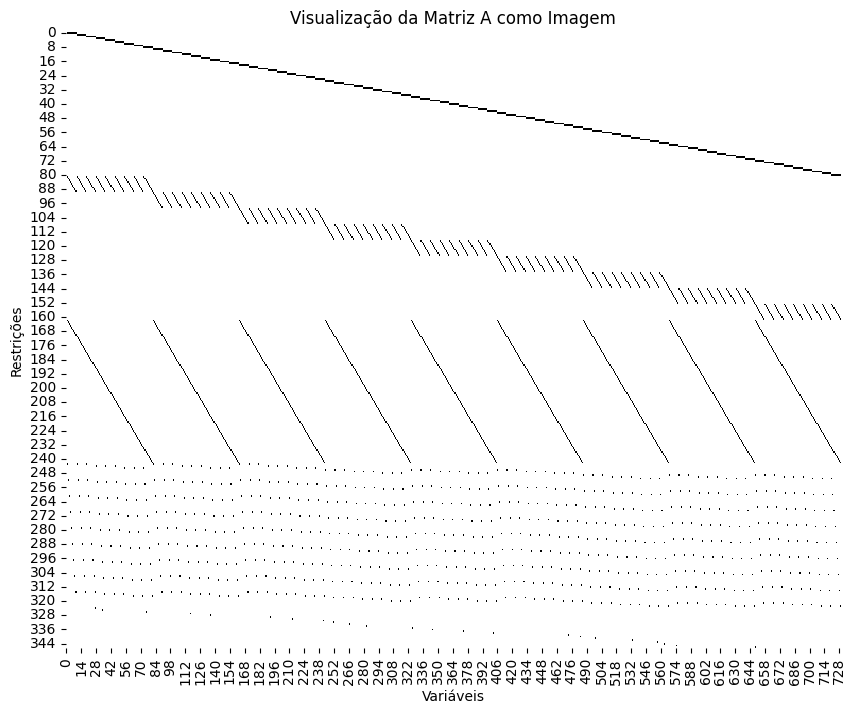

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Suponha que 'modelo' já foi definido e contém seu modelo PuLP
A = extrair_matriz_A(modelo) # Use a sua função aqui


plt.figure(figsize=(10, 8)) # Ajuste o tamanho da figura conforme necessário

# Crie o heatmap
# cbar=False remove a barra de cores, já que os valores são apenas 0s e 1s
# cmap='binary' usa um mapa de cores em preto e branco
# linewidths=0 remove as linhas entre as células para matrizes grandes
sns.heatmap(A, cbar=False, cmap='binary', linewidths=0)

plt.title("Visualização da Matriz A como Imagem")
plt.xlabel("Variáveis")
plt.ylabel("Restrições")
plt.show()

Dimensões da matriz A: (347, 730)


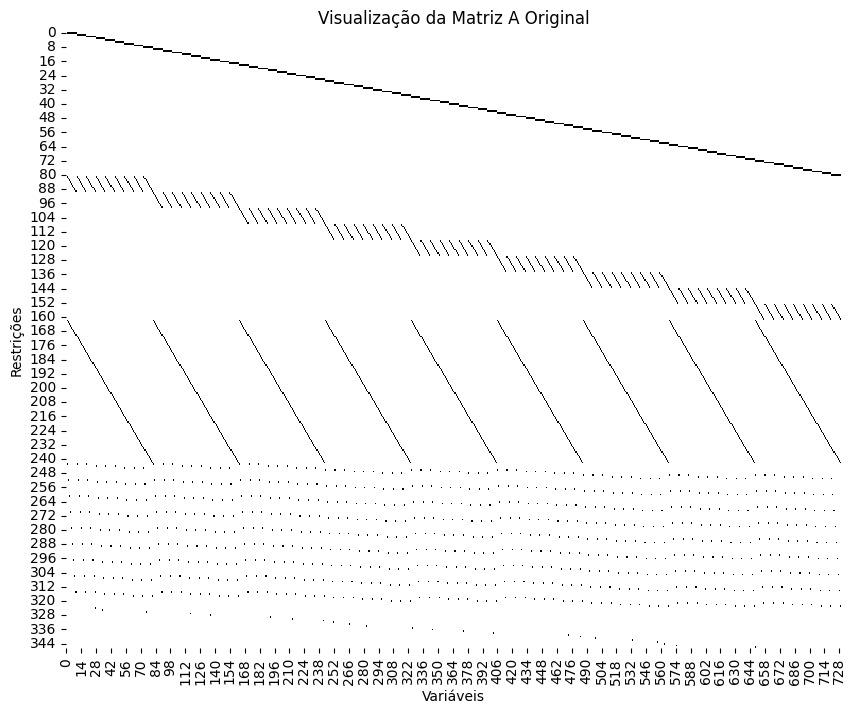


Aplicando Eliminação Gaussiana (obtendo a forma escalonada via LU)...
Decomposição LU realizada. Matriz U obtida (forma escalonada de linhas).
Dimensões da Matriz U: (347, 730)


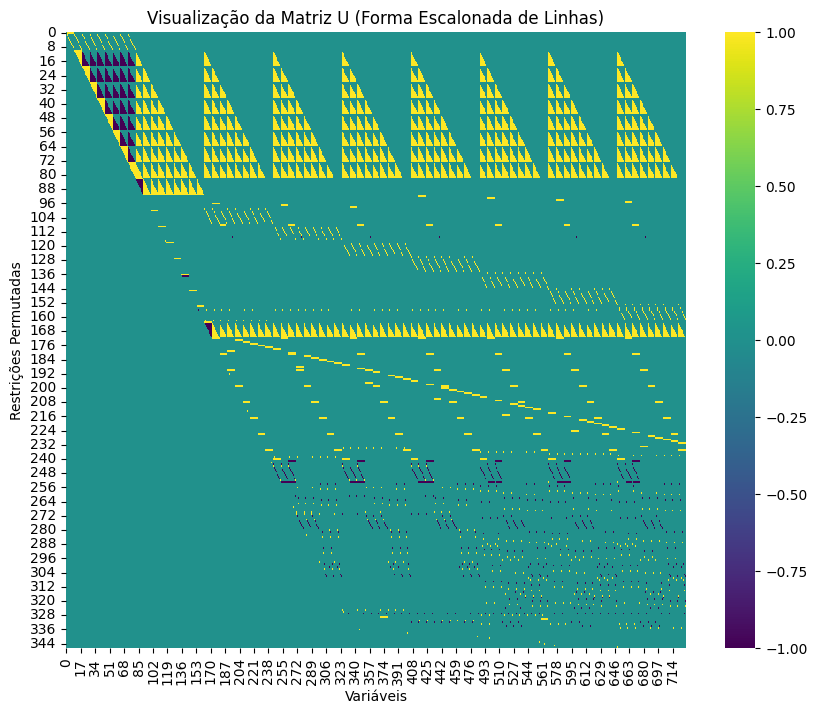


Análise da Matriz U:
Número de elementos não nulos em U: 17535
Porcentagem de não zeros em U: 6.9223%

Número de pivôs (linhas com elemento líder): 346
Valores dos pivôs (primeiros 10): [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
Índices dos pivôs (primeiros 10): [(0, np.int64(1)), (1, np.int64(1)), (2, np.int64(2)), (3, np.int64(3)), (4, np.int64(4)), (5, np.int64(5)), (6, np.int64(6)), (7, np.int64(7)), (8, np.int64(8)), (9, np.int64(9))]
Posto (rank) da matriz A original: 272
Aviso: Inconsistência no número de pivôs e posto calculado.

Note: Para matrizes não quadradas, não é possível ter uma 'diagonal principal' com tudo zerado fora dela.
O objetivo da eliminação Gaussiana é obter a forma escalonada de linhas (matriz U).

Verificação da soma das colunas na matriz U:
Soma das colunas de U (primeiros 20 valores): [ 0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2. 

In [ ]:
# Install SciPy if you haven't already
!pip install scipy
!pip install matplotlib seaborn numpy pulp

import numpy as np
from scipy.linalg import lu
import pulp
import matplotlib.pyplot as plt
import seaborn as sns

# A função extrair_matriz_A (use a versão robusta)
def extrair_matriz_A(modelo):
    """
    Extrai a matriz A de coeficientes do modelo PuLP.
    Retorna uma matriz NumPy densa.
    """
    variaveis = modelo.variables()
    num_variaveis = len(variaveis)
    var_to_index = {v: i for i, v in enumerate(variaveis)}
    restricoes = list(modelo.constraints.values())
    num_restricoes = len(restricoes)
    A = np.zeros((num_restricoes, num_variaveis), dtype=float)

    for i, restricao in enumerate(restricoes):
        for var, coef in restricao.items():
            if var in var_to_index:
                j = var_to_index[var]
                A[i, j] = coef

    return A

# Extrair a matriz A do seu modelo (assumindo 'modelo' foi criado)
A = extrair_matriz_A(modelo)

print(f"Dimensões da matriz A: {A.shape}")

# --- Visualização da Matriz A Original ---
plt.figure(figsize=(10, 8))
sns.heatmap(A, cbar=False, cmap='binary', linewidths=0)
plt.title("Visualização da Matriz A Original")
plt.xlabel("Variáveis")
plt.ylabel("Restrições")
plt.show()


# --- Aplicar Eliminação Gaussiana (via LU decomposition para obter U) ---
# P @ A = L @ U
# U é a matriz em forma escalonada de linhas (row echelon form)
# Note: LU decomposition works best for square matrices.
# For non-square matrices, lu(A) decomposes A into P @ A = L @ U where U
# has the same shape as A and is upper trapezoidal.

print("\nAplicando Eliminação Gaussiana (obtendo a forma escalonada via LU)...")
try:
    # LU decomposition will provide U which is in row echelon form
    P, L, U = lu(A)

    print("Decomposição LU realizada. Matriz U obtida (forma escalonada de linhas).")
    print("Dimensões da Matriz U:", U.shape)

    # --- Visualização da Matriz U (Forma Escalonada) ---
    plt.figure(figsize=(10, 8))
    # Use 'viridis' or 'plasma' for better visualization of non-zero values in U
    # after elimination, as they won't strictly be 0/1 anymore due to floating point ops.
    # Or use binary if you only care about zero/non-zero pattern.
    sns.heatmap(U, cmap='viridis', linewidths=0)
    plt.title("Visualização da Matriz U (Forma Escalonada de Linhas)")
    plt.xlabel("Variáveis")
    plt.ylabel("Restrições Permutadas") # Rows are permuted according to P
    plt.show()

    # --- Análise da Matriz U ---

    print("\nAnálise da Matriz U:")

    # Contar elementos não nulos (sparsity)
    nnz_U = np.count_nonzero(U)
    print(f"Número de elementos não nulos em U: {nnz_U}")
    print(f"Porcentagem de não zeros em U: {(nnz_U / U.size) * 100:.4f}%")
    # Note: U might be denser than A in some cases, or sparser depending on the matrix.

    # Analisar os pivôs ('diagonal principal' na forma escalonada)
    # Os pivôs são os primeiros elementos não nulos em cada linha não nula de U.
    # A SciPy's LU gives U where the first non-zero in each row is the pivot.
    pivots = []
    pivot_indices = []
    for i in range(U.shape[0]):
        # Find the index of the first non-zero element in row i
        non_zero_indices = np.where(np.abs(U[i, :]) > 1e-9)[0] # Use tolerance for float comparison
        if non_zero_indices.size > 0:
            first_nnz_col = non_zero_indices[0]
            pivots.append(U[i, first_nnz_col])
            pivot_indices.append((i, first_nnz_col))

    print(f"\nNúmero de pivôs (linhas com elemento líder): {len(pivots)}")
    print(f"Valores dos pivôs (primeiros 10): {pivots[:10]}")
    print(f"Índices dos pivôs (primeiros 10): {pivot_indices[:10]}")

    # O número de pivôs é igual ao posto (rank) da matriz A.
    rank_A = np.linalg.matrix_rank(A, tol=1e-9) # Calculate rank of original A for comparison
    print(f"Posto (rank) da matriz A original: {rank_A}")
    if len(pivots) == rank_A:
        print("Número de pivôs em U é consistente com o posto de A.")
    else:
        print("Aviso: Inconsistência no número de pivôs e posto calculado.")


    # O objetivo de zerar tudo fora da diagonal principal só é atingível para matrizes quadradas invertíveis
    # levadas à forma reduzida escalonada (Identidade). Para matrizes não quadradas, obtemos a forma escalonada.
    print("\nNote: Para matrizes não quadradas, não é possível ter uma 'diagonal principal' com tudo zerado fora dela.")
    print("O objetivo da eliminação Gaussiana é obter a forma escalonada de linhas (matriz U).")


    # --- Verificar a soma das colunas na matriz U ---
    print("\nVerificação da soma das colunas na matriz U:")
    column_sums_U = np.sum(U, axis=0)

    print(f"Soma das colunas de U (primeiros 20 valores): {column_sums_U[:20]}")
    print(f"Soma das colunas de U (últimos 20 valores): {column_sums_U[-20:]}")

    # Verificar se a soma das colunas passa de 2
    # Como U contém floats, compare com uma tolerância
    columns_sum_greater_than_2 = np.sum(column_sums_U > 2.0 + 1e-9)
    print(f"\nNúmero de colunas em U cuja soma é estritamente maior que 2: {columns_sum_greater_than_2}")
    print(f"Colunas cuja soma é maior que 2: {np.where(column_sums_U > 2.0 + 1e-9)[0]}")

    # O que a soma das colunas na matriz U significa?
    # A interpretação não é tão direta quanto na matriz A original (onde cada 1 representava participação em uma restrição).
    # Em U, os valores são resultados das operações de eliminação. A soma das colunas em U reflete a
    # combinação linear das restrições originais que foram aplicadas para chegar a U.
    # É mais comum analisar a esparsidade, a localização dos pivôs e o posto da matriz escalonada.

except ValueError as e:
    print(f"\nErro ao realizar a decomposição LU: {e}")
    print("Certifique-se de que a matriz A é adequada para decomposição (LU em SciPy espera que as dimensões permitam a decomposição).")
    # Note: scipy.linalg.lu handles non-square matrices by returning an upper trapezoidal U.
    # This ValueError might occur for other reasons, e.g., matrix being all zeros or inf/NaN.

In [ ]:
import numpy as np
import pulp # Para usar o objeto modelo e extrair a matriz

# A função extrair_matriz_A deve estar definida em uma célula anterior
# (usaremos a versão de ipython-input-50-a70b5b411f26 ou equivalente)

def extrair_matriz_A(modelo):
    """
    Extrai a matriz A de coeficientes do modelo PuLP.
    Retorna uma matriz NumPy densa.
    """
    variaveis = modelo.variables()
    num_variaveis = len(variaveis)
    var_to_index = {v: i for i, v in enumerate(variaveis)}
    restricoes = list(modelo.constraints.values())
    num_restricoes = len(restricoes)
    A = np.zeros((num_restricoes, num_variaveis), dtype=float) # Use float para compatibilidade geral

    for i, restricao in enumerate(restricoes):
        for var, coef in restricao.items():
            if var in var_to_index:
                j = var_to_index[var]
                A[i, j] = coef

    return A

# Extrair a matriz A do seu modelo (assumindo 'modelo' foi criado em uma célula anterior)
A = extrair_matriz_A(modelo)

print("Matriz A extraída. Dimensões:", A.shape)

# --- Calcular a soma das colunas de A original ---
# np.sum(A, axis=0) soma os elementos ao longo do eixo 0 (linhas), resultando
# na soma de cada coluna.
column_sums_A = np.sum(A, axis=0)

print("\nSoma das colunas da matriz A original:")
# Mostra os primeiros e últimos valores, pois a matriz é grande
print(f"Primeiros 20 valores: {column_sums_A[:30]}")
print(f"Últimos 20 valores: {column_sums_A[-20:]}")

# --- Verificar quais colunas têm soma maior que 2 ---
# np.where(condition) retorna os índices onde a condição é verdadeira
indices_maiores_que_2 = np.where(column_sums_A > 4)[0]

print(f"\nNúmero de colunas cuja soma é estritamente maior que 2: {len(indices_maiores_que_2)}")

if len(indices_maiores_que_2) > 0:
    print("Índices das colunas cuja soma é maior que 2:")
    # Mostra apenas os primeiros 50 índices, se houver muitos
    print(indices_maiores_que_2[:50])
    if len(indices_maiores_que_2) > 50:
        print("...")

    # Opcional: Mostrar as somas para essas colunas
    # print("\nSomas das colunas maiores que 2:")
    # print(column_sums_A[indices_maiores_que_2])

    # --- Interpretação para o Sudoku ---
    print("\nInterpretação para o modelo de Sudoku:")
    print("Cada coluna da matriz A representa uma variável de decisão x[i][j][k].")
    print("A soma de uma coluna é o número de restrições em que essa variável participa.")
    print("Variáveis x[i][j][k] participam tipicamente de 4 restrições:")
    print("1. Restrição da célula (i,j)")
    print("2. Restrição da linha i para o valor k")
    print("3. Restrição da coluna j para o valor k")
    print("4. Restrição do bloco 3x3 que contém (i,j) para o valor k")
    print("Portanto, para a maioria das variáveis (que não são fixadas nos valores iniciais),")
    print("esperamos que a soma da coluna seja exatamente 4.")
    print("As colunas com soma > 2 (especificamente 4) são as variáveis que participam de todas as suas restrições relevantes.")
    print("Colunas com soma menor que 4 (mas > 0) correspondem às variáveis que foram fixadas pelos valores iniciais.")
    print("Se A é extraída *antes* de adicionar as restrições de valores iniciais, todas as colunas das variáveis x[i][j][k] onde valores_iniciais[i-1][j-1] == 0 teriam soma 4.")
    print("As colunas correspondentes às variáveis x[i][j][valor] onde valores_iniciais[i-1][j-1] == valor seriam fixadas e não apareceriam nas outras restrições (ou teriam comportamento diferente dependendo de como a restrição é adicionada).")
    print("No seu código, as restrições de valor inicial (tipo 'Valor_Inicial_i_j') fixam a variável x[i][j][valor] como 1. Isso significa que essa variável só aparece nessa restrição com coeficiente 1.")
    print("Portanto, as colunas com soma 1 correspondem às variáveis fixadas pelos valores iniciais.")
    print("As colunas com soma 4 correspondem às variáveis que *não* foram fixadas pelos valores iniciais e participam das 4 restrições (célula, linha, coluna, bloco).")
    print("Colunas com soma 0 corresponderiam a variáveis que não aparecem em nenhuma restrição (improvável aqui).")
    print(f"\nVerificando as somas comuns: Somas 1: {np.sum(column_sums_A == 1)}, Somas 4: {np.sum(column_sums_A == 4)}")

else:
    print("Nenhuma coluna tem soma estritamente maior que 2.")

Matriz A extraída. Dimensões: (347, 730)

Soma das colunas da matriz A original:
Primeiros 20 valores: [0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 5. 4. 4.]
Últimos 20 valores: [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]

Número de colunas cuja soma é estritamente maior que 2: 23
Índices das colunas cuja soma é maior que 2:
[ 27  34  75 117 136 192 213 242 252 267 283 326 345 374 402 473 484 498
 533 557 563 575 649]

Interpretação para o modelo de Sudoku:
Cada coluna da matriz A representa uma variável de decisão x[i][j][k].
A soma de uma coluna é o número de restrições em que essa variável participa.
Variáveis x[i][j][k] participam tipicamente de 4 restrições:
1. Restrição da célula (i,j)
2. Restrição da linha i para o valor k
3. Restrição da coluna j para o valor k
4. Restrição do bloco 3x3 que contém (i,j) para o valor k
Portanto, para a maioria das variáveis (que não são fixadas nos valores iniciais),
esperamos que a soma da

In [ ]:
# Install SciPy if you haven't already
!pip install scipy

import numpy as np
from scipy.linalg import lu
import pulp
import re # Assuming re is still needed for data loading if applicable, though not directly for LU

# Assume 'modelo' is already defined and the correct extrair_matriz_A function is available
# (The one from ipython-input-50-a70b5b411f26 is recommended)

def extrair_matriz_A(modelo):
    """
    Extrai a matriz A de coeficientes do modelo PuLP.
    Retorna uma matriz NumPy densa.
    """
    # Obtem a lista de variáveis com ordem fixa
    variaveis = modelo.variables()
    num_variaveis = len(variaveis)

    # Criar um mapeamento de variáveis para índices de coluna
    var_to_index = {v: i for i, v in enumerate(variaveis)}

    # Obtem a lista de restrições
    restricoes = list(modelo.constraints.values())
    num_restricoes = len(restricoes)

    # Inicializa a matriz A com zeros
    # Usamos dtype=float para evitar erros se coeficientes não forem inteiros, embora para o Sudoku sejam.
    A = np.zeros((num_restricoes, num_variaveis), dtype=float)

    # Preenche a matriz A com os coeficientes
    for i, restricao in enumerate(restricoes):
        for var, coef in restricao.items():
            if var in var_to_index:
                j = var_to_index[var]
                A[i, j] = coef

    return A

# Extrair a matriz A do seu modelo (assumindo 'modelo' foi criado em uma célula anterior)
A = extrair_matriz_A(modelo)

print("Matriz A extraída. Dimensões:", A.shape)

# Realizar a decomposição LU
try:
    P, L, U = lu(A)

    print("\nDecomposição LU realizada com sucesso.")
    print("\nMatriz de Permutação P (formato esparso):")
    # P é uma matriz de permutações. Para visualizá-la como matriz densa:
    # print(P)

    print("\nMatriz Triangular Inferior L:")
    # print(L) # Imprimir L inteira pode ser longo

    print("\nMatriz Triangular Superior U:")
    # print(U) # Imprimir U inteira pode ser longo

    # Opcional: Verificar se P @ A - L @ U está próximo de zero
    # Para matrizes grandes, a diferença pode não ser exatamente zero devido à precisão numérica
    reconstruction_diff = np.linalg.norm(P @ A - L @ U)
    print(f"\nNorma da diferença (P @ A - L @ U): {reconstruction_diff:.4e}")

    # Verificar se P é uma matriz de permutações (aproximadamente)
    is_permutation = np.allclose(np.sort(np.sum(P, axis=1)), 1) and np.allclose(np.sort(np.sum(P, axis=0)), 1)
    print(f"Verificação: P é aproximadamente uma matriz de permutações? {is_permutation}")

    # Verificar se L é triangular inferior (aproximadamente, exceto diagonal)
    is_lower_triangular = np.allclose(np.triu(L, k=1), 0)
    print(f"Verificação: L é aproximadamente triangular inferior (acima da diagonal)? {is_lower_triangular}")
    is_unit_diagonal = np.allclose(np.diag(L), 1)
    print(f"Verificação: L tem diagonal unitária? {is_unit_diagonal}")


    # Verificar se U é triangular superior (aproximadamente, exceto diagonal)
    is_upper_triangular = np.allclose(np.tril(U, k=-1), 0)
    print(f"Verificação: U é aproximadamente triangular superior (abaixo da diagonal)? {is_upper_triangular}")


except ValueError as e:
    print(f"\nErro ao realizar a decomposição LU: {e}")
    print("A decomposição LU só pode ser aplicada a matrizes quadradas.")
    print(f"As dimensões da matriz A são: {A.shape}")

In [ ]:
import numpy as np
import pulp # Para usar o objeto modelo e extrair a matriz

# A função extrair_matriz_A deve estar definida em uma célula anterior
# (usaremos a versão de ipython-input-50-a70b5b411f26 ou equivalente)

def extrair_matriz_A(modelo):
    """
    Extrai a matriz A de coeficientes do modelo PuLP.
    Retorna uma matriz NumPy densa.
    """
    # Obtem a lista de variáveis com ordem fixa
    variaveis = modelo.variables()
    num_variaveis = len(variaveis)

    # Criar um mapeamento de variáveis para índices de coluna
    var_to_index = {v: i for i, v in enumerate(variaveis)}

    # Obtem a lista de restrições
    restricoes = list(modelo.constraints.values())
    num_restricoes = len(restricoes)

    # Inicializa a matriz A com zeros
    A = np.zeros((num_restricoes, num_variaveis), dtype=float)

    # Preenche a matriz A com os coeficientes
    for i, restricao in enumerate(restricoes):
        for var, coef in restricao.items():
            if var in var_to_index:
                j = var_to_index[var]
                A[i, j] = coef

    return A

# Extrair a matriz A do seu modelo (assumindo 'modelo' foi criado em uma célula anterior)
A = extrair_matriz_A(modelo)

print("Matriz A extraída. Dimensões:", A.shape)

# Calcular a transposta de A
A_T = A.T
print("Matriz A Transposta (A^T) criada. Dimensões:", A_T.shape)

# Calcular A^T * A
# Usamos o operador @ para multiplicação de matrizes no NumPy
ATA = A_T @ A
print("Matriz A^T * A calculada. Dimensões:", ATA.shape)

# Verificar se a matriz resultante é quadrada (deve ser)
if ATA.shape[0] == ATA.shape[1]:
    print("A matriz A^T * A é quadrada. Calculando o determinante...")
    try:
        determinante_ATA = np.linalg.det(ATA)
        print(f"\nO determinante da matriz A^T * A é: {determinante_ATA}")

        # Interpretação comum do determinante de ATA
        # Um determinante próximo de zero indica que as colunas de A são linearmente dependentes.
        # Para a matriz de restrições de um modelo LP/IP, isso pode indicar redundância entre as variáveis.
        # Em sistemas lineares A x = b, det(A^T A) = 0 implica que o sistema A x = b pode não ter solução única no sentido de mínimos quadrados.

        if np.isclose(determinante_ATA, 0):
            print("O determinante de A^T * A é zero (ou muito próximo de zero).")
            print("Isso indica que as colunas da matriz A são linearmente dependentes.")
            print("No contexto de um modelo de otimização, isso pode sugerir que existem variáveis redundantes ou que a base das variáveis não é única.")
        else:
            print("O determinante de A^T * A é diferente de zero.")
            print("Isso indica que as colunas da matriz A são linearmente independentes.")
            print("O rank de A é igual ao número de colunas (variáveis).")


    except np.linalg.LinAlgError:
        print("\nErro ao calcular o determinante de A^T * A.")
        print("A matriz A^T * A pode ser singular (apesar de ter colunas independentes) ou numericamente instável (mal condicionada).")
        # Para matrizes grandes e esparsas como a de Sudoku, problemas de precisão podem ocorrer.
        # Para verificar singularidade de forma mais robusta, pode-se olhar os valores singulares (SVD).
else:
    # Este bloco não deve ser atingido para A^T * A
    print("\nErro inesperado: A matriz A^T * A não é quadrada.")

In [ ]:
import numpy as np
import pulp # Para usar o objeto modelo e extrair a matriz

# A função extrair_matriz_A deve estar definida em uma célula anterior
# (usaremos a versão de ipython-input-50-a70b5b411f26 ou equivalente)

def extrair_matriz_A(modelo):
    """
    Extrai a matriz A de coeficientes do modelo PuLP.
    Retorna uma matriz NumPy densa.
    """
    # Obtem a lista de variáveis com ordem fixa
    variaveis = modelo.variables()
    num_variaveis = len(variaveis)

    # Criar um mapeamento de variáveis para índices de coluna
    var_to_index = {v: i for i, v in enumerate(variaveis)}

    # Obtem a lista de restrições
    restricoes = list(modelo.constraints.values())
    num_restricoes = len(restricoes)

    # Inicializa a matriz A com zeros
    A = np.zeros((num_restricoes, num_variaveis), dtype=float)

    # Preenche a matriz A com os coeficientes
    for i, restricao in enumerate(restricoes):
        for var, coef in restricao.items():
            if var in var_to_index:
                j = var_to_index[var]
                A[i, j] = coef

    return A

# Extrair a matriz A do seu modelo (assumindo 'modelo' foi criado em uma célula anterior)
A = extrair_matriz_A(modelo)

print("Matriz A extraída. Dimensões:", A.shape)

# Realizar a Decomposição em Valores Singulares (SVD)
# full_matrices=False economiza computação para matrizes não quadradas
U, S, Vt = np.linalg.svd(A, full_matrices=False)

print("\nDecomposição SVD realizada com sucesso.")
print("Dimensões de U:", U.shape)    # Vetores colunas de A
print("Dimensões de S:", S.shape)    # Valores singulares (em ordem decrescente)
print("Dimensões de Vt:", Vt.shape) # Vetores linhas de A

# Determinar o posto da matriz (número de valores singulares não nulos)
# É importante usar uma tolerância numérica para considerar valores próximos de zero como zero
tolerancia = S[0] * 1e-9 # Uma tolerância comum é uma fração do maior valor singular
rank = np.sum(S > tolerancia)

print(f"\nValores Singulares (primeiros 10): {S[:10]}") # Mostrar alguns dos maiores
print(f"Valores Singulares (últimos 10): {S[-10:]}")  # Mostrar alguns dos menores (próximos de zero)
print(f"Tolerância usada para o posto: {tolerancia:.2e}")
print(f"O posto (rank) da matriz A é: {rank}")

# A base ortogonal para o espaço das colunas são as primeiras 'rank' colunas de U
base_espaco_colunas = U[:, :rank]
print(f"\nBase ortogonal para o espaço das colunas (primeiros 5 vetores de {rank}):\n{base_espaco_colunas[:, :5]}")
print(f"Formato da base do espaço das colunas: {base_espaco_colunas.shape}")

# A base ortogonal para o espaço das linhas são as primeiras 'rank' linhas de Vt (ou colunas de V)
base_espaco_linhas = Vt[:rank, :]
print(f"\nBase ortogonal para o espaço das linhas (primeiros 5 vetores de {rank}):\n{base_espaco_linhas[:5, :]}")
print(f"Formato da base do espaço das linhas: {base_espaco_linhas.shape}")


# Opcional: Base para o Espaço Nulo (Null Space)
# O espaço nulo são os vetores x tais que Ax = 0.
# Uma base ortogonal para o espaço nulo são as últimas colunas de V (ou linhas de Vt)
# correspondentes aos valores singulares que são zero (ou muito próximos de zero).
null_space_dim = A.shape[1] - rank
print(f"\nDimensão do espaço nulo: {null_space_dim}")
if null_space_dim > 0:
    base_espaco_nulo = Vt[rank:, :].T # As colunas correspondentes aos valores singulares ~ 0
    print(f"Base ortogonal para o espaço nulo (primeiros 5 vetores de {null_space_dim}):\n{base_espaco_nulo[:, :5]}")
    print(f"Formato da base do espaço nulo: {base_espaco_nulo.shape}")
else:
    print("O espaço nulo contém apenas o vetor zero (A tem posto completo em coluna).")

In [ ]:
import numpy as np
import pulp # Para usar o objeto modelo e extrair a matriz
import networkx as nx # Para o teste de bipartição
import matplotlib.pyplot as plt # Para visualização (opcional)
import seaborn as sns # Para visualização (opcional)


# A função extrair_matriz_A (use a versão robusta)
def extrair_matriz_A(modelo):
    """
    Extrai a matriz A de coeficientes do modelo PuLP.
    Retorna uma matriz NumPy densa.
    """
    variaveis = modelo.variables()
    num_variaveis = len(variaveis)
    var_to_index = {v: i for i, v in enumerate(variaveis)}
    restricoes = list(modelo.constraints.values())
    num_restricoes = len(restricoes)
    A = np.zeros((num_restricoes, num_variaveis), dtype=float)

    for i, restricao in enumerate(restricoes):
        for var, coef in restricao.items():
            if var in var_to_index:
                j = var_to_index[var]
                A[i, j] = coef

    return A

def construir_grafo_de_incidencia(A):
    """
    Cria o grafo de incidência bipartido da matriz A.
    Um conjunto de nós representa as restrições, o outro as variáveis.
    Uma aresta existe se o coeficiente A[i,j] for não zero.
    """
    G = nx.Graph()
    num_linhas, num_colunas = A.shape

    restricoes_nodes = [f"r{i}" for i in range(num_linhas)]
    variaveis_nodes = [f"x{j}" for j in range(num_colunas)]

    G.add_nodes_from(restricoes_nodes, bipartite=0) # Lado das restrições
    G.add_nodes_from(variaveis_nodes, bipartite=1) # Lado das variáveis

    # Adiciona arestas para coeficientes não zero
    # Usamos A != 0 para considerar coeficientes -1 também
    linhas_nz, colunas_nz = np.where(A != 0)
    for i, j in zip(linhas_nz, colunas_nz):
         G.add_edge(f"r{i}", f"x{j}")

    return G


# --- Verificações Computacionais Parciais ---

# 1. Extrair a matriz A
A = extrair_matriz_A(modelo)
print(f"Dimensões da matriz A: {A.shape}")

# 2. Verificar se todos os elementos são 0, +1 ou -1
# Para a matriz do Sudoku, esperamos apenas 0s e 1s
valores_unicos = np.unique(A)
is_zero_one_minus_one = np.all(np.isin(valores_unicos, [0, 1, -1]))

print(f"\nVerificação 1: Todos os elementos de A são 0, +1 ou -1? {is_zero_one_minus_one}")
if not is_zero_one_minus_one:
    print(f"   Elementos encontrados: {valores_unicos}")
    print("   -> A matriz NÃO pode ser Totalmente Unimodular se esta condição não for atendida.")
else:
    print("   -> Condição necessária (elementos 0, +1, -1) atendida.")


# 3. Teste de Bipartição do Grafo de Incidência
print("\nVerificação 2: Teste de Bipartição do Grafo de Incidência...")
try:
    G_incidencia = construir_grafo_de_incidencia(A)
    is_bipartido = nx.is_bipartite(G_incidencia)

    print(f"O grafo de incidência da matriz A é bipartido? {is_bipartido}")
    if is_bipartido:
        print("   -> Um grafo de incidência bipartido é uma FORTE indicação de TU para certas classes de matrizes (como a do Sudoku).")
        print("   -> Para matrizes de incidência de grafos com no máximo dois não-zeros por coluna, bipartição IMPLICA TU.")
        # Podemos contar os não-zeros por coluna para ver se se enquadra nessa classe restrita
        col_nnz = np.sum(A != 0, axis=0)
        max_col_nnz = np.max(col_nnz) if col_nnz.size > 0 else 0
        print(f"   Número máximo de não-zeros por coluna: {max_col_nnz}")
        if max_col_nnz <= 2 and is_zero_one_minus_one:
             print("   -> A matriz pode se enquadrar em uma classe onde bipartição IMPLICA TU (e.g., matriz de incidência de grafo).")
        else:
             print("   -> A matriz do Sudoku tem mais de 2 não-zeros por coluna, então a bipartição por si só não PROVA TU, mas é consistente com ela.")

    else:
         print("   -> O grafo de incidência NÃO é bipartido. Isso geralmente indica que a matriz NÃO é TU.")

except Exception as e:
    print(f"Erro ao construir ou verificar o grafo de incidência: {e}")
    print("   -> Não foi possível realizar o teste de bipartição.")


# 4. Análise Teórica / Conhecimento Conhecido
print("\nAnálise Teórica:")
print("O problema do Sudoku pode ser formulado como um problema de cobertura exata ou partição, que são conhecidos por ter matrizes de restrições Totalmente Unimodulares (TU).")
print("Portanto, a matriz de restrições do modelo PuLP para o Sudoku É teoricamente TU.")
print("A TU da matriz de restrições + vetor b inteiro garante que a solução ótima de um LP relaxado será inteira, se uma solução ótima existir.")

# 5. Nota sobre o Determinante de A^T * A
# (Reiterando a conclusão anterior no contexto TU)
print("\nNota sobre o determinante de A^T * A:")
# ATA = A.T @ A # Já calculamos isso antes, se desejar pode calcular novamente
# determinante_ATA = np.linalg.det(ATA) # E calcular o determinante
# print(f"Determinante de A^T * A: {determinante_ATA}")
# print("Um determinante de A^T * A igual a zero indica colunas linearmente dependentes em A.")
# print("Para uma matriz TU (que não é necessariamente quadrada), colunas linearmente dependentes são comuns.")


# 6. Verificação computacional (INTRAVEL) da definição de TU
print("\nVerificação Direta da Definição de TU (INTRAVEL para matrizes grandes):")
print("Verificar se o determinante de *cada* submatriz quadrada é 0, +1 ou -1 é computacionalmente proibitivo para matrizes grandes.")
print(f"A matriz A ({A.shape[0]}x{A.shape[1]}) teria submatrizes de tamanhos até min({A.shape}).")
print("O número de submatrizes é enorme, tornando esta abordagem inviável na prática.")

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Parâmetros
Ln = 200
n = 15

# Função objetivo: minimizar t (a última variável do vetor)
def objective(z):
    return z[-1]  # t está no final do vetor z = [x0, x1, ..., x9, t]

# Restrições
def constraint_1_i(i):
    # i * x_i <= t * x_i  ⇔ i - t <= 0 (quando x_i > 0)
    return lambda z: z[-1] * z[i] - i * z[i]

def constraint_sum_x():
    return lambda z: np.sum(z[:-1]) - (n - 1)

def constraint_quadratic(j):
    return lambda z: 1 - (
        z[j - 1] + sum(z[i - 1] * z[i + j - 1] for i in range(1, Ln - j))
    )

# Lista de restrições
constraints = []

# 1. i * x_i <= t * x_i  para i = 1 a 10
for i in range(Ln):
    constraints.append({
        'type': 'ineq',
        'fun': constraint_1_i(i)
    })

# 2. Soma dos x_i
constraints.append({
    'type': 'eq',
    'fun': constraint_sum_x()
})

# 3. Restrições quadráticas
for j in range(1, Ln):
    constraints.append({
        'type': 'ineq',
        'fun': constraint_quadratic(j)
    })

# Limites para as variáveis x_i ∈ [0, 1], t ∈ [0, ∞)
bounds = [(0, 1)] * Ln + [(0, None)]

# Chute inicial
z0 = np.ones(Ln + 1) * 0.1

# Resolver
result = minimize(objective, z0, method='SLSQP', bounds=bounds, constraints=constraints)

# Resultados
if result.success:
    x_opt = result.x[:-1]
    t_opt = result.x[-1]
    print("Valor ótimo de t:", t_opt)
    print("Vetor x:", x_opt)
else:
    print("Otimização falhou:", result.message)


In [ ]:
def golomb_ruler_bt(n):
    best_ruler = None
    best_length = 10**9  # usar um inteiro, não float

    def backtrack(ruler, distances, last_value):
        nonlocal best_ruler, best_length

        if len(ruler) == n:
            if ruler[-1] < best_length:
                best_ruler = ruler[:]
                best_length = ruler[-1]
            return

        for next_value in range(last_value + 1, best_length):
            new_distances = [abs(next_value - mark) for mark in ruler]

            if any(d in distances for d in new_distances):
                continue

            ruler.append(next_value)
            for d in new_distances:
                distances.add(d)

            backtrack(ruler, distances, next_value)

            ruler.pop()
            for d in new_distances:
                distances.remove(d)

    backtrack([0], set(), 0)
    return best_ruler


In [ ]:
for n in range(3, 5):  # Até n = 9 para testar rapidamente
    ruler = golomb_ruler_bt(n)
    print(f"n = {n} → régua = {ruler}, comprimento = {ruler[-1]}")


n = 3 → régua = [0, 1, 3], comprimento = 3


In [ ]:
import numpy as np

# --- 1. Definição da Função Objetivo Regularizada F_w(x) ---
def F_w(x, w):
    x1, x2 = x
    # Penaliza fortemente pontos inviáveis para evitar log(0) ou log(negativo)
    # A barreira logarítmica exige que os argumentos sejam estritamente maiores que zero.
    if x1 <= 0 or x2 <= 0 or (x1 + x2 - 1) <= 0:
        return np.inf
    return w * (1 * x1 + 2 * x2) - np.log(x1 + x2 - 1) - np.log(x1) - np.log(x2)

# --- 2. Definição do Gradiente de F_w(x) ---
def grad_F_w(x, w):
    x1, x2 = x
    # Verifica a viabilidade para evitar divisões por zero ou resultados indefinidos
    if x1 <= 0 or x2 <= 0 or (x1 + x2 - 1) <= 0:
        # Retorna um gradiente 'infinito' ou um valor que indica inviabilidade
        # Em um contexto prático, isso não deveria acontecer se o ponto de partida e alpha forem bem escolhidos
        return np.array([np.inf, np.inf])

    df_dx1 = w - 1 / (x1 + x2 - 1) - 1 / x1
    df_dx2 = 2 * w - 1 / (x1 + x2 - 1) - 1 / x2
    return np.array([df_dx1, df_dx2])

# --- 3. Definição da Matriz Hessiana de F_w(x) ---
def hess_F_w(x, w):
    x1, x2 = x
    # Verifica a viabilidade
    if x1 <= 0 or x2 <= 0 or (x1 + x2 - 1) <= 0:
        return np.array([[np.inf, np.inf], [np.inf, np.inf]]) # Retorna Hessiana 'infinita'

    term_common = 1 / (x1 + x2 - 1)**2
    h11 = term_common + 1 / x1**2
    h12 = term_common
    h21 = term_common
    h22 = term_common + 1 / x2**2
    return np.array([[h11, h12], [h21, h22]])

# --- 4. Função para Calcular a Direção de Newton (delta_x) ---
def calculate_newton_direction(x_k, w):
    grad = grad_F_w(x_k, w)
    hess = hess_F_w(x_k, w)

    # Verifica se o gradiente ou a Hessiana são infinitos (ponto inviável)
    if np.any(np.isinf(grad)) or np.any(np.isinf(hess)):
        print(f"Erro: Ponto x_k={x_k} é inviável. Não é possível calcular a direção de Newton.")
        return None

    try:
        # Calcula a inversa da Hessiana e multiplica pelo gradiente
        delta_x = -np.linalg.solve(hess, grad)
        # np.linalg.solve(A, b) é mais estável e eficiente do que np.linalg.inv(A) @ b
        return delta_x
    except np.linalg.LinAlgError:
        print(f"Erro: A matriz Hessiana é singular ou não inversível em x_k={x_k}.")
        return None

# --- 5. Função de Backtracking Line Search Adaptada ---
def backtracking_line_search_constrained(F_w_func, grad_F_w_func, x_k, delta_x, w, c=1e-4, beta=0.8, epsilon=1e-8):
    alpha = 1.0 # Começamos com alpha = 1

    # Calcula o alpha máximo para manter as restrições estritas
    alpha_max_feasible = float('inf')

    # Restrição 1: x1 + x2 - 1 > epsilon
    term_g1_const = x_k[0] + x_k[1] - 1
    term_g1_delta = delta_x[0] + delta_x[1]
    if term_g1_delta < 0:
        # Se o numerador for negativo ou próximo de zero e o denominador negativo,
        # (epsilon - term_g1_const) pode ser pequeno, e (epsilon - term_g1_const) / term_g1_delta
        # pode ser um valor pequeno e positivo.
        # Precisamos de cuidado com a divisão por zero ou números muito próximos de zero.
        if abs(term_g1_delta) > 1e-10: # Evitar divisão por zero
            alpha_max_feasible = min(alpha_max_feasible, (epsilon - term_g1_const) / term_g1_delta)
        else: # Se term_g1_delta é ~0, essa restrição não limita alpha para baixo.
            pass # Não impõe um limite superior útil.

    # Restrição 2: x1 > epsilon
    if delta_x[0] < 0:
        if abs(delta_x[0]) > 1e-10:
            alpha_max_feasible = min(alpha_max_feasible, (epsilon - x_k[0]) / delta_x[0])
        else:
            pass

    # Restrição 3: x2 > epsilon
    if delta_x[1] < 0:
        if abs(delta_x[1]) > 1e-10:
            alpha_max_feasible = min(alpha_max_feasible, (epsilon - x_k[1]) / delta_x[1])
        else:
            pass

    # Ajusta o alpha inicial para ser ligeiramente menor que o máximo viável
    # ou 1, o que for menor. Isso garante que o primeiro teste já esteja no interior.
    alpha = min(alpha, alpha_max_feasible * 0.999) # Multiplicar por 0.999 para garantir que não esteja exatamente na fronteira

    # Se alpha_max_feasible foi muito pequeno ou negativo (o que indica um problema), ajuste alpha.
    if alpha <= 1e-10: # Não podemos usar um passo muito pequeno
        # Isso geralmente significa que a direção de Newton está apontando para fora da região viável muito rapidamente
        # ou o ponto atual já está muito próximo da fronteira.
        # Poderíamos considerar um passo muito pequeno como fallback ou reportar um erro.
        return 1e-8 # Retorna um passo mínimo viável, mas talvez não ótimo

    # Loop principal do backtracking
    while True:
        x_next = x_k + alpha * delta_x

        # 1. Verifica as restrições estritas para x_next
        is_strictly_feasible = True
        if (x_next[0] + x_next[1] - 1) <= epsilon:
            is_strictly_feasible = False
        if x_next[0] <= epsilon:
            is_strictly_feasible = False
        if x_next[1] <= epsilon:
            is_strictly_feasible = False

        # 2. Verifica a condição de Armijo (suficiente diminuição da função)
        try:
            val_F_w_next = F_w_func(x_next, w)
            val_F_w_k = F_w_func(x_k, w)
            grad_dot_delta_x = np.dot(grad_F_w_func(x_k, w), delta_x)
            armijo_satisfied = val_F_w_next <= val_F_w_k + c * alpha * grad_dot_delta_x
        except (ValueError, ZeroDivisionError) as e:
            # Se F_w_func(x_next) ou grad_F_w_func(x_k) geram erro, significa inviabilidade
            val_F_w_next = np.inf
            armijo_satisfied = False
            # print(f"Debug: Erro durante avaliação da função/gradiente no backtracking: {e}")

        # Condição de saída: satisfeito e estritamente viável
        if is_strictly_feasible and armijo_satisfied:
            break
        else:
            alpha *= beta # Reduz alpha
            if alpha < 1e-10: # Se alpha ficar muito pequeno, saia para evitar loop infinito
                print("Aviso: Alpha se tornou muito pequeno no backtracking. Convergência lenta ou falha.")
                break
    return alpha

# --- Parâmetros Iniciais ---
# Ponto inicial estritamente viável
# x1 + x2 - 1 > 0, x1 > 0, x2 > 0
initial_x = np.array([1.1, 0.5])
# Peso para a função objetivo original
w = 100 # Começamos com um 'w' pequeno para uma barreira mais forte

# --- Loop Interativo ---
iteration = 0
x_current = initial_x

print(f"--- Início do Método de Newton (Interativo) ---")
print(f"Ponto Inicial (x0): {x_current}")
print(f"Valor inicial de F_w(x0): {F_w(x_current, w):.4f}")
print(f"Parâmetro w: {w}")
print("\nPrecione ENTER para a próxima iteração ou 'q' para sair.")

while True:
    user_input = input(f"\nIteração {iteration}: ")
    if user_input.lower() == 'q':
        break

    # 1. Calcular a direção de Newton
    delta_x = calculate_newton_direction(x_current, w)
    if delta_x is None:
        print("Não foi possível calcular a direção de Newton. Saindo.")
        break

    print(f"  Ponto atual x_k: {x_current}")
    print(f"  Gradiente G(x_k): {grad_F_w(x_current, w)}")
    print(f"  Hessiana H(x_k): \n{hess_F_w(x_current, w)}")
    print(f"  Direção de Newton Delta_x: {delta_x}")

    # 2. Realizar o Backtracking Line Search
    alpha = backtracking_line_search_constrained(F_w, grad_F_w, x_current, delta_x, w)

    if alpha < 1e-9: # Se alpha for muito pequeno, pode indicar convergência ou problema
        print(f"  Alpha muito pequeno ({alpha:.2e}). Possível convergência ou estagnação.")
        # Se o gradiente for muito pequeno, podemos considerar convergência
        if np.linalg.norm(grad_F_w(x_current, w)) < 1e-6:
             print("  Gradiente próximo de zero. Assumindo convergência.")
             break # Sai do loop
        # Caso contrário, continua tentando
        else:
            print("  Tentando continuar com um alpha mínimo para próxima iteração.")


    print(f"  Tamanho do passo alpha: {alpha:.4f}")

    # 3. Calcular o próximo ponto
    x_next = x_current + alpha * delta_x

    # 4. Atualizar para a próxima iteração
    x_current = x_next
    iteration += 1

    print(f"  Próximo ponto x_k+1: {x_current}")
    print(f"  Valor de F_w(x_k+1): {F_w(x_current, w):.4f}")
    norm_grad = np.linalg.norm(grad_F_w(x_current, w))
    print(f"  Norma do gradiente em x_k+1: {norm_grad:.6e}")

    # Opcional: Condição de parada baseada na norma do gradiente
    if norm_grad < 1e-5 and iteration > 1:
        print("\n--- Critério de parada atingido: Norma do gradiente é muito pequena. ---")
        break

print("\n--- Fim da Execução ---")
print(f"Solução final aproximada: x = {x_current}")
print(f"Valor final de F_w(x): {F_w(x_current, w):.4f}")
print(f"Valor final da função objetivo original (c^T x): {x_current[0] + 2*x_current[1]:.4f}")


--- Início do Método de Newton (Interativo) ---
Ponto Inicial (x0): [1.1 0.5]
Valor inicial de F_w(x0): 211.1087
Parâmetro w: 100

Precione ENTER para a próxima iteração ou 'q' para sair.

Iteração 0: 
  Ponto atual x_k: [1.1 0.5]
  Gradiente G(x_k): [ 97.42424242 196.33333333]
  Hessiana H(x_k): 
[[3.60422406 2.77777778]
 [2.77777778 6.77777778]]
  Direção de Newton Delta_x: [ -6.87802198 -26.14835165]
  Tamanho do passo alpha: 0.0181
  Próximo ponto x_k+1: [0.97516988 0.02543013]
  Valor de F_w(x_k+1): 113.7185
  Norma do gradiente em x_k+1: 2.173820e+03

Iteração 1: 
  Ponto atual x_k: [0.97516988 0.02543013]
  Gradiente G(x_k): [-1567.66437949 -1505.96234391]
  Hessiana H(x_k): 
[[2777686.33166009 2777685.28008704]
 [2777685.28008704 2779231.61198109]]
  Direção de Newton Delta_x: [ 0.04043906 -0.03987469]
  Tamanho do passo alpha: 0.5097
  Próximo ponto x_k+1: [0.99578128 0.00510638]
  Valor de F_w(x_k+1): 112.9078
  Norma do gradiente em x_k+1: 1.521724e+03

Iteração 2: 
  Ponto 

In [ ]:
import pulp

# Criação do problema de maximização
prob = pulp.LpProblem("Problema_de_Programacao_Linear", pulp.LpMaximize)

# Definindo as variáveis
x1 = pulp.LpVariable('x1', lowBound=0)
x2 = pulp.LpVariable('x2', lowBound=0)
x3 = pulp.LpVariable('x3', lowBound=0)
x4 = pulp.LpVariable('x4', lowBound=0)

# Função objetivo
prob += 2 * x1 + 3 * x2 + 6 * x3 + 8 * x4, "Função_Objetivo"

# Restrições
prob += x1 + 2 * x2 + 3 * x3 + x4 >= 3, "Restrição_1"
prob += -2 * x1 + x2 - x3 + 3 * x4 <= -4, "Restrição_2"

# Resolver o problema
prob.solve()

# Mostrar o status da solução
print("Status:", pulp.LpStatus[prob.status])

# Mostrar os valores ótimos das variáveis
for v in prob.variables():
    print(f"{v.name} = {v.varValue}")

# Mostrar o valor da função objetivo
print("Valor ótimo de z =", pulp.value(prob.objective))


Status: Unbounded
x1 = 2.6
x2 = 0.0
x3 = 0.0
x4 = 0.4
Valor ótimo de z = 8.4


In [ ]:
import pulp

# Criação do problema de maximização
prob = pulp.LpProblem("Problema_Produção_Processos_Normal_e_Acelerado", pulp.LpMaximize)

# Definição das variáveis (todas ≥ 0)
# x1N = pulp.LpVariable('x1N', lowBound=0, cat='Integer')
# x1A = pulp.LpVariable('x1A', lowBound=0, cat='Integer')
# x2N = pulp.LpVariable('x2N', lowBound=0, cat='Integer')
# x2A = pulp.LpVariable('x2A', lowBound=0, cat='Integer')
# x3A = pulp.LpVariable('x3A', lowBound=0, cat='Integer')
# x4N = pulp.LpVariable('x4N', lowBound=0, cat='Integer')
# x5N = pulp.LpVariable('x5N', lowBound=0, cat='Integer')
x1N = pulp.LpVariable('x1N', lowBound=0)
x1A = pulp.LpVariable('x1A', lowBound=0)
x2N = pulp.LpVariable('x2N', lowBound=0)
x2A = pulp.LpVariable('x2A', lowBound=0)
x3A = pulp.LpVariable('x3A', lowBound=0)
x4N = pulp.LpVariable('x4N', lowBound=0)
x5N = pulp.LpVariable('x5N', lowBound=0)

# Função objetivo
prob += (
    550*x1N + 550*x1A +
    600*x2N + 600*x2A +
    350*x3A +
    400*x4N + 200*x5N
), "Lucro_Total"

# Restrições
# Capacidade do Processo Normal
# prob += 12*x1N + 20*x2N + 25*x4N + 15*x5N <= 288, "Proc_Normal"

prob += 12*x1N + 20*x2N + 25*x4N + 15*x5N <= 306, "Proc_Normal"

# Capacidade do Processo Acelerado
# prob += 10*x1A + 8*x2A + 16*x3A <= 192, "Proc_Acelerado"
prob += 10*x1A + 8*x2A + 16*x3A <= 204, "Proc_Acelerado"

# Mão de obra para Montagem Final
prob += (
    20*x1N + 20*x1A + 20*x2N + 20*x2A +
    20*x3A + 20*x4N + 20*x5N
) <= 384, "Montagem_Final"

# Resolver o problema
prob.solve()

# Mostrar os resultados
print("Status:", pulp.LpStatus[prob.status])
for var in prob.variables():
    print(f"{var.name} = {var.varValue}")
print("Valor ótimo de Z =", pulp.value(prob.objective))


Status: Optimal
x1A = 0.0
x1N = 0.0
x2A = 19.2
x2N = 0.0
x3A = 0.0
x4N = 0.0
x5N = 0.0
Valor ótimo de Z = 11520.0


In [ ]:
import pulp

# Criação do problema de minimização
prob = pulp.LpProblem("Modelo_Dual", pulp.LpMinimize)

# Definição das variáveis (todas >= 0)
y1 = pulp.LpVariable("y1", lowBound=0)
y2 = pulp.LpVariable("y2", lowBound=0)
y3 = pulp.LpVariable("y3", lowBound=0)

# Função objetivo
prob += 288 * y1 + 192 * y2 + 384 * y3, "FuncaoObjetivo"

# Restrições
prob += 12 * y1 + 20 * y3 >= 550, "Restricao1"
prob += 10 * y2 + 20 * y3 >= 550, "Restricao2"
prob += 20 * y1 + 20 * y3 >= 600, "Restricao3"
prob += 8 * y2 + 20 * y3 >= 600, "Restricao4"
prob += 16 * y2 + 20 * y3 >= 350, "Restricao5"
prob += 25 * y1 + 20 * y3 >= 400, "Restricao6"
prob += 15 * y1 + 20 * y3 >= 200, "Restricao7"

# Resolver o problema
prob.solve()

# Exibir o status e as soluções
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Valor ótimo (W): {pulp.value(prob.objective):.2f}")
print(f"y1 = {y1.varValue:.2f}")
print(f"y2 = {y2.varValue:.2f}")
print(f"y3 = {y3.varValue:.2f}")


Status: Optimal
Valor ótimo (W): 11520.00
y1 = 0.00
y2 = 0.00
y3 = 30.00


In [ ]:
import pulp

# Criação do problema de minimização
prob = pulp.LpProblem("Problema_de_Minimizacao", pulp.LpMinimize)

# Definindo as variáveis de decisão (não-negativas por padrão)
x_A = pulp.LpVariable('x_A', lowBound=0, cat='Continuous')
x_B = pulp.LpVariable('x_B', lowBound=0, cat='Continuous')
x_S = pulp.LpVariable('x_S', lowBound=0, cat='Continuous')

# Função objetivo
prob += 60 * x_A + 30 * x_B + 2500 * x_S, "Custo_Total"

# Restrições
prob += 0.60 * x_A + 0.40 * x_B + x_S == 240, "Restricao_1"
prob += x_A + 2 * x_B <= 800, "Restricao_2"

# Resolução do problema
prob.solve()

# Resultados
print("Status:", pulp.LpStatus[prob.status])
print("x_A =", x_A.varValue)
print("x_B =", x_B.varValue)
print("x_S =", x_S.varValue)
print("Z =", pulp.value(prob.objective))


Status: Optimal
x_A = 0.0
x_B = 0.0
x_S = 240.0
Z = 6000.0


In [ ]:
Fe_total = 0.60 * x_A.varValue + 0.40 * x_B.varValue + x_S.varValue
Si_total = 0.02 * x_A.varValue + 0.04 * x_B.varValue

print("Fe total:", Fe_total)
print("Si total:", Si_total)
print("Proporção Fe/Si =", Fe_total / Si_total if Si_total > 0 else "infinita")


Fe total: 240.0
Si total: 16.0
Proporção Fe/Si = 15.0


Status: Optimal
x_A = 226.66667 toneladas
x_B = 260.0 toneladas
x_S = 0.0 toneladas
Custo Total = R$ 21400.000200000002


In [ ]:
import pulp

# Criação do problema de maximização
prob = pulp.LpProblem("Problema_de_Maximizacao", pulp.LpMaximize)

# Variável y1 é irrestrita em sinal (pode ser negativa)
y1 = pulp.LpVariable('y1', lowBound=None, cat='Continuous')

# Variável y2 deve ser menor ou igual a 0
y2 = pulp.LpVariable('y2', upBound=0, cat='Continuous')

# Função objetivo
prob += 240 * y1 + 16 * y2, "Lucro_Total"

# Restrições
prob += 0.60 * y1 + 0.02 * y2 <= 60, "Restricao_1"
prob += 0.40 * y1 + 0.04 * y2 <= 30, "Restricao_2"
prob += y1 <= 2500, "Restricao_3"

# Resolução do problema
prob.solve()

# Resultados
print("Status:", pulp.LpStatus[prob.status])
print("y1 =", y1.varValue)
print("y2 =", y2.varValue)
print("W =", pulp.value(prob.objective))


Status: Optimal
y1 = 112.5
y2 = -375.0
W = 21000.0


In [ ]:
import pulp

# Criação do problema de minimização
prob = pulp.LpProblem("Problema_de_Minimizacao", pulp.LpMinimize)

# Definindo as variáveis de decisão (não-negativas por padrão)
x_A = pulp.LpVariable('x_A', lowBound=0, cat='Continuous')
x_B = pulp.LpVariable('x_B', lowBound=0, cat='Continuous')
x_C = pulp.LpVariable('x_C', lowBound=0, cat='Continuous')
x_S = pulp.LpVariable('x_S', lowBound=0, cat='Continuous')

# Função objetivo
prob += 60 * x_A + 30 * x_B + 2500 * x_S + 40 * x_C, "Custo_Total"

# Restrições
prob += 0.60 * x_A + 0.40 * x_B + x_S + 0.5 * x_C == 240, "Restricao_1"
prob += 0.02 * x_A + 0.04 * x_B + 0.02 * x_C <= 16, "Restricao_2"

# Resolução do problema
prob.solve()

# Resultados
print("Status:", pulp.LpStatus[prob.status])
print("x_A =", x_A.varValue)
print("x_B =", x_B.varValue)
print("x_C =", x_C.varValue)
print("x_S =", x_S.varValue)
print("Z =", pulp.value(prob.objective))


Status: Optimal
x_A = 0.0
x_B = 0.0
x_C = 0.0
x_S = 240.0
Z = 6000.0


In [ ]:
import pulp

# Criação do problema de maximização
prob = pulp.LpProblem("Modelo_Primal", pulp.LpMaximize)

# Definindo as variáveis de decisão (todas ≥ 0)
x1 = pulp.LpVariable('x1', lowBound=0, cat='Integer')
x2 = pulp.LpVariable('x2', lowBound=0, cat='Integer')
x3 = pulp.LpVariable('x3', lowBound=0, cat='Integer')
x4 = pulp.LpVariable('x4', lowBound=0, cat='Integer')
x5 = pulp.LpVariable('x5', lowBound=0, cat='Integer')

# Função objetivo
prob += 550*x1 + 600*x2 + 350*x3 + 400*x4 + 200*x5, "Lucro_Total"

# Restrições
prob += 12*x1 + 20*x2 + 25*x4 + 15*x5 <= 288, "Restrição_1"
prob += 10*x1 + 8*x2 + 16*x3 <= 192, "Restrição_2"
prob += 20*x1 + 20*x2 + 20*x3 + 20*x4 + 20*x5 <= 384, "Restrição_3"

# Resolver o problema
prob.solve()

# Exibir resultados
print("Status:", pulp.LpStatus[prob.status])
for var in prob.variables():
    print(f"{var.name} = {var.varValue}")
print("Valor ótimo de z =", pulp.value(prob.objective))


Status: Optimal
x1 = 12.0
x2 = 7.0
x3 = 0.0
x4 = 0.0
x5 = 0.0
Valor ótimo de z = 10800.0


In [ ]:
!pip install pulp

import pulp

def resolver_problema_corrigido(min_placas_total, method='primal'):
    # Definir o problema: Maximizar Lucro
    prob = pulp.LpProblem("Maximizar_Lucro_Montagem_Lotes", pulp.LpMaximize)

    # Variáveis de decisão (número de LOTES de 25 placas)
    # x_ij: CPU i, Tipo de Placa j
    # x11: CPU 1, Tipo 1
    # x12: CPU 1, Tipo 2
    # x21: CPU 2, Tipo 1
    # x22: CPU 2, Tipo 2
    x11 = pulp.LpVariable('x11_lotes_CPU1_Tipo1', lowBound=0, cat='Integer')
    x12 = pulp.LpVariable('x12_lotes_CPU1_Tipo2', lowBound=0, cat='Integer')
    x21 = pulp.LpVariable('x21_lotes_CPU2_Tipo1', lowBound=0, cat='Integer')
    x22 = pulp.LpVariable('x22_lotes_CPU2_Tipo2', lowBound=0, cat='Integer')

    # Função objetivo (lucro por LOTE)
    # CPU 1 / Tipo 1: 50 US$/placa * 25 = 1250 US$/lote
    # CPU 1 / Tipo 2: 70 US$/placa * 25 = 1750 US$/lote
    # CPU 2 / Tipo 1: 25 US$/placa * 25 = 625 US$/lote
    # CPU 2 / Tipo 2: 65 US$/placa * 25 = 1625 US$/lote
    prob += 1250*x11 + 1750*x12 + 625*x21 + 1625*x22, "Lucro_Total"

    # Restrições (baseadas em LOTES)

    # 1. Disponibilidade de mão de obra (homens x hora por LOTE)
    # CPU 1 / Tipo 1: 1 HxH/lote
    # CPU 1 / Tipo 2: 3 HxH/lote
    # CPU 2 / Tipo 1: 0.7 HxH/lote
    # CPU 2 / Tipo 2: 5 HxH/lote
    prob += 1*x11 + 3*x12 + 0.7*x21 + 5*x22 <= 50, "Tempo_Maximo_Homens_Hora"

    # 2. Produção mínima total (em LOTES)
    min_lotes_total = min_placas_total / 25.0
    prob += x11 + x12 + x21 + x22 >= min_lotes_total, "Quantidade_Minima_Lotes"

    # 3. Quantidades máximas por esquema (em LOTES)
    # Tabela 4.5 em placas -> converter para lotes (dividir por 25)
    # CPU 1, Tipo 1: 250 placas = 10 lotes
    # CPU 1, Tipo 2: 250 placas = 10 lotes
    # CPU 2, Tipo 1: 150 placas = 6 lotes
    # CPU 2, Tipo 2: 250 placas = 10 lotes
    prob += x11 <= 10, "Max_x11_lotes"
    prob += x12 <= 10, "Max_x12_lotes"
    prob += x21 <= 6,  "Max_x21_lotes"
    prob += x22 <= 10, "Max_x22_lotes"

    # Escolher solver CBC
    # A opção 'dual' para o CBC tentará usar o Simplex Dual para a relaxação LP.
    # Para PLI, o CBC usará Branch and Cut (que pode usar Simplex Dual ou Primal internamente).
    if method.lower() == 'dual':
        solver = pulp.PULP_CBC_CMD(msg=1, options=['dual']) # Tenta usar Dual Simplex para as relaxações LP
    else:
        solver = pulp.PULP_CBC_CMD(msg=1) # Default (geralmente primal para LP)

    prob.solve(solver)

    resultado = {
        "status": pulp.LpStatus[prob.status],
        "lucro_total": pulp.value(prob.objective),
        "x11_lotes": x11.varValue,
        "x12_lotes": x12.varValue,
        "x21_lotes": x21.varValue,
        "x22_lotes": x22.varValue,
        "duais_relaxacao_lp": {}, # Preços sombra são mais complexos de interpretar diretamente para PLI
                                  # Mas podemos obtê-los para a relaxação LP se resolvermos como LP.
        "total_placas_produzidas": (x11.varValue + x12.varValue + x21.varValue + x22.varValue) * 25
    }

    # Para obter os valores duais da relaxação LP, resolvemos novamente como LP
    if prob.status == pulp.LpStatusOptimal:
        # Criar uma cópia do problema e remover a restrição de inteireza
        prob_lp = prob.copy()
        for var in prob_lp.variables():
            var.cat = pulp.LpContinuous

        prob_lp.solve(pulp.PULP_CBC_CMD(msg=0, options=['dual' if method.lower() == 'dual' else 'primal']))
        if prob_lp.status == pulp.LpStatusOptimal:
             resultado["duais_relaxacao_lp"] = {name: c.pi for name, c in prob_lp.constraints.items()}
             resultado["lucro_total_relaxacao_lp"] = pulp.value(prob_lp.objective)


    return resultado


def main_corrigido():
    print("Escolha o método para o solver CBC (afeta principalmente a relaxação LP inicial):")
    print("1 - Primal Simplex (padrão)")
    print("2 - Dual Simplex")
    escolha_metodo_solver = input("Digite 1 ou 2: ")

    metodo_solver = 'primal'
    if escolha_metodo_solver == '2':
        metodo_solver = 'dual'
    elif escolha_metodo_solver != '1':
        print("Opção inválida. Usando primal simplex por padrão para o solver.")

    min_placas_input = input("Digite a quantidade mínima de placas a produzir (ex: 500): ")
    try:
        min_placas_total_val = int(min_placas_input)
        if min_placas_total_val < 0: raise ValueError("Quantidade não pode ser negativa")
    except ValueError:
        print("Entrada inválida para quantidade mínima. Usando 500 como padrão.")
        min_placas_total_val = 500

    # --- Parte 1.a: Solução do problema base ---
    print(f"\n--- Resolvendo para {min_placas_total_val} placas mínimas ---")
    resultado_base = resolver_problema_corrigido(min_placas_total_val, method=metodo_solver)

    print(f"\nMétodo solver (relaxação LP): {metodo_solver.capitalize()} Simplex")
    print(f"Status da solução PLI: {resultado_base['status']}")
    if resultado_base['status'] == 'Optimal':
        print(f"Lucro total (PLI): US$ {resultado_base['lucro_total']:.2f}")
        print(f"x11 (Lotes CPU1/Tipo1): {resultado_base['x11_lotes']}")
        print(f"x12 (Lotes CPU1/Tipo2): {resultado_base['x12_lotes']}")
        print(f"x21 (Lotes CPU2/Tipo1): {resultado_base['x21_lotes']}")
        print(f"x22 (Lotes CPU2/Tipo2): {resultado_base['x22_lotes']}")
        print(f"Total de placas produzidas: {resultado_base['total_placas_produzidas']}")

        if "lucro_total_relaxacao_lp" in resultado_base:
            print(f"Lucro total (Relaxação LP): US$ {resultado_base['lucro_total_relaxacao_lp']:.2f}")
            print("\nValores duais da relaxação LP das restrições:")
            for name, dual_val in resultado_base['duais_relaxacao_lp'].items():
                print(f"  {name}: {dual_val:.4f}")
    else:
        print("Não foi encontrada uma solução ótima.")

    # --- Parte 1.b: Atratividade do esquema Placa Tipo 1 x CPU 2 (x21) ---
    print("\n--- Análise de Atratividade para Placa Tipo 1 x CPU 2 (x21) ---")
    # O "custo reduzido" da relaxação LP para x21 (se for não básico = 0) indicaria o aumento
    # necessário no lucro para torná-lo interessante. Se x21 > 0 na solução ótima, ele já é atrativo.
    # Para PLI, a análise é mais complexa. Se x21_lotes > 0, já é atrativo.
    # A pergunta "qual deveria ser o mínimo valor associado" implica encontrar o ponto onde ele entra na solução.
    # Se x21_lotes (CPU2, Tipo1) = 0 na solução ótima, seu custo reduzido na relaxação LP é relevante.
    # O valor original do lucro de x21 é 625 US$/lote.
    # Se x21_lotes > 0 na solução base, ele já é atrativo com 625 US$/lote.
    # A pergunta pode ser interpretada como: "se o lucro de x21 fosse menor, a partir de que valor ele deixaria de ser produzido?"
    # ou "se não fosse produzido, quanto seu lucro precisaria aumentar?"

    # Se x21_lotes > 0 na solução ótima, ele já é "atrativo".
    if resultado_base['status'] == 'Optimal' and resultado_base['x21_lotes'] > 0:
        print(f"O esquema Placa Tipo 1 x CPU 2 (x21) já é atrativo, sendo produzido em {resultado_base['x21_lotes']} lotes.")
        print("Para que não fosse atrativo, seu valor agregado teria que diminuir.")
        # Para uma análise mais profunda, seria necessário variar o coeficiente de x21 e re-resolver.
    elif resultado_base['status'] == 'Optimal': # e x21_lotes == 0
        # Precisaríamos do custo reduzido da relaxação LP.
        # Ou então, testar iterativamente aumentando o valor de x21.
        # Se o solver for CBC, ele não expõe diretamente os custos reduzidos para variáveis inteiras da mesma forma.
        # Vamos olhar o dual da restrição Max_x21_lotes se x21_lotes = 0 (não tão direto)
        # Ou o dual da variável (reduzido) da relaxação LP.
        rc_x21 = 0
        if "duais_relaxacao_lp" in resultado_base:
            # PuLP não fornece custos reduzidos diretamente dessa forma para variáveis básicas.
            # Se x21 fosse 0 na relaxação LP, seu custo reduzido (para maximização) seria negativo.
            # O valor do dual da restrição x21 <= 0 (se adicionada) daria essa info.
            # Ou, se x21 é não-básica em 0, seu coeficiente na linha Z da relaxação LP.
            print("x21 não está na solução base. Para que se tornasse atrativo, seu lucro teria que aumentar.")
            print("  (Análise de sensibilidade mais detalhada ou inspeção do tableau da relaxação LP seria necessária para um valor exato).")
            print("  O valor original do lucro é 625 US$/lote.")


    # --- Parte 1.c: Fluxo de montagem exige 600 placas ---
    print("\n--- Análise para produção mínima de 600 placas ---")
    nova_min_placas = 600
    resultado_600 = resolver_problema_corrigido(nova_min_placas, method=metodo_solver)

    print(f"Status da solução PLI (600 placas): {resultado_600['status']}")
    if resultado_600['status'] == 'Optimal':
        print(f"Novo lucro total (PLI): US$ {resultado_600['lucro_total']:.2f}")
        print(f"x11: {resultado_600['x11_lotes']}, x12: {resultado_600['x12_lotes']}, x21: {resultado_600['x21_lotes']}, x22: {resultado_600['x22_lotes']}")
        print(f"Total de placas produzidas: {resultado_600['total_placas_produzidas']}")

        valor_agregado_medio_base = 0
        if resultado_base['status'] == 'Optimal' and resultado_base['total_placas_produzidas'] > 0 :
            valor_agregado_medio_base = resultado_base['lucro_total'] / resultado_base['total_placas_produzidas']
            print(f"Valor agregado médio original por placa: US$ {valor_agregado_medio_base:.2f}")

        valor_agregado_medio_600 = resultado_600['lucro_total'] / resultado_600['total_placas_produzidas']
        print(f"Novo valor agregado médio por placa (para {resultado_600['total_placas_produzidas']} placas): US$ {valor_agregado_medio_600:.2f}")

        if valor_agregado_medio_base > 0:
            if valor_agregado_medio_600 > valor_agregado_medio_base:
                print("O valor agregado médio por placa AUMENTOU.")
            elif valor_agregado_medio_600 < valor_agregado_medio_base:
                print("O valor agregado médio por placa DIMINUIU.")
            else:
                print("O valor agregado médio por placa MANTEVE-SE.")
    else:
        print(f"Não foi encontrada uma solução ótima para {nova_min_placas} placas mínimas.")


if __name__ == "__main__":
    main_corrigido()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 14.0 MB/s eta 0:00:00
Escolha o método para o solver CBC (afeta principalmente a relaxação LP inicial):
1 - Primal Simplex (padrão)
2 - Dual Simplex
Digite 1 ou 2: 2
Digite a quantidade mínima de placas a produzir (ex: 500): 500

--- Resolvendo para 500 placas mínimas ---

Método solver (relaxação LP): Dual Simplex
Status da solução PLI: Optimal
Lucro total (PLI): US$ 35375.00
x11 (Lotes CPU1/Tipo1): 10.0
x12 (Lotes CPU1/Tipo2): 10.0
x21 (Lotes CPU2/Tipo1): 6.0
x22 (Lotes CPU2/Tipo2): 1.0
Total de placas produzidas: 675.0
Lucro total (Relaxação LP): US$ 35635.00

Valores duais da relaxação LP das restrições:
  Tempo_Maximo_Homens_Hora: 325.0000
  Quantidade_Minima_Lotes: -0.0000
  Max_x11_lotes: 925.0000
  Max_x12_lotes: 775.0000
  Max_x21_lotes: 397.5000
  Max_x22_lotes: -0.0000

--- Análise de Atratividade para Placa Tipo 1 x CPU 2 (x21) ---
O esquema Placa Tipo 1 x CPU 2 (x21) já é atrativo, sendo produzido em 6.0 lotes.
Para 

In [ ]:
# Instalar o PuLP (se ainda não instalado)
# !pip install pulp

import pulp
import numpy as np
import re
from pulp import GUROBI_CMD

# Função para carregar dados do arquivo .dat
def carregar_dados(filepath):
    with open(filepath, 'r') as file:
        content = file.read()

    # Lê n e m
    n = int(re.search(r'param n\s*=\s*(\d+);', content).group(1))
    m = int(re.search(r'param m\s*=\s*(\d+);', content).group(1))

    # Lê capacidades
    capacidades = [0] * m
    cap_matches = re.findall(r'(\d+)\s+(\d+)', re.search(r'param C:=([\s\S]*?);', content).group(1))
    for escola_id, cap in cap_matches:
        capacidades[int(escola_id) - 1] = int(cap)

    # Lê matriz de distâncias
    dist_match = re.search(r'param d:[\s\S]*?:=(.*);', content, re.DOTALL).group(1).strip()
    linhas = dist_match.splitlines()
    distancias = np.zeros((n, m), dtype=int)

    for i, linha in enumerate(linhas):
        partes = linha.strip().split()
        for j in range(m):
            distancias[i, j] = int(partes[j + 1])  # pular o primeiro valor (índice do aluno)

    return n, m, capacidades, distancias

# Caminho para o arquivo no Google Colab (coloque ele na raiz do Colab)
arquivo_dados = "C:/Users/gdelg/OneDrive/Doutorado/PO202/Programas_aulas/simulaenem.dat"


# Carrega os dados
n, m, capacidades, distancias = carregar_dados(arquivo_dados)
M=100000
# Criar o problema
prob = pulp.LpProblem("Alocacao_Alunos_Escolas", pulp.LpMinimize)

# Variáveis de decisão
x = pulp.LpVariable.dicts("x", ((i, j) for i in range(n) for j in range(m)),
                          cat='Binary')
y = pulp.LpVariable.dicts("y", ((i) for i in range(n)),
                          cat='Continuous')

# Função objetivo: minimizar a soma das distâncias
prob += pulp.lpSum(distancias[i][j] * x[(i, j)] + M*y[(i)] for i in range(n) for j in range(m))

# Restrição: cada aluno vai para exatamente uma escola
for i in range(n):
    prob += pulp.lpSum(x[(i, j)] for j in range(m)) == 1, f"alocacao_aluno_{i}"

# Restrição: capacidade máxima das escolas
for j in range(m):
    prob += pulp.lpSum(x[(i, j)] for i in range(n)) <= capacidades[j], f"capacidade_escola_{j}"

# Restrição: distância máxima de 30
for i in range(n):
    for j in range(m):
        prob += distancias[i][j] * x[(i, j)] <= 30, f"dist_max_{i}_{j}"

# Restrição: penalizar distancia maior que 3
for i in range(n):
        prob += pulp.lpSum(distancias[i][j] * x[(i, j)] for j in range(m)) <= 3+y[(i)], f"dist_3_{i}"

# Resolver
prob.solve(GUROBI_CMD())

# Mostrar status
print("Status da solução:", pulp.LpStatus[prob.status])
print("Custo total:", pulp.value(prob.objective))

# Exemplo: mostrar os primeiros 10 alunos e suas escolas atribuídas
print("\nPrimeiros 10 alunos e escolas atribuídas:")
for i in range(10):
    for j in range(m):
        if x[(i, j)].varValue == 1:
            print(f"Aluno {i+1} -> Escola {j+1}")

print("\nPrimeiros 10000 alunos com distância menor ou igual a 3 km:")

contador = 0
for i in range(n):
    if y[i].varValue == 0:  # Significa que o aluno está dentro da distância de 3km
        for j in range(m):
            if x[(i, j)].varValue == 1:
                print(f"Aluno {i+1} -> Escola {j+1} | Distância: {distancias[i][j]} km")
                contador += 1
                print(contador)
                break  # Já encontrou a escola atribuída
        if contador >= 10000:
            print(contador)
            break


Status da solução: Optimal
Custo total: 19000044279.0

Primeiros 10 alunos e escolas atribuídas:
Aluno 1 -> Escola 19
Aluno 2 -> Escola 15
Aluno 3 -> Escola 15
Aluno 4 -> Escola 15
Aluno 5 -> Escola 8
Aluno 6 -> Escola 19
Aluno 7 -> Escola 10
Aluno 8 -> Escola 7
Aluno 9 -> Escola 4
Aluno 10 -> Escola 4


In [ ]:
import pulp

# Parâmetros
p = 10  # exemplo de coeficientes (p0, p1, ..., pp)
N = 4  # número de variáveis com índice >= 1 que entram na soma (x1 + x2 + ... + xN = 4)
M=1000
# Criação do problema
prob = pulp.LpProblem("Minimize_weighted_sum", pulp.LpMinimize)

# Variáveis de decisão
x = [pulp.LpVariable(f"x{i}", cat='Binary', lowBound=0) for i in range((p))]

# Função objetivo: min sum(p[i] * x[i])
prob += pulp.lpSum(i * x[i] for i in range(p))

# Restrição 1: soma dos xi de i = 0 até N igual a 4
prob += pulp.lpSum(x[i] for i in range(0, N)) == N

# Restrição 2: x0 = 1
prob += x[0] == 1

# Restrição 3: garantir que todas expressões (i xi - j xj) ≠ (k xk - l xl)
for i in range(0, p):
    for j in range(0, p):
        for k in range(0, p):
            for l in range(0, p):
                if (i == k) and (j == l):
                    continue  # ignora comparações triviais
                # variável binária auxiliar
                z = pulp.LpVariable(f"z_{i}_{j}_{k}_{l}", cat='Binary')
                # Expressão: (i xi - j xj) - (k xk - l xl)
                expr = (i * x[i] - j * x[j]) - (k * x[k] - l * x[l])
                prob += expr <= -1 + M * z
                prob += expr >= 1 - M * (1 - z)
# Resolver o problema
prob.solve()

# Imprimir resultados
for var in x:
    print(f"{var.name} = {var.varValue}")

print(f"Função objetivo = {pulp.value(prob.objective)}")


x0 = 1.0
x1 = 1.0
x2 = 1.0
x3 = 1.0
x4 = 0.0
x5 = 0.0
x6 = 0.0
x7 = 0.0
x8 = 0.0
x9 = 0.0
Função objetivo = 6.0


In [ ]:
import pulp

# Parâmetros
p = 10
N = 4
M = 1000

# Criação do problema
prob = pulp.LpProblem("Minimize_weighted_sum", pulp.LpMinimize)

# Variáveis binárias
x = [pulp.LpVariable(f"x{i}", cat='Binary') for i in range(p)]

# Função objetivo
prob += pulp.lpSum(i * x[i] for i in range(p))

# Restrição 1: soma x[0] a x[N-1] igual a N
prob += pulp.lpSum(x[i] for i in range(N)) == N

# Restrição 2: x0 = 1
prob += x[0] == 1

# Restrição 3: evitar expressões iguais
for i in range(p):
    for j in range(p):
        for k in range(p):
            for l in range(p):
                if (i == k and j == l):
                    continue
                z = pulp.LpVariable(f"z_{i}_{j}_{k}_{l}", cat='Binary')
                expr = (i * x[i] - j * x[j]) - (k * x[k] - l * x[l])
                prob += expr <= -1 + M * z
                prob += expr >= 1 - M * (1 - z)

# Resolver
prob.solve()

# Resultados
print("Status:", pulp.LpStatus[prob.status])
for var in x:
    print(f"{var.name} = {var.varValue}")
print(f"Função objetivo = {pulp.value(prob.objective)}")


Status: Infeasible
x0 = 1.0
x1 = 1.0
x2 = 1.0
x3 = 1.0
x4 = 0.0
x5 = 0.0
x6 = 0.0
x7 = 0.0
x8 = 0.0
x9 = 0.0
Função objetivo = 6.0


In [ ]:
range(10)

range(0, 10)

In [ ]:
print("\nPrimeiros 10 alunos e escolas atribuídas:")
for i in range(50):
    for j in range(m):
        if x[(i, j)].varValue == 1:
            print(f"Aluno {i+1} -> Escola {j+1}")


Primeiros 10 alunos e escolas atribuídas:
Aluno 1 -> Escola 7
Aluno 2 -> Escola 4
Aluno 3 -> Escola 6
Aluno 4 -> Escola 15
Aluno 5 -> Escola 8
Aluno 6 -> Escola 19
Aluno 7 -> Escola 2
Aluno 8 -> Escola 17
Aluno 9 -> Escola 11
Aluno 10 -> Escola 7
Aluno 11 -> Escola 5
Aluno 12 -> Escola 13
Aluno 13 -> Escola 14
Aluno 14 -> Escola 19
Aluno 15 -> Escola 20
Aluno 16 -> Escola 3
Aluno 17 -> Escola 14
Aluno 18 -> Escola 13
Aluno 19 -> Escola 20
Aluno 20 -> Escola 10
Aluno 21 -> Escola 15
Aluno 22 -> Escola 15
Aluno 23 -> Escola 18
Aluno 24 -> Escola 2
Aluno 25 -> Escola 20
Aluno 26 -> Escola 10
Aluno 27 -> Escola 18
Aluno 28 -> Escola 12
Aluno 29 -> Escola 16
Aluno 30 -> Escola 20
Aluno 31 -> Escola 14
Aluno 32 -> Escola 5
Aluno 33 -> Escola 19
Aluno 34 -> Escola 8
Aluno 35 -> Escola 2
Aluno 36 -> Escola 14
Aluno 37 -> Escola 8
Aluno 38 -> Escola 7
Aluno 39 -> Escola 19
Aluno 40 -> Escola 18
Aluno 41 -> Escola 5
Aluno 42 -> Escola 3
Aluno 43 -> Escola 16
Aluno 44 -> Escola 13
Aluno 45 -> Es

In [ ]:
# Instalar PuLP (descomente se necessário)
# !pip install pulp

import pulp

# Criar o problema (Maximização)
prob = pulp.LpProblem("Problema_de_Programacao_Linear", pulp.LpMaximize)

# Criar as variáveis de decisão (x1, x2, x3, x4 ≥ 0)
x1 = pulp.LpVariable("x1", lowBound=0)
x2 = pulp.LpVariable("x2", lowBound=0)
x3 = pulp.LpVariable("x3", lowBound=0)
x4 = pulp.LpVariable("x4", lowBound=0)

# Função objetivo: Max z = 2x1 + 3x2 + 6x3 + 8x4
prob += 2*x1 + 3*x2 + 6*x3 + 8*x4, "Funcao_objetivo"

# Restrições
prob += x1 + 2*x2 + 3*x3 + x4 >= 3, "Restricao_1"
prob += -2*x1 + x2 - x3 + 3*x4 <= -4, "Restricao_2"

# Resolver o problema
prob.solve()

# Mostrar o status da solução
print("Status:", pulp.LpStatus[prob.status])

# Mostrar os valores ótimos das variáveis
for variable in prob.variables():
    print(f"{variable.name} = {variable.varValue}")

# Mostrar o valor da função objetivo
print("Valor ótimo de z =", pulp.value(prob.objective))


Status: Unbounded
x1 = 2.6
x2 = 0.0
x3 = 0.0
x4 = 0.4
Valor ótimo de z = 8.4


In [ ]:
# Instalar o PuLP (geralmente já está disponível no Google Colab, mas incluímos por segurança)
# !pip install pulp

# Importar a biblioteca PuLP
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value

# Criar o problema de programação linear
model = LpProblem("Dual_Problem", LpMinimize)

# Definir as variáveis do dual
y1 = LpVariable("y1", lowBound=0)  # y1 >= 0
y2 = LpVariable("y2", lowBound=0)  # y2 >= 0

# Definir a função objetivo: Minimizar w = 12y1 + 7y2
model += 12 * y1 + 7 * y2, "Objective"

# Adicionar as restrições
model += y1 + y2 >= 2, "Constraint_1"
model += 2 * y1 - y2 >= 3, "Constraint_2"
model += y1 + 3 * y2 >= 6, "Constraint_3"

# Resolver o problema
model.solve()

# Exibir o status da solução
print("Status:", model.status)

# Exibir os valores das variáveis
print("y1 =", value(y1))
print("y2 =", value(y2))

# Exibir o valor da função objetivo
print("Valor da função objetivo (w) =", value(model.objective))

Status: 1
y1 = 2.1428571
y2 = 1.2857143
Valor da função objetivo (w) = 34.7142853


In [ ]:
import pulp

# Inicialização do modelo
model = pulp.LpProblem("Contratacao_de_Auditores", pulp.LpMinimize)

# Meses: t = 1 a 6 (março a agosto)
meses = range(1, 7)

# Parâmetros
D = {1: 7000, 2: 8000, 3: 10000, 4: 11000, 5: 10000, 6: 11000}
custo_E = 2000  # Custo por auditor experiente
custo_T = 150   # Custo por auditor em treinamento

# Variáveis
x = pulp.LpVariable.dicts("x", meses, lowBound=0, cat="Integer")  # Novos contratados
E = pulp.LpVariable.dicts("E", meses, lowBound=0, cat="Integer")  # Auditores experientes
T = pulp.LpVariable.dicts("T", meses, lowBound=0, cat="Integer")  # Auditores em treinamento
R = pulp.LpVariable.dicts("R", range(1, 7), lowBound=0, cat="Integer")

# Função objetivo
model += pulp.lpSum([custo_E * E[t] + custo_T * T[t] for t in meses]), "Custo_Total"

# Restrição inicial (t = 1): E_1 = 54
model += E[1] == 54, "E1_inicial"

# Restrições de balanço de auditores experientes e treinamento
for t in meses:
    # T_t = x_t
    model += T[t] == x[t], f"Treinamento_{t}"

# Balanço dos experientes para t = 2 a 6
for t in range(1, 6):  # t de 1 a 5
    model += R[t] <= 0.9 * E[t]         # R_t <= floor(0.9 * E_t)
    model += E[t+1] == R[t] + T[t], f"Evolucao_E_{t+1}"

# Restrição de atendimento da demanda
for t in meses:
    model += 150 * E[t] - 100 * T[t] >= D[t], f"Demanda_{t}"

# Resolver o modelo
solver = pulp.PULP_CBC_CMD()  # Ou outro solver como Gurobi, CPLEX, etc.
model.solve(solver)

# Exibir resultados
print("Status:", pulp.LpStatus[model.status])
print("Custo Total: R$", pulp.value(model.objective))
for t in meses:
  print(f"Mês {t}: tempo = {(150 * E[t].varValue - 100 * x[t].varValue):.0f}, E = {E[t].varValue:.0f}, T = {T[t].varValue:.0f}")



Status: Infeasible
Custo Total: R$ 833309.8576849999
Mês 1: tempo = 6572, E = 54, T = 15
Mês 2: tempo = 8000, E = 64, T = 16
Mês 3: tempo = 10000, E = 73, T = 10
Mês 4: tempo = 11000, E = 76, T = 4
Mês 5: tempo = 10000, E = 72, T = 8
Mês 6: tempo = 11000, E = 73, T = 0


In [ ]:
import pulp

# Inicializacao do modelo
model = pulp.LpProblem("Contratacao_de_Auditores", pulp.LpMinimize)

# Meses: t = 1 a 6 (marco a agosto)
meses = range(1, 7)

# Parametros
D = {1: 7000, 2: 8000, 3: 10000, 4: 11000, 5: 10000, 6: 11000}
custo_E = 2000  # Auditor experiente
custo_T = 150   # Auditor em treinamento
custo_Y = 2500  # Auditor terceirizado

# Variaveis
x = pulp.LpVariable.dicts("x", meses, lowBound=0, cat="Integer")
E = pulp.LpVariable.dicts("E", meses, lowBound=0, cat="Integer")
T = pulp.LpVariable.dicts("T", meses, lowBound=0, cat="Integer")
Y = pulp.LpVariable.dicts("Y", meses, lowBound=0, cat="Integer")
R = pulp.LpVariable.dicts("R", range(1, 7), lowBound=0, cat="Integer")

# Funcao objetivo
model += pulp.lpSum([custo_E * E[t] + custo_T * T[t] + custo_Y * Y[t] for t in meses])

# Restricao inicial: E_1 = 54
model += E[1] == 54

# Restricao de treinamento e balanco de experientes
for t in meses:
    model += T[t] == x[t]
for t in range(1, 6):
    model += R[t] <= 0.9 * E[t]         # R_t <= floor(0.9 * E_t)
    model += E[t+1] == R[t] + T[t]

# Restricao de demanda
for t in meses:
    model += 150 * E[t] - 100 * T[t] + 150 * Y[t] >= D[t]

# Resolver o modelo
model.solve(pulp.PULP_CBC_CMD())

# Exibir resultados
print("Status:", pulp.LpStatus[model.status])
print("Custo Total: R$", pulp.value(model.objective))
for t in meses:
    print(f"Mes {t}: Horas = {(150 * E[t].varValue - 100 * T[t].varValue + 150 * Y[t].varValue):.0f}, E = {E[t].varValue:.0f}, T = {T[t].varValue:.0f}, Y = {Y[t].varValue:.0f}")

Status: Optimal
Custo Total: R$ 828750.0
Mes 1: Horas = 7000, E = 54, T = 11, Y = 0
Mes 2: Horas = 8000, E = 59, T = 13, Y = 3
Mes 3: Horas = 10050, E = 66, T = 0, Y = 1
Mes 4: Horas = 11000, E = 59, T = 1, Y = 15
Mes 5: Horas = 10050, E = 54, T = 0, Y = 13
Mes 6: Horas = 11100, E = 48, T = 0, Y = 26


In [ ]:
import pulp

# Inicialização do modelo
model = pulp.LpProblem("Fabrica_Bobinas", pulp.LpMinimize)

# Índices
tipos = range(1, 6)  # Tipos de bobinas (1 a 5)
padroes = range(1, 11)  # Padrões de corte (1 a 10)

# Parâmetros
A = [
    [5, 2, 1, 0, 0, 0, 0, 0, 0, 1],  # Tipo 1
    [0, 0, 1, 2, 0, 0, 3, 1, 0, 0],  # Tipo 2
    [0, 0, 0, 2, 1, 0, 0, 0, 1, 0],  # Tipo 3
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 1],  # Tipo 4
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0]   # Tipo 5
]
d = [18, 31, 25, 15, 14]  # Demanda

# Variáveis
x = pulp.LpVariable.dicts("x", padroes, lowBound=0, cat="Integer")

# Função objetivo
model += pulp.lpSum([x[j] for j in padroes]), "Total_Bobinas_Mestre"

# Restrições de demanda
for i in tipos:
    model += pulp.lpSum([A[i-1][j-1] * x[j] for j in padroes]) >= d[i-1], f"Demanda_Tipo_{i}"

# Resolver o modelo
solver = pulp.PULP_CBC_CMD(msg=True)
model.solve(solver)

# Exibir resultados
print("Status:", pulp.LpStatus[model.status])
if pulp.LpStatus[model.status] == "Optimal":
    print("Número total de bobinas-mestre:", pulp.value(model.objective))
    print("Uso dos padrões de corte:")
    for j in padroes:
        if x[j].varValue > 0:
            print(f"Padrão {j}: {x[j].varValue:.0f} vezes")
    # Verificar produção por tipo
    print("\nProdução por tipo de bobina:")
    for i in tipos:
        prod = sum(A[i-1][j-1] * x[j].varValue for j in padroes)
        print(f"Tipo {i}: {prod:.0f} bobinas (Demanda: {d[i-1]})")
else:
    print("Modelo não resolvido. Verifique as restrições.")

Status: Optimal
Número total de bobinas-mestre: 37.0
Uso dos padrões de corte:
Padrão 1: 1 vezes
Padrão 2: 1 vezes
Padrão 3: 14 vezes
Padrão 4: 7 vezes
Padrão 5: 11 vezes
Padrão 8: 3 vezes

Produção por tipo de bobina:
Tipo 1: 21 bobinas (Demanda: 18)
Tipo 2: 31 bobinas (Demanda: 31)
Tipo 3: 25 bobinas (Demanda: 25)
Tipo 4: 15 bobinas (Demanda: 15)
Tipo 5: 14 bobinas (Demanda: 14)


In [ ]:
import pulp

# Inicialização do modelo
model = pulp.LpProblem("Fabrica_Bobinas_Tempo", pulp.LpMinimize)

# Índices
tipos = range(1, 6)  # Tipos de bobinas (1 a 5)
padroes = range(1, 11)  # Padrões de corte (1 a 10)

# Parâmetros
A = [
    [5, 2, 1, 0, 0, 0, 0, 0, 0, 1],  # Tipo 1
    [0, 0, 1, 2, 0, 0, 3, 1, 0, 0],  # Tipo 2
    [0, 0, 0, 2, 1, 0, 0, 0, 1, 0],  # Tipo 3
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 1],  # Tipo 4
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0]   # Tipo 5
]
d = [18, 31, 25, 15, 14]  # Demanda
tempo_troca = 3.0  # Horas por troca de padrão
tempo_corte = 0.25  # Horas por bobina cortada
M = 100  # Constante grande

# Variáveis
x = pulp.LpVariable.dicts("x", padroes, lowBound=0, cat="Integer")
y = pulp.LpVariable.dicts("y", padroes, lowBound=0, upBound=1, cat="Binary")

# Função objetivo
model += pulp.lpSum([tempo_troca * y[j] + tempo_corte * x[j] for j in padroes]), "Tempo_Total"

# Restrições
# Demanda exata
for i in tipos:
    model += pulp.lpSum([A[i-1][j-1] * x[j] for j in padroes]) >= d[i-1], f"Demanda_Tipo_{i}"

# Relacionamento x_j e y_j
for j in padroes:
    model += x[j] <= M * y[j], f"Relacao_x_y_{j}"

# Resolver o modelo
solver = pulp.PULP_CBC_CMD(msg=True)
model.solve(solver)

# Exibir resultados
print("Status:", pulp.LpStatus[model.status])
if pulp.LpStatus[model.status] == "Optimal":
    print(f"Tempo total: {pulp.value(model.objective):.2f} horas")
    print(f"Número total de bobinas-mestre: {sum(x[j].varValue for j in padroes):.0f}")
    print("Uso dos padrões de corte:")
    for j in padroes:
        if x[j].varValue > 0:
            print(f"Padrão {j}: {x[j].varValue:.0f} vezes (y_{j} = {y[j].varValue:.0f})")
    # Verificar produção por tipo
    print("\nProdução por tipo de bobina:")
    for i in tipos:
        prod = sum(A[i-1][j-1] * x[j].varValue for j in padroes)
        print(f"Tipo {i}: {prod:.0f} bobinas (Demanda: {d[i-1]})")
else:
    print("Modelo não resolvido. Verifique as restrições.")

Status: Optimal
Tempo total: 19.00 horas
Número total de bobinas-mestre: 40
Uso dos padrões de corte:
Padrão 3: 18 vezes (y_3 = 1)
Padrão 4: 7 vezes (y_4 = 1)
Padrão 5: 15 vezes (y_5 = 1)

Produção por tipo de bobina:
Tipo 1: 18 bobinas (Demanda: 18)
Tipo 2: 32 bobinas (Demanda: 31)
Tipo 3: 29 bobinas (Demanda: 25)
Tipo 4: 15 bobinas (Demanda: 15)
Tipo 5: 18 bobinas (Demanda: 14)


In [ ]:
# prompt:  Considere o problema da dieta com os dados envolvendo 2 nutrientes (vitaminas A e K) com necessidades mínimas diárias (NMD) e 5 alimentos diferentes:
# (a) Formule o problema de encontrar a dieta de custo mínimo satisfazendo as necessidades nutricionais e ache a solução ótima.
# custos=[20 20 31 11 12]; A=[1 0 1 1 2; 0 1 2 1 1]; b=[21 12] variaveis primais: [n1 n2 n3 n4 n5]

from pulp import *

# Dados do problema
custos = [20, 20, 31, 11, 12]
A = [[1, 0, 1, 1, 2], [0, 1, 2, 1, 1]]
b = [21, 12]

# Cria o problema de minimização
prob = LpProblem("Dieta", LpMinimize)

# Define as variáveis de decisão (quantidade de cada alimento)
n = len(custos)
variaveis = LpVariable.dicts("alimento", range(n), 0)

# Função objetivo (custo total)
prob += lpSum([custos[i] * variaveis[i] for i in range(n)])

# Restrições nutricionais (necessidades mínimas diárias)
for i in range(len(b)):
    prob += lpSum([A[i][j] * variaveis[j] for j in range(n)]) >= b[i]

# Resolve o problema
prob.solve()

# Imprime a solução
print("Status:", LpStatus[prob.status])

for v in prob.variables():
    print(v.name, "=", v.varValue)

print("Custo total da dieta =", value(prob.objective))


Status: Optimal
alimento_0 = 0.0
alimento_1 = 0.0
alimento_2 = 0.0
alimento_3 = 3.0
alimento_4 = 9.0
Custo total da dieta = 141.0


In [ ]:
from pulp import *

# Cria o problema de maximização (dual)
dual = LpProblem("Dieta_Dual", LpMaximize)

# Variáveis dual (preço sombra das vitaminas A e K)
y1 = LpVariable("y1", 0)  # Vitamina A
y2 = LpVariable("y2", 0)  # Vitamina K

# Função objetivo do dual
dual += 21*y1 + 12*y2

# Restrições do dual
dual += y1 <= 20      # alimento 1
dual += y2 <= 20      # alimento 2
dual += y1 + 2*y2 <= 31  # alimento 3
dual += y1 + y2 <= 11    # alimento 4
dual += 2*y1 + y2 <= 12  # alimento 5

# Resolve o problema dual
dual.solve()

# Imprime a solução
print("Status:", LpStatus[dual.status])
print("y1 (preço sombra da vitamina A) =", y1.varValue)
print("y2 (preço sombra da vitamina K) =", y2.varValue)
print("Valor ótimo dual (valor mínimo da dieta) =", value(dual.objective))


Status: Optimal
y1 (preço sombra da vitamina A) = 1.0
y2 (preço sombra da vitamina K) = 10.0
Valor ótimo dual (valor mínimo da dieta) = 141.0


#Listas

### Aula 10/04/2025

### Problema

Uma empresa deseja criar um planejamento de produção de notebooks para os próximos 4 trimestres.

- **Estoque inicial**: 5000 notebooks  
- **Demandas trimestrais esperadas**: [7000, 15000, 10000, 8000]  

- **Capacidade de produção normal por trimestre**: até 10.000 notebooks  
  - Custo por notebook: **R$ 1200,00**

- **Capacidade de produção extra por trimestre (horas-extras)**: até 2.500 notebooks  
  - Custo por notebook extra: **R$ 1500,00**

- É possível estocar notebooks produzidos para atender à demanda futura.  
  - Custo de armazenamento por notebook por trimestre: **R$ 100,00**

### Objetivo
Satisfazer a demanda total dos 4 trimestres com o **menor custo possível**, considerando produção normal, horas-extras e armazenamento.

### Modelo
Formule como um modelo de **Programação Linear Inteira Mista (PLIM)** e implemente usando **JuMP (Julia)** ou **Pyomo/AMPL (Python)**.


In [ ]:
# Ex 1

import time

# Captura o tempo inicial
inicio = time.time()

################## MODELO ###############################
conteudo_ampl = """
set T;

param DemandaTrimestral{T};
param CapacidadeTri;
param CapacidadeTriExtra;
param CustoNotebook;
param CustoNotebookExtra;
param CustoArmazenamento;
param EstoqueInicial;

# Variáveis de decisão
var ProduzNormal{T} >= 0;
var ProduzExtra{T} >= 0;
var Estoque{T} >= 0;

# Função objetivo: minimizar custo total
minimize CustoTotal:
    sum{t in T} (
        CustoNotebook * ProduzNormal[t] +
        CustoNotebookExtra * ProduzExtra[t] +
        CustoArmazenamento * Estoque[t]
    );

# Restrição: Limite de produção normal por trimestre
subject to LimiteNormal{t in T}:
    ProduzNormal[t] <= CapacidadeTri;

# Restrição: Limite de produção extra por trimestre
subject to LimiteExtra{t in T}:
    ProduzExtra[t] <= CapacidadeTriExtra;

# Restrição: Balanço do estoque (para t = 1)
subject to EstoqueInicialBalanco:
    Estoque[1] = EstoqueInicial + ProduzNormal[1] + ProduzExtra[1] - DemandaTrimestral[1];

# Restrição: Balanço do estoque (para t > 1)
subject to BalancoEstoque{t in {2,3,4}}:
    Estoque[t] = Estoque[t-1] + ProduzNormal[t] + ProduzExtra[t] - DemandaTrimestral[t];

# Restrição: Demanda de cada Tri
subject to DemandaInicial:
     Estoque[1] + ProduzNormal[1] + ProduzExtra[1] >= DemandaTrimestral[1];

# Restrição: Demanda de cada Tri
subject to DemandaTri{t in {2,3,4}}:
    Estoque[t-1] + ProduzNormal[t] + ProduzExtra[t] >= DemandaTrimestral[t];

"""

with open("/content/modelo.ampl", "w") as file:
    file.write(conteudo_ampl)

################## DADOS ###############################
conteudo_ampl = """
# Índice de trimestres
set T := 1 2 3 4;

# Demanda por trimestre
param DemandaTrimestral :=
1 7000
2 15000
3 10000
4 8000;

# Capacidade de produção normal por trimestre
param CapacidadeTri := 10000;

# Capacidade de produção com horas-extras por trimestre
param CapacidadeTriExtra := 2500;

# Custos
param CustoNotebook := 1200;
param CustoNotebookExtra := 1500;
param CustoArmazenamento := 100;

# Estoque inicial
param EstoqueInicial := 5000;
"""

with open("/content/dados.dat", "w") as file:
    file.write(conteudo_ampl)

################## SOLUÇÃO ###############################

from amplpy import AMPL

# Inicializar o AMPL
ampl = AMPL()

# Carregar arquivos
ampl.read("/content/modelo.ampl")
ampl.readData("/content/dados.dat")

# Configurar solver
ampl.setOption('solver', 'cplex')

# Resolver
ampl.solve()

# Mostrar custo total
custo_total = ampl.getObjective('CustoTotal').value()
print(f"Custo total mínimo: R$ {custo_total:,.2f}")

# Mostrar variáveis de decisão
produz_normal = ampl.getVariable("ProduzNormal")
produz_extra = ampl.getVariable("ProduzExtra")
estoque = ampl.getVariable("Estoque")

print("\nPlanejamento por trimestre:")
print("Trimestre | Produção Normal | Produção Extra | Estoque Final")
for t in ampl.getSet("T"):
    pn = produz_normal[t].value()
    pe = produz_extra[t].value()
    e = estoque[t].value()
    print(f"    {t}     |     {int(pn):5}        |     {int(pe):5}      |     {int(e):5}")


# Captura o tempo final
fim = time.time()

# Calcula o tempo decorrido
tempo_decorrido = fim - inicio
print(f"Tempo de execução: {tempo_decorrido:.2f} segundos")


CPLEX 22.1.2: CPLEX 22.1.2: optimal solution; objective 42500000
6 simplex iterations
Custo total mínimo: R$ 42,500,000.00

Planejamento por trimestre:
Trimestre | Produção Normal | Produção Extra | Estoque Final
    1     |      7000        |         0      |      5000
    2     |     10000        |         0      |         0
    3     |     10000        |         0      |         0
    4     |      8000        |         0      |         0
Tempo de execução: 0.13 segundos


In [ ]:
# prompt: Gere o código para resolver com pulp o primal e depois o dual desse problema: Exercício 1. Problema da Fábrica de Móveis
# Uma fábrica produz mesas, armários e cadeiras. A produção de cada
# móvel requer madeira e dois tipos de empregados: carpinteiro e
# marceneiro. A quantidade necessária para produzir cada móvel é dada
# pela tabela abaixo. Normalmente a empresa tem em estoque 48 placas de
# madeira, 20 horas de trabalho de marcenaria e 8 de carpintaria. A mesa é
# vendida por R$60,00, o armário por R$30,00, e a cadeira por R$20,00. A
# demanda por mesas e cadeiras é ilimitada, mas no máximo 5 armários
# podem ser vendidos. A empresa pretende maximizar a receita total.
# Recurso Mesa Armário Cadeira
# Madeira 8 6 1
# Horas de Marc. 4 2 1.5
# Horas de Carp. 2 1.5 0.
!pip install pulp
from pulp import *

# Define o problema como maximização
prob = LpProblem("Fabrica_Moveis", LpMaximize)

# Define as variáveis de decisão
mesas = LpVariable("Mesas", 0, None, LpInteger)
armarios = LpVariable("Armarios", 0, 5, LpInteger) # Limite de 5 armários
cadeiras = LpVariable("Cadeiras", 0, None, LpInteger)

# Define a função objetivo
prob += 60 * mesas + 30 * armarios + 20 * cadeiras, "Lucro"

# Define as restrições
prob += 8 * mesas + 6 * armarios + cadeiras <= 48, "Madeira"
prob += 4 * mesas + 2 * armarios + 1.5 * cadeiras <= 20, "Marceneiro"
prob += 2 * mesas + 1.5 * armarios + 0.5 * cadeiras <= 8, "Carpinteiro"

# Resolve o problema primal
prob.solve()

print("Solução do problema primal:")
print("Status:", LpStatus[prob.status])
print("Mesas =", mesas.varValue)
print("Armários =", armarios.varValue)
print("Cadeiras =", cadeiras.varValue)
print("Lucro Máximo =", value(prob.objective))

# Resolve o problema dual
dual_prob = prob.dual

dual_prob.solve()
print("\nSolução do problema dual:")
print("Status:", LpStatus[dual_prob.status])

for name, constraint in dual_prob.constraints.items():
    print(f"{name} = {constraint.pi}")

print(f"Lucro Máximo (dual) = {value(dual_prob.objective)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 100.2 MB/s eta 0:00:00
Solução do problema primal:
Status: Optimal
Mesas = 2.0
Armários = 0.0
Cadeiras = 8.0
Lucro Máximo = 280.0


AttributeError: 'LpProblem' object has no attribute 'dual'

In [ ]:
# prompt: Gere e resolva o dual desse problema: Exercício 1. Problema da Fábrica de Móveis
# Uma fábrica produz mesas, armários e cadeiras. A produção de cada
# móvel requer madeira e dois tipos de empregados: carpinteiro e
# marceneiro. A quantidade necessária para produzir cada móvel é dada
# pela tabela abaixo. Normalmente a empresa tem em estoque 48 placas de
# madeira, 20 horas de trabalho de marcenaria e 8 de carpintaria. A mesa é
# vendida por R$60,00, o armário por R$30,00, e a cadeira por R$20,00. A
# demanda por mesas e cadeiras é ilimitada, mas no máximo 5 armários
# podem ser vendidos. A empresa pretende maximizar a receita total.
# Recurso Mesa Armário Cadeira
# Madeira 8 6 1
# Horas de Marc. 4 2 1.5
# Horas de Carp. 2 1.5 0.5

# Define o problema como maximização
prob = LpProblem("Fabrica_Moveis", LpMinimize)

# Define as variáveis de decisão
madeira = LpVariable("Madeira", 0, None, LpInteger)
marceneiro = LpVariable("Marceneiro", 0, None, LpInteger) # Limite de 5 armários
carpinteiro = LpVariable("Carpinteiro", 0, None, LpInteger)
demanda = LpVariable("Demanda", 0, None, LpInteger)

# Define a função objetivo
prob += 48 * madeira + 20 * marceneiro + 8 * carpinteiro + 5 * demanda, "Lucro"

# Define as restrições
prob += 8 * madeira + 4 * marceneiro + 2 * carpinteiro >= 60, "Mesa"
prob += 6 * madeira + 2 * marceneiro + 1.5 * carpinteiro + 1 * demanda >= 30, "Armario"
prob += 1 * madeira + 1.5 * marceneiro + 0.5 * carpinteiro >= 20, "Cadeira"

# Resolve o problema primal
prob.solve()

print("Solução do problema primal:")
print("Status:", LpStatus[prob.status])
print("Madeira =", madeira.varValue)
print("Marceneiro =", marceneiro.varValue)
print("Carointeiro =", carpinteiro.varValue)
print("Demanda =", demanda.varValue)
print("Lucro Máximo =", value(prob.objective))


Solução do problema primal:
Status: Optimal
Mesas = 0.0
Armários = 10.0
Cadeiras = 10.0
Demanda = 0.0
Lucro Máximo = 280.0


AttributeError: 'LpProblem' object has no attribute 'dual'

## TC 2 Parte 1: Otimização Linear - Prof. Leduino

## Aviso Importante

**Importante**: Isto é um exercício didático da disciplina, de forma alguma é um incentivo à aposta na loteria. A probabilidade de acertar na loteria é, de qualquer forma, muito, muito pequena. Calcule!

## Objetivo do Exercício

Suponha que seu grupo foi contratado para fazer um modelo de otimização linear que encontre uma aposta de n números na mega-sena tal que:

1. O(a) apostador(a) entra inicialmente com um número da sorte escolhido arbitrariamente por ele/ela.

2. O modelo prioriza a escolha dos demais n-1 números menos sorteados considerando o histórico dos sorteios até o dia 7 de abril de 2025 (dados anexos).

3. A diferença entre a quantidade de números pares e a quantidade de números ímpares seja no máximo 2, considerando também o número da sorte.

4. A diferença entre a quantidade de números na 1ª metade superior e na 2ª metade inferior do bilhete seja no máximo 2, considerando também o número da sorte.

## Informações Adicionais

- Informações sobre a mega-sena: [Site Oficial da Caixa](https://loterias.caixa.gov.br/Paginas/mega-sena.aspx)

## Tarefa Adicional

2. [Apenas para os grupos com estudantes de pós-graduação] Use o Python para encontrar uma aposta de 6, 7, 8, 9 e 10 números.

### Solução sem PL

In [ ]:
# Importações necessárias:
import pandas as pd
import datetime
import itertools
import math

# 1. Ler o arquivo e filtrar dados até 07/04/2025:
arquivo = 'Mega-Sena.xlsx'
df = pd.read_excel(arquivo)

# Converter a coluna de data para datetime (ajuste o nome da coluna se necessário)
df['Data do Sorteio'] = pd.to_datetime(df['Data do Sorteio'], dayfirst=True)

# Filtrar os sorteios até 7 de abril de 2025
data_limite = datetime.datetime(2025, 4, 7)
df_filtrado = df[df['Data do Sorteio'] <= data_limite]

# 2. Calcular as frequências dos números de 1 a 60.
# As colunas que contém os números sorteados, por exemplo, 'Bola1' até 'Bola6'
colunas_bolas = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']

# Inicializa um dicionário para as contagens
frequencias = {i: 0 for i in range(1, 61)}

# Percorre as colunas e soma as ocorrências
for coluna in colunas_bolas:
    for num in df_filtrado[coluna]:
        if 1 <= num <= 60:
            frequencias[num] += 1

# 3. Função para verificar os critérios do bilhete:
def verifica_bilhete(bilhete):
    # bilhete é uma lista de números
    # Critério 1: diferença entre quantidade de pares e ímpares ≤ 2
    pares = sum(1 for num in bilhete if num % 2 == 0)
    impares = len(bilhete) - pares
    if abs(pares - impares) > 2:
        return False

    # Critério 2: diferença entre a quantidade de números na metade inferior (1 a 30) e na superior (31 a 60) ≤ 2
    inferior = sum(1 for num in bilhete if 1 <= num <= 30)
    superior = len(bilhete) - inferior
    if abs(inferior - superior) > 2:
        return False

    return True

# 4. Função para gerar aposta
def gera_aposta(n, numero_sorte, frequencias, pool_size=20):
    # n: quantidade total de números na aposta (6, 7, 8, 9 ou 10)
    # numero_sorte: número escolhido pelo apostador. Deve estar entre 1 e 60.
    if numero_sorte < 1 or numero_sorte > 60:
        raise ValueError("Número da sorte deve ser entre 1 e 60")

    # Cria a lista de candidatos descartando o número da sorte
    candidatos = [num for num in range(1, 61) if num != numero_sorte]

    # Ordena os candidatos por frequência (menor frequência primeiro)
    candidatos.sort(key=lambda x: frequencias[x]) # Nota de Debug: Conferi com excel, está correta a ordem.

    # Opcionalmente, reduzir pool para os (pool_size) números menos sorteados
    pool = candidatos[:pool_size]

    melhor_bilhete = None
    melhor_soma_freq = None

    # Gerar combinações de tamanho n-1 (pois o número da sorte já será incluído)
    for combinacao in itertools.combinations(pool, n - 1):
        bilhete = list(combinacao) + [numero_sorte]
        bilhete.sort()  # ordenar para exibição
        if verifica_bilhete(bilhete):
            soma_freq = sum(frequencias[num] for num in bilhete)
            if melhor_bilhete is None or soma_freq < melhor_soma_freq:
                melhor_bilhete = bilhete
                melhor_soma_freq = soma_freq

    return melhor_bilhete

# 5. Função para calcular a chance de ganhar
def chance_ganhar(n):
    return math.comb(60, 6) / math.comb(n, 6)

# 6. Execução: Escolher o número da sorte e os tamanhos de aposta desejados.
# Exemplo: número da sorte e apostas de 6, 7, 8, 9 e 10 números.
numero_sorte = 11  # Altere este valor conforme a escolha do apostador.
tamanhos_aposta = [6, 7, 8, 9, 10]

for n in tamanhos_aposta:
    bilhete = gera_aposta(n, numero_sorte, frequencias, pool_size=20)
    if bilhete is not None:
        print(f"\nAposta com {n} números (incluindo o número da sorte {numero_sorte}):")
        print(sorted(bilhete))
        print(f"Chance de ganhar: 1 em {int(chance_ganhar(n)):,d}")
    else:
        print(f"\nNão foi possível gerar uma aposta válida para {n} números com o número da sorte {numero_sorte}.")



FileNotFoundError: [Errno 2] No such file or directory: 'Mega-Sena.xlsx'

## TC 2 Parte 2: Otimização Linear - Prof. Leduino

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 26.2 MB/s eta 0:00:00


In [ ]:
# Instalar o PuLP no Google Colab, se necessário
# !pip install pulp

from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Função para resolver e exibir resultados de cada item
def solve_and_display(prob, item_name):
    prob.solve()
    print(f"\nResultados para o Item {item_name}:")
    print(f"Status: {LpStatus[prob.status]}")
    if LpStatus[prob.status] == "Optimal":
        print(f"Custo total: R${value(prob.objective):.2f}")
        print("Solução:")
        for var in prob.variables():
            if value(var) > 0:
                print(f"{var.name} = {value(var)}")

# Item (A): Modelo base
prob_a = LpProblem("Item_A", LpMinimize)

# Variáveis
x1 = LpVariable("x1", lowBound=0, cat="Integer")  # Turno de 2 dias começando dia 1
x2 = LpVariable("x2", lowBound=0, cat="Integer")  # Turno de 2 dias começando dia 2
x3 = LpVariable("x3", lowBound=0, cat="Integer")  # Turno de 2 dias começando dia 3
x4 = LpVariable("x4", lowBound=0, cat="Integer")  # Turno de 2 dias começando dia 4
y1 = LpVariable("y1", lowBound=0, cat="Integer")  # Turno de 3 dias começando dia 1
y2 = LpVariable("y2", lowBound=0, cat="Integer")  # Turno de 3 dias começando dia 2
y3 = LpVariable("y3", lowBound=0, cat="Integer")  # Turno de 3 dias começando dia 3

# Função objetivo
prob_a += 250*x1 + 250*x2 + 250*x3 + 250*x4 + 900*y1 + 900*y2 + 900*y3, "Custo_Total"

# Restrições
prob_a += x1 + y1 >= 10, "Dia1"
prob_a += x1 + x2 + y1 + y2 >= 15, "Dia2"
prob_a += x2 + x3 + y1 + y2 + y3 >= 10, "Dia3"
prob_a += x3 + x4 + y2 + y3 >= 15, "Dia4"
prob_a += x4 + y3 >= 10, "Dia5"

# Resolver e exibir
solve_and_display(prob_a, "A")

# Item (B): Adiciona limite de 10 trabalhadores iniciando por dia
prob_b = LpProblem("Item_B", LpMinimize)

# Variáveis (redefinidas para evitar reutilização)
x1 = LpVariable("x1", lowBound=0, cat="Integer")
x2 = LpVariable("x2", lowBound=0, cat="Integer")
x3 = LpVariable("x3", lowBound=0, cat="Integer")
x4 = LpVariable("x4", lowBound=0, cat="Integer")
y1 = LpVariable("y1", lowBound=0, cat="Integer")
y2 = LpVariable("y2", lowBound=0, cat="Integer")
y3 = LpVariable("y3", lowBound=0, cat="Integer")

# Função objetivo
prob_b += 250*x1 + 250*x2 + 250*x3 + 250*x4 + 900*y1 + 900*y2 + 900*y3, "Custo_Total"

# Restrições do Item (A)
prob_b += x1 + y1 >= 10, "Dia1"
prob_b += x1 + x2 + y1 + y2 >= 15, "Dia2"
prob_b += x2 + x3 + y1 + y2 + y3 >= 10, "Dia3"
prob_b += x3 + x4 + y2 + y3 >= 15, "Dia4"
prob_b += x4 + y3 >= 10, "Dia5"

# Restrições do Item (B)
prob_b += x1 + y1 <= 10, "Inicio_Dia1"
prob_b += x2 + y2 <= 10, "Inicio_Dia2"
prob_b += x3 + y3 <= 10, "Inicio_Dia3"
prob_b += x4 <= 10, "Inicio_Dia4"

# Resolver e exibir
solve_and_display(prob_b, "B")

# Item (C): Adiciona restrição sindical
prob_c = LpProblem("Item_C", LpMinimize)

# Variáveis
x1 = LpVariable("x1", lowBound=0, cat="Integer")
x2 = LpVariable("x2", lowBound=0, cat="Integer")
x3 = LpVariable("x3", lowBound=0, cat="Integer")
x4 = LpVariable("x4", lowBound=0, cat="Integer")
y1 = LpVariable("y1", lowBound=0, cat="Integer")
y2 = LpVariable("y2", lowBound=0, cat="Integer")
y3 = LpVariable("y3", lowBound=0, cat="Integer")

# Função objetivo
prob_c += 250*x1 + 250*x2 + 250*x3 + 250*x4 + 900*y1 + 900*y2 + 900*y3, "Custo_Total"

# Restrições do Item (A)
prob_c += x1 + y1 >= 10, "Dia1"
prob_c += x1 + x2 + y1 + y2 >= 15, "Dia2"
prob_c += x2 + x3 + y1 + y2 + y3 >= 10, "Dia3"
prob_c += x3 + x4 + y2 + y3 >= 15, "Dia4"
prob_c += x4 + y3 >= 10, "Dia5"

# Restrições do Item (B)
prob_c += x1 + y1 <= 10, "Inicio_Dia1"
prob_c += x2 + y2 <= 10, "Inicio_Dia2"
prob_c += x3 + y3 <= 10, "Inicio_Dia3"
prob_c += x4 <= 10, "Inicio_Dia4"

# Restrição do Item (C)
prob_c += 900*y1 + 900*y2 + 900*y3 - 250*x1 - 250*x2 - 250*x3 - 250*x4 >= 0, "Sindical"

# Resolver e exibir
solve_and_display(prob_c, "C")

# Item (D): Adiciona turno especial dos dias 1, 2 e 5
prob_d = LpProblem("Item_D", LpMinimize)

# Variáveis
x1 = LpVariable("x1", lowBound=0, cat="Integer")
x2 = LpVariable("x2", lowBound=0, cat="Integer")
x3 = LpVariable("x3", lowBound=0, cat="Integer")
x4 = LpVariable("x4", lowBound=0, cat="Integer")
y1 = LpVariable("y1", lowBound=0, cat="Integer")
y2 = LpVariable("y2", lowBound=0, cat="Integer")
y3 = LpVariable("y3", lowBound=0, cat="Integer")
z = LpVariable("z", lowBound=0, upBound=4, cat="Integer")  # Turno dias 1, 2, 5 (máximo 4)

# Função objetivo
prob_d += 250*x1 + 250*x2 + 250*x3 + 250*x4 + 900*y1 + 900*y2 + 900*y3 + 330*z, "Custo_Total"

# Restrições do Item (A), ajustadas para z
prob_d += x1 + y1 + z >= 10, "Dia1"
prob_d += x1 + x2 + y1 + y2 + z >= 15, "Dia2"
prob_d += x2 + x3 + y1 + y2 + y3 >= 10, "Dia3"
prob_d += x3 + x4 + y2 + y3 >= 15, "Dia4"
prob_d += x4 + y3 + z >= 10, "Dia5"

# Restrições do Item (B), ajustadas para z
prob_d += x1 + y1 + z <= 10, "Inicio_Dia1"
prob_d += x2 + y2 <= 10, "Inicio_Dia2"
prob_d += x3 + y3 <= 10, "Inicio_Dia3"
prob_d += x4 <= 10, "Inicio_Dia4"

# Restrição do Item (C), ajustada para z
prob_d += 900*y1 + 900*y2 + 900*y3 - 250*x1 - 250*x2 - 250*x3 - 250*x4 - 330*z >= 0, "Sindical"

# Resolver e exibir
solve_and_display(prob_d, "D")


Resultados para o Item A:
Status: Optimal
Custo total: R$7500.00
Solução:
x1 = 10.0
x2 = 5.0
x3 = 5.0
x4 = 10.0

Resultados para o Item B:
Status: Optimal
Custo total: R$7500.00
Solução:
x1 = 10.0
x2 = 5.0
x3 = 5.0
x4 = 10.0

Resultados para o Item C:
Status: Optimal
Custo total: R$10650.00
Solução:
x1 = 7.0
x2 = 2.0
x3 = 2.0
x4 = 10.0
y1 = 3.0
y2 = 3.0

Resultados para o Item D:
Status: Optimal
Custo total: R$10470.00
Solução:
x1 = 5.0
x3 = 4.0
x4 = 6.0
y1 = 1.0
y2 = 5.0
z = 4.0


In [ ]:
import pulp
import numpy as np

# Configuração para reprodutibilidade
np.random.seed(41)

# Número de parcelas
n = 60

# Gerar dados aleatórios para os parâmetros
b = np.random.uniform(0, 10, n)  # Índice de biodiversidade potencial [0, 10]
d = np.random.uniform(0, 1, n)   # Grau de degradação [0, 1]
w = np.random.choice([0, 1], n, p=[0.7, 0.3])  # Proximidade com nascente (30% das parcelas)
u = np.random.uniform(0, 10, n)  # Importância para sustento [0, 10]

# Criar o problema de otimização
prob = pulp.LpProblem("Conservacao_Serra", pulp.LpMaximize)

# Variáveis de decisão
x = pulp.LpVariable.dicts("x", range(n), cat="Binary")  # Proteção integral
y = pulp.LpVariable.dicts("y", range(n), cat="Binary")  # Uso sustentável
z = pulp.LpVariable.dicts("z", range(n), cat="Binary")  # Reflorestamento

# Função objetivo
prob += pulp.lpSum([b[i] * (1 - d[i]) * x[i] + 0.7 * b[i] * (1 - d[i]) * z[i] +
                    0.5 * b[i] * (1 - d[i]) * y[i] for i in range(n)])

# Restrições
# 1. Alocação única
for i in range(n):
    prob += x[i] + y[i] + z[i] == 1, f"Alocacao_Unica_{i}"

# 2. Proteção integral mínima (30% das parcelas)
prob += pulp.lpSum([x[i] for i in range(n)]) >= 18, "Protecao_Integral_Minima"

# 3. Proteção de nascentes
for i in range(n):
    if w[i] == 1:
        prob += x[i] + z[i] == 1, f"Protecao_Nascente_{i}"

# 4. Sustento local (máximo 50% das parcelas com u_i >= 8 para proteção integral)
high_u_indices = [i for i in range(n) if u[i] >= 8]
if high_u_indices:
    prob += pulp.lpSum([x[i] for i in high_u_indices]) <= 0.5 * len(high_u_indices), "Sustento_Local"

# 5. Reflorestamento mínimo (20% das parcelas com d_i >= 0.8)
degraded_indices = [i for i in range(n) if d[i] >= 0.8]
if degraded_indices:
    prob += pulp.lpSum([z[i] for i in degraded_indices]) >= 0.2 * len(degraded_indices), "Reflorestamento_Minimo"

# Resolver o problema
prob.solve()

# Exibir resultados
print("Status:", pulp.LpStatus[prob.status])
print(f"Valor da função objetivo: {pulp.value(prob.objective):.2f}")

# Contadores para cada tipo de alocação
protecao = 0
uso_sustentavel = 0
reflorestamento = 0

print("\nAlocação das parcelas:")
for i in range(n):
    if pulp.value(x[i]) == 1:
        print(f"Parcela {i+1}: Proteção Integral")
        protecao += 1
    elif pulp.value(y[i]) == 1:
        print(f"Parcela {i+1}: Uso Sustentável")
        uso_sustentavel += 1
    elif pulp.value(z[i]) == 1:
        print(f"Parcela {i+1}: Reflorestamento")
        reflorestamento += 1

print(f"\nResumo:")
print(f"Proteção Integral: {protecao} parcelas")
print(f"Uso Sustentável: {uso_sustentavel} parcelas")
print(f"Reflorestamento: {reflorestamento} parcelas")

# Verificação das restrições
nascentes_ok = all(pulp.value(x[i]) + pulp.value(z[i]) == 1 for i in range(n) if w[i] == 1)
print(f"\nRestrição de nascentes satisfeita: {nascentes_ok}")
print(f"Parcelas com alta importância para sustento (u_i >= 8): {len(high_u_indices)}")
print(f"Parcelas degradadas (d_i >= 0.8): {len(degraded_indices)}")

Status: Optimal
Valor da função objetivo: 150.04

Alocação das parcelas:
Parcela 1: Proteção Integral
Parcela 2: Reflorestamento
Parcela 3: Proteção Integral
Parcela 4: Reflorestamento
Parcela 5: Proteção Integral
Parcela 6: Proteção Integral
Parcela 7: Proteção Integral
Parcela 8: Proteção Integral
Parcela 9: Proteção Integral
Parcela 10: Proteção Integral
Parcela 11: Proteção Integral
Parcela 12: Reflorestamento
Parcela 13: Proteção Integral
Parcela 14: Proteção Integral
Parcela 15: Proteção Integral
Parcela 16: Reflorestamento
Parcela 17: Proteção Integral
Parcela 18: Proteção Integral
Parcela 19: Proteção Integral
Parcela 20: Reflorestamento
Parcela 21: Proteção Integral
Parcela 22: Proteção Integral
Parcela 23: Proteção Integral
Parcela 24: Proteção Integral
Parcela 25: Proteção Integral
Parcela 26: Proteção Integral
Parcela 27: Proteção Integral
Parcela 28: Reflorestamento
Parcela 29: Proteção Integral
Parcela 30: Proteção Integral
Parcela 31: Reflorestamento
Parcela 32: Reflores

In [ ]:
import pulp
import numpy as np

# Configuração para reprodutibilidade
np.random.seed(42)

# Número de parcelas
n = 60

# Gerar dados aleatórios para os parâmetros
b = np.random.uniform(0, 10, n)  # Índice de biodiversidade potencial [0, 10]
d = np.random.uniform(0, 1, n)   # Grau de degradação [0, 1]
w = np.random.choice([0, 1], n, p=[0.7, 0.3])  # Proximidade com nascente (30% das parcelas)
u = np.random.uniform(0, 10, n)  # Importância para sustento [0, 10]

# Criar o problema de otimização
prob = pulp.LpProblem("Conservacao_Serra", pulp.LpMaximize)

# Variáveis de decisão
x = pulp.LpVariable.dicts("x", range(n), cat="Binary")  # Proteção integral
y = pulp.LpVariable.dicts("y", range(n), cat="Binary")  # Uso sustentável
z = pulp.LpVariable.dicts("z", range(n), cat="Binary")  # Reflorestamento

# Função objetivo
prob += pulp.lpSum([b[i] * (1 - d[i]) * x[i] + 0.7 * b[i] * (1 - d[i]) * z[i] +
                    0.5 * b[i] * (1 - d[i]) * y[i] for i in range(n)])

# Restrições
# 1. Alocação única
for i in range(n):
    prob += x[i] + y[i] + z[i] == 1, f"Alocacao_Unica_{i}"

# 2. Proteção integral mínima (30% das parcelas)
prob += pulp.lpSum([x[i] for i in range(n)]) >= 18, "Protecao_Integral_Minima"

# 3. Proteção de nascentes
for i in range(n):
    if w[i] == 1:
        prob += x[i] + z[i] == 1, f"Protecao_Nascente_{i}"

# 4. Sustento local (máximo 50% das parcelas com u_i >= 8 para proteção integral)
high_u_indices = [i for i in range(n) if u[i] >= 8]
if high_u_indices:
    prob += pulp.lpSum([x[i] for i in high_u_indices]) <= 0.5 * len(high_u_indices), "Sustento_Local"

# 5. Reflorestamento mínimo (20% das parcelas com d_i >= 0.8)
degraded_indices = [i for i in range(n) if d[i] >= 0.8]
if degraded_indices:
    prob += pulp.lpSum([z[i] for i in degraded_indices]) >= 0.2 * len(degraded_indices), "Reflorestamento_Minimo"

# Resolver o problema
prob.solve()

# Exibir resultados
print("Status:", pulp.LpStatus[prob.status])
print(f"Valor da função objetivo: {pulp.value(prob.objective):.2f}")

# Contadores para cada tipo de alocação
protecao = 0
uso_sustentavel = 0
reflorestamento = 0
allocations = []

for i in range(n):
    if pulp.value(x[i]) == 1:
        symbol = "🌳" + ("💧" if w[i] == 1 else "")
        allocations.append(symbol)
        protecao += 1
    elif pulp.value(y[i]) == 1:
        symbol = "🌾" + ("💧" if w[i] == 1 else "")
        allocations.append(symbol)
        uso_sustentavel += 1
    elif pulp.value(z[i]) == 1:
        symbol = "🌱" + ("💧" if w[i] == 1 else "")
        allocations.append(symbol)
        reflorestamento += 1

# Visualização em grid 10x6
print("\nMapa da Serra (10x6):")
print("  | " + " | ".join(f"{j+1:2}" for j in range(6)))
print("-" * 37)
for i in range(10):
    row = allocations[i * 6:(i + 1) * 6]
    print(f"{i+1:2} | " + " | ".join(symbol for symbol in row))

print(f"\nResumo:")
print(f"Proteção Integral (🌳): {protecao} parcelas")
print(f"Uso Sustentável (🌾): {uso_sustentavel} parcelas")
print(f"Reflorestamento (🌱): {reflorestamento} parcelas")

# Verificação das restrições
nascentes_ok = all(pulp.value(x[i]) + pulp.value(z[i]) == 1 for i in range(n) if w[i] == 1)
print(f"\nRestrição de nascentes satisfeita: {nascentes_ok}")
print(f"Parcelas com alta importância para sustento (u_i >= 8): {len(high_u_indices)}")
print(f"Parcelas degradadas (d_i >= 0.8): {len(degraded_indices)}")

Status: Optimal
Valor da função objetivo: 140.27

Mapa da Serra (10x6):
  |  1 |  2 |  3 |  4 |  5 |  6
-------------------------------------
 1 | 🌳💧 | 🌳💧 | 🌱 | 🌱 | 🌳 | 🌳
 2 | 🌱💧 | 🌳💧 | 🌳 | 🌱 | 🌳 | 🌳
 3 | 🌳 | 🌳 | 🌳💧 | 🌳 | 🌳 | 🌳💧
 4 | 🌱 | 🌳💧 | 🌳💧 | 🌳 | 🌳 | 🌱
 5 | 🌳 | 🌳 | 🌳 | 🌳 | 🌳 | 🌳
 6 | 🌳💧 | 🌳 | 🌳 | 🌳 | 🌳💧 | 🌳
 7 | 🌳 | 🌳💧 | 🌳 | 🌳💧 | 🌳 | 🌳
 8 | 🌳 | 🌳 | 🌳 | 🌳💧 | 🌱 | 🌳
 9 | 🌳 | 🌳 | 🌳 | 🌳 | 🌳 | 🌳
10 | 🌳 | 🌳 | 🌳 | 🌳 | 🌱💧 | 🌳

Resumo:
Proteção Integral (🌳): 52 parcelas
Uso Sustentável (🌾): 0 parcelas
Reflorestamento (🌱): 8 parcelas

Restrição de nascentes satisfeita: True
Parcelas com alta importância para sustento (u_i >= 8): 11
Parcelas degradadas (d_i >= 0.8): 12


In [ ]:
import pulp
import numpy as np

# Configuração para reprodutibilidade
np.random.seed(42)

# Número de parcelas
n = 60

# Gerar dados aleatórios para os parâmetros
b = np.random.uniform(0, 10, n)  # Índice de biodiversidade potencial [0, 10]
d = np.random.uniform(0, 1, n)   # Grau de degradação [0, 1]
w = np.random.choice([0, 1], n, p=[0.7, 0.3])  # Proximidade com nascente (30% das parcelas)
u = np.random.uniform(0, 10, n)  # Importância para sustento [0, 10]

# Criar o problema de otimização
prob = pulp.LpProblem("Conservacao_Serra", pulp.LpMaximize)

# Variáveis de decisão
x = pulp.LpVariable.dicts("x", range(n), cat="Binary")  # Proteção integral
y = pulp.LpVariable.dicts("y", range(n), cat="Binary")  # Uso sustentável
z = pulp.LpVariable.dicts("z", range(n), cat="Binary")  # Reflorestamento

# Função objetivo
prob += pulp.lpSum([b[i] * (1 - d[i]) * x[i] + 0.7 * b[i] * (1 - d[i]) * z[i] +
                    0.5 * b[i] * (1 - d[i]) * y[i] for i in range(n)])

# Restrições
# 1. Alocação única
for i in range(n):
    prob += x[i] + y[i] + z[i] == 1, f"Alocacao_Unica_{i}"

# 2. Proteção integral mínima (30% das parcelas)
prob += pulp.lpSum([x[i] for i in range(n)]) >= 18, "Protecao_Integral_Minima"

# 3. Proteção de nascentes
for i in range(n):
    if w[i] == 1:
        prob += x[i] + z[i] == 1, f"Protecao_Nascente_{i}"

# 4. Sustento local (máximo 50% das parcelas com u_i >= 8 para proteção integral)
high_u_indices = [i for i in range(n) if u[i] >= 8]
if high_u_indices:
    prob += pulp.lpSum([x[i] for i in high_u_indices]) <= 0.5 * len(high_u_indices), "Sustento_Local"

# 5. Reflorestamento mínimo (20% das parcelas com d_i >= 0.8)
degraded_indices = [i for i in range(n) if d[i] >= 0.8]
if degraded_indices:
    prob += pulp.lpSum([z[i] for i in degraded_indices]) >= 0.2 * len(degraded_indices), "Reflorestamento_Minimo"

# 6. Garantir pelo menos uma parcela de cada tipo
prob += pulp.lpSum([x[i] for i in range(n)]) >= 1, "Min_Protecao"
prob += pulp.lpSum([y[i] for i in range(n)]) >= 1, "Min_Uso"
prob += pulp.lpSum([z[i] for i in range(n)]) >= 1, "Min_Reflorestamento"

# Resolver o problema
prob.solve()

# Exibir resultados
print("Status:", pulp.LpStatus[prob.status])
print(f"Valor da função objetivo: {pulp.value(prob.objective):.2f}")

# Contadores para cada tipo de alocação
protecao = 0
uso_sustentavel = 0
reflorestamento = 0
allocations = []

# Mapeamento de emojis para nomes compatíveis com o pacote emoji
emoji_map = {
    "protecao": "deciduous-tree",  # 🌳
    "uso": "sheaf-of-rice",        # 🌾
    "reflorestamento": "seedling", # 🌱
    "nascente": "droplet"          # 💧
}

for i in range(n):
    if pulp.value(x[i]) == 1:
        symbol = f"\\emoji{{{emoji_map['protecao']}}}" + (f"\\emoji{{{emoji_map['nascente']}}}" if w[i] == 1 else "")
        allocations.append(symbol)
        protecao += 1
    elif pulp.value(y[i]) == 1:
        symbol = f"\\emoji{{{emoji_map['uso']}}}" + (f"\\emoji{{{emoji_map['nascente']}}}" if w[i] == 1 else "")
        allocations.append(symbol)
        uso_sustentavel += 1
    elif pulp.value(z[i]) == 1:
        symbol = f"\\emoji{{{emoji_map['reflorestamento']}}}" + (f"\\emoji{{{emoji_map['nascente']}}}" if w[i] == 1 else "")
        allocations.append(symbol)
        reflorestamento += 1

# Gerar tabela LaTeX
latex_table = "\\begin{table}[h]\n\\centering\n\\caption{Mapa da Serra (10x6)}\n"
latex_table += "\\begin{tabular}{|c|*{6}{c|}}\n\\hline\n"
latex_table += " & 1 & 2 & 3 & 4 & 5 & 6 \\\\\n\\hline\n"

for i in range(10):
    row = allocations[i * 6:(i + 1) * 6]
    row_str = " & ".join(symbol for symbol in row)
    latex_table += f"{i+1} & {row_str} \\\\\n"
latex_table += "\\hline\n\\end{tabular}\n\\end{table}"

# Salvar tabela LaTeX
with open("serra_table.tex", "w", encoding="utf-8") as f:
    f.write(latex_table)

# Exibir resumo no console
print(f"\nResumo:")
print(f"Proteção Integral (\\emoji{{deciduous-tree}}): {protecao} parcelas")
print(f"Uso Sustentável (\\emoji{{sheaf-of-rice}}): {uso_sustentavel} parcelas")
print(f"Reflorestamento (\\emoji{{seedling}}): {reflorestamento} parcelas")

# Verificação das restrições
nascentes_ok = all(pulp.value(x[i]) + pulp.value(z[i]) == 1 for i in range(n) if w[i] == 1)
print(f"\nRestrição de nascentes satisfeita: {nascentes_ok}")
print(f"Parcelas com alta importância para sustento (u_i >= 8): {len(high_u_indices)}")
print(f"Parcelas degradadas (d_i >= 0.8): {len(degraded_indices)}")
print("\nTabela LaTeX salva em 'serra_table.tex'")

Status: Optimal
Valor da função objetivo: 140.25

Resumo:
Proteção Integral (\emoji{deciduous-tree}): 51 parcelas
Uso Sustentável (\emoji{sheaf-of-rice}): 1 parcelas
Reflorestamento (\emoji{seedling}): 8 parcelas

Restrição de nascentes satisfeita: True
Parcelas com alta importância para sustento (u_i >= 8): 11
Parcelas degradadas (d_i >= 0.8): 12

Tabela LaTeX salva em 'serra_table.tex'


### Solução com PL

In [ ]:
#!pip install pulp

import pandas as pd
import datetime
import math
import pulp

# 1. Ler e filtrar os dados (supondo que seu arquivo "Mega-Sena.xlsx" esteja no Colab):
arquivo = 'Mega-Sena.xlsx'
df = pd.read_excel(arquivo)

# Converter a coluna "Data do Sorteio" para datetime, lembrando que as datas estão no formato dia/mês/ano
df['Data do Sorteio'] = pd.to_datetime(df['Data do Sorteio'], dayfirst=True)
data_limite = datetime.datetime(2025, 4, 7)
df_filtrado = df[df['Data do Sorteio'] <= data_limite]

# 2. Calcular as frequências dos números de 1 a 60 usando as colunas das bolas:
colunas_bolas = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']
frequencias = {i: 0 for i in range(1, 61)}
for coluna in colunas_bolas:
    for num in df_filtrado[coluna]:
        if 1 <= num <= 60:
            frequencias[num] += 1

# 3. Modelagem com PuLP
def gera_aposta_pulp(n, numero_sorte, frequencias):
    # Cria o modelo de minimização
    modelo = pulp.LpProblem("Aposta_MegaSena", pulp.LpMinimize)

    # Variáveis: x[i] = 1 se número i for escolhido, 0 caso contrário.
    x = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in range(1, 61)}

    # Objetivo: minimizar a soma das frequências dos números selecionados.
    modelo += pulp.lpSum(frequencias[i] * x[i] for i in range(1, 61))

    # Restrição 1: escolher exatamente n números.
    modelo += pulp.lpSum(x[i] for i in range(1, 61)) == n, "TotalNumerosSelecionados"

    # Restrição 2: garantir que o número da sorte seja escolhido.
    if numero_sorte < 1 or numero_sorte > 60:
        raise ValueError("O número da sorte deve ser entre 1 e 60.")
    modelo += x[numero_sorte] == 1, "NumeroSorte"

    # Restrição 3: Diferença entre quantidade de pares e ímpares no máximo 2.
    soma_pares = pulp.lpSum(x[i] for i in range(1, 61) if i % 2 == 0)
    soma_impares = pulp.lpSum(x[i] for i in range(1, 61) if i % 2 != 0)
    modelo += (soma_pares - soma_impares) <= 2, "ParImpar_Pos"
    modelo += (soma_impares - soma_pares) <= 2, "ParImpar_Neg"

    # Restrição 4: Diferença entre números da primeira metade (1 a 30) e da segunda metade (31 a 60) no máximo 2.
    soma_inferior = pulp.lpSum(x[i] for i in range(1, 31))
    soma_superior = pulp.lpSum(x[i] for i in range(31, 61))
    modelo += (soma_inferior - soma_superior) <= 2, "Metade_Pos"
    modelo += (soma_superior - soma_inferior) <= 2, "Metade_Neg"

    # Resolve o modelo
    status = modelo.solve()

    if status != pulp.LpStatusOptimal:
        return None, None  # Não encontrou solução ótima

    # Obtém a solução: os números onde x[i] == 1
    bilhete = [i for i in range(1, 61) if pulp.value(x[i]) == 1]
    soma_freq = sum(frequencias[i] for i in bilhete)

    return bilhete, soma_freq

# 4. Função para calcular a chance de ganhar
def chance_ganhar(n):
    return math.comb(60, 6) / math.comb(n, 6)

# 5. Execução: exemplo com diferentes tamanhos de aposta e um número da sorte escolhido
numero_sorte = 11  # Altere conforme a escolha do apostador.
tamanhos_aposta = [6, 7, 8, 9, 10]

for n in tamanhos_aposta:
    bilhete, soma_freq = gera_aposta_pulp(n, numero_sorte, frequencias)
    if bilhete is not None:
        bilhete.sort()
        print(f"\nAposta com {n} números (incluindo o número da sorte {numero_sorte}):")
        print("Bilhete:", bilhete)
        print("Soma das frequências:", soma_freq)
        print("Chance de ganhar: 1 em {:,}".format(chance_ganhar(n)))
    else:
        print(f"\nNão foi possível gerar uma aposta válida para {n} números com o número da sorte {numero_sorte}.")


In [ ]:
!pip install pulp
import pulp

# Criação do modelo
model = pulp.LpProblem("Redução_de_Contaminantes", pulp.LpMinimize)

# Variáveis de decisão
x11 = pulp.LpVariable("x11", 0, 1)  # Medida 1 - Altos Fornos
x21 = pulp.LpVariable("x21", 0, 1)  # Medida 2 - Altos Fornos
x31 = pulp.LpVariable("x31", 0, 1)  # Medida 3 - Altos Fornos

y12 = pulp.LpVariable("y12", 0, 1)  # Medida 1 - Fornos Abertos
y22 = pulp.LpVariable("y22", 0, 1)  # Medida 2 - Fornos Abertos
y32 = pulp.LpVariable("y32", 0, 1)  # Medida 3 - Fornos Abertos

# Função objetivo
model += (
    8 * x11 + 7 * x21 + 11 * x31 +
    10 * y12 + 6 * y22 + 9 * y32
)

# Restrições de redução mínima
model += (
    12 * x11 + 25 * x21 + 17 * x31 +
    9 * y12 + 20 * y22 + 13 * y32 >= 60, "Partículas"
)

model += (
    35 * x11 + 18 * x21 + 56 * x31 +
    42 * y12 + 31 * y22 + 49 * y32 >= 150, "ÓxidoSulfúrico"
)

model += (
    37 * x11 + 28 * x21 + 29 * x31 +
    53 * y12 + 34 * y22 + 20 * y32 >= 125, "Hidrocarbonetos"
)

# Resolver
model.solve()

# Resultados
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Custo Total: ${pulp.value(model.objective):.2f} milhões")

for var in model.variables():
    print(f"{var.name} = {var.varValue:.4f}")


Aula dia 17/04

In [ ]:
# Instalar PuLP (só precisa fazer isso uma vez no Colab)
!pip install -q pulp

import pulp

# Parâmetros
l = 8  # número de linhas
c = l  # número de colunas

# Criar o modelo
model = pulp.LpProblem("Rainhas_Maximizadas", pulp.LpMaximize)

# Variáveis binárias x[i][j] = 1 se há uma rainha na posição (i, j)
x = [[pulp.LpVariable(f"x_{i}_{j}", cat="Binary") for j in range(c)] for i in range(l)]

# Função objetivo
model += pulp.lpSum(((i + j) % 2 == 0 and 1 or 2) * x[i][j] for i in range(l) for j in range(c))

# Restrição: uma única rainha por coluna
for j in range(c):
    model += pulp.lpSum(x[i][j] for i in range(l)) <= 1

# Restrição: uma única rainha por linha
for i in range(l):
    model += pulp.lpSum(x[i][j] for j in range(c)) <= 1

# Restrição: no máximo uma rainha por diagonal principal (j - i constante)
for k in range(-(c - 1), c):
    model += pulp.lpSum(x[i][j] for i in range(l) for j in range(c) if j - i == k) <= 1

# Restrição: no máximo uma rainha por diagonal secundária (i + j constante)
for k in range(2 * c):
    model += pulp.lpSum(x[i][j] for i in range(l) for j in range(c) if i + j == k) <= 1

# Resolver o modelo
model.solve()

# Resultados
print("Status da otimização:", pulp.LpStatus[model.status])
print("Valor ótimo z =", pulp.value(model.objective))

# Mostrar o tabuleiro com rainhas
print("\nTabuleiro com Rainhas:")
for i in range(l):
    row = ""
    for j in range(c):
        row += "♛ " if pulp.value(x[i][j]) == 1 else ". "
    print(row)


In [ ]:
Exercício 1. Problema da Fábrica de Móveis
Uma fábrica produz mesas, armários e cadeiras. A produção de cada
móvel requer madeira e dois tipos de empregados: carpinteiro e
marceneiro. A quantidade necessária para produzir cada móvel é dada
pela tabela abaixo. Normalmente a empresa tem em estoque 48 placas de
madeira, 20 horas de trabalho de marcenaria e 8 de carpintaria. A mesa é
vendida por R$60,00, o armário por R$30,00, e a cadeira por R$20,00. A
demanda por mesas e cadeiras é ilimitada, mas no máximo 5 armários
podem ser vendidos. A empresa pretende maximizar a receita total.

problema primal:
max 60*m + 30*a + 20*c
sa (madeira) 8m + 6a + c <= 48
 (hora de marc) 4m + 2a + 1.5c <= 20
 (carpintaria) 2m + 1.5a + 0.5c <= 8
 a <= 5
 m, a, c >= 0

 problema dual:



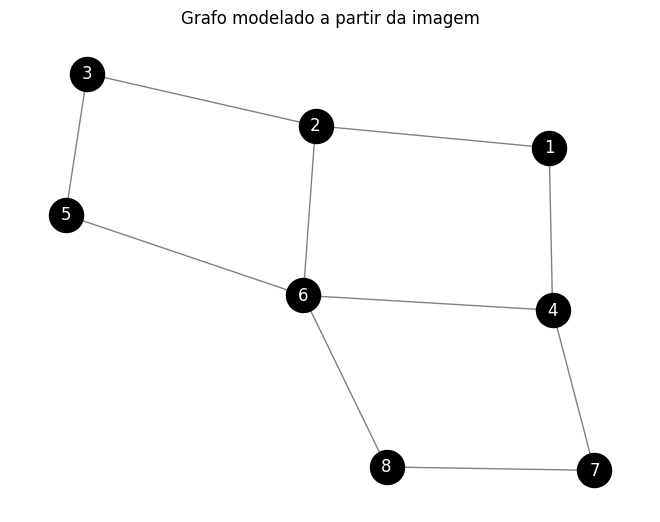

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Criação do grafo
G = nx.Graph()

# Lista de arestas conforme você indicou
edges = [
    (1, 2),
    (1, 4),
    (2, 3),
    (2, 6),
    (3, 5),
    (4, 6),
    (4, 7),
    (5, 6),
    (6, 8),
    (7, 8)
]

# Adiciona as arestas ao grafo
G.add_edges_from(edges)

# Desenho do grafo
pos = nx.spring_layout(G)  # ou outra disposição como kamada_kawai_layout
nx.draw(G, pos, with_labels=True, node_color='black', node_size=600, font_color='white', edge_color='gray')
plt.title("Grafo modelado a partir da imagem")
plt.show()


In [ ]:
!pip install pulp
import pulp

# Conjunto de nós
V = list(range(1, 9))

# Conjunto de arestas
E = [
    (1, 2), (1, 4), (2, 3), (2, 6), (3, 5),
    (4, 6), (4, 7), (5, 6), (6, 8), (7, 8)
]

# Modelo de otimização
model = pulp.LpProblem("Problema_da_Galeria_de_Arte", pulp.LpMinimize)

# Variáveis de decisão
x = pulp.LpVariable.dicts("x", V, cat="Binary")

# Função objetivo
model += pulp.lpSum(x[i] for i in V), "Minimizar_número_de_cameras"

# Restrições: cada aresta deve ter pelo menos uma extremidade com câmera
for (i, j) in E:
    model += x[i] + x[j] >= 1, f"Corredor_{i}_{j}_vigiado"

# Resolver o modelo
model.solve()

# Mostrar solução
print("Status:", pulp.LpStatus[model.status])
print("Câmeras instaladas nos nós:")
for i in V:
    if x[i].value() == 1:
        print(f"- Nó {i}")
print("Número total de câmeras:", sum(x[i].value() for i in V))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 12.1 MB/s eta 0:00:00
Status: Optimal
Câmeras instaladas nos nós:
- Nó 2
- Nó 4
- Nó 5
- Nó 8
Número total de câmeras: 4.0


# Trabalho

In [ ]:
import pulp

# Cria o problema de maximização
model = pulp.LpProblem("Situacao1", pulp.LpMaximize)

# Define as variáveis de decisão
E1 = pulp.LpVariable("E1", lowBound=0)
E2 = pulp.LpVariable("E2", lowBound=0)
E3 = pulp.LpVariable("E3", lowBound=0)
E4 = pulp.LpVariable("E4", lowBound=0)
E5 = pulp.LpVariable("E5", lowBound=0)

# Função objetivo
model += (
    404.39999 * E1 +
    286.5 * E2 +
    183.3 * E3 +
    102.57 * E4 +
    127 * E5,
    "Lucro_Total"
)

# Restrições
model += E1 <= 21.66, "Restrição_E1"
model += E2 <= 14.17, "Restrição_E2"
model += E4 <= 6.34,  "Restrição_E4"
model += E5 <= 7.83,  "Restrição_E5"
# A restrição de E3 está faltando operador, então estou assumindo um limite superior arbitrário alto
model += E3 <= 11.33, "Restrição_E3"

model += (
    50.57 * E1 +    53.08 * E2 +    43.09 * E3 +    40.71 * E4 +    38.69 * E5 >= 2300,
    "Restrição_Minima_1"
)

model += (
    87.5 * E1 +    68.3 * E2 +    58 * E3 +    56.5 * E4 +    48.6 * E5 <= 3500,
    "Restrição_Maxima_2"
)

model += (
    6.7 * E1 +    6.6 * E2 +    4.8 * E3 +    4.5 * E4 +    5.6 * E5 <= 310,
    "Restrição_Maxima_3"
)

# Resolve o modelo
model.solve()

# Exibe os resultados
print("Status:", pulp.LpStatus[model.status])
for var in model.variables():
    print(f"{var.name} = {var.varValue}")
print("Lucro Total =", pulp.value(model.objective))


Status: Optimal
E1 = 21.66
E2 = 14.17
E3 = 10.981707
E4 = 0.0
E5 = 0.0
Lucro Total = 14831.955676500002


In [ ]:
# Valores das variáveis da solução
E1 = 21.66
E2 = 14.17
E3 = 11.33
E4 = 4.716222
E5 = 0.0

# Checagem das restrições
def checar_restricoes(E1, E2, E3, E4, E5):
    violadas = []

    # Limites superiores individuais
    if E1 > 21.66: violadas.append("E1 > 21.66")
    if E2 > 14.17: violadas.append("E2 > 14.17")
    if E3 > 11.33: violadas.append("E3 > 511.33")
    if E4 > 6.34: violadas.append("E4 > 6.34")
    if E5 > 7.83: violadas.append("E5 > 7.83")

    # Restrição 1: mínimo
    expr1 = 50.57*E1 + 53.08*E2 + 43.09*E3 + 40.71*E4 + 38.69*E5
    if expr1 < 2300:
        violadas.append(f"Restriçao 1 violada: {expr1:.2f} < 2300")

    # Restrição 2: máximo
    expr2 = 87.5*E1 + 68.3*E2 + 58*E3 + 56.5*E4 + 48.6*E5
    if expr2 > 3500:
        violadas.append(f"Restriçao 2 violada: {expr2:.2f} > 3500")

    # Restrição 3: máximo
    expr3 = 6.7*E1 + 6.6*E2 + 4.8*E3 + 4.5*E4 + 5.6*E5
    if expr3 > 310:
        violadas.append(f"Restriçao 3 violada: {expr3:.2f} > 310")

    # Resultado
    if not violadas:
        print("✅ Nenhuma restrição foi violada.")
    else:
        print("⚠️ Restrições violadas:")
        for v in violadas:
            print("-", v)

# Executa a checagem
checar_restricoes(E1, E2, E3, E4, E5)


⚠️ Restrições violadas:
- Restriçao 2 violada: 3786.67 > 3500
- Restriçao 3 violada: 314.25 > 310


In [ ]:
import pulp

# Criação do problema de maximização
model = pulp.LpProblem("Situacao2", pulp.LpMaximize)

# Definindo variáveis de decisão (contínuas, >= 0)
E1 = pulp.LpVariable("E1", lowBound=0)
E2 = pulp.LpVariable("E2", lowBound=0)
E3 = pulp.LpVariable("E3", lowBound=0)
E4 = pulp.LpVariable("E4", lowBound=0)
E5 = pulp.LpVariable("E5", lowBound=0)

# Função objetivo
model += 404.39999 * E1 + 286.5 * E2 + 183.3 * E3 + 102.57 * E4 + 127 * E5, "Lucro_Total"

# Restrições
model += E1 <= 21.66, "Restricao_2"
model += E2 <= 14.17, "Restricao_3"
model += E3 <= 11.33, "Restricao_4"
model += E4 <= 6.34, "Restricao_5"
model += E5 <= 7.83, "Restricao_6"

model += 50.57 * E1 + 53.08 * E2 + 43.09 * E3 + 40.71 * E4 + 38.69 * E5 >= 2600, "Restricao_7"
model += 67.5 * E1 + 68.3 * E2 + 58 * E3 + 56.5 * E4 + 48.6 * E5 <= 3700, "Restricao_8"
model += 6.7 * E1 + 6.6 * E2 + 4.8 * E3 + 4.5 * E4 + 5.6 * E5 <= 350, "Restricao_9"

# Resolver o modelo
model.solve()

# Exibir resultados
print("Status:", pulp.LpStatus[model.status])
for var in model.variables():
    print(f"{var.name} = {var.varValue:.4f}")
print(f"Lucro Total = {pulp.value(model.objective):.4f}")


Status: Optimal
E1 = 21.6600
E2 = 14.1700
E3 = 11.3300
E4 = 6.3400
E5 = 5.0789
Lucro Total = 16191.1155


In [ ]:
import pulp

# Criação do problema de maximização
model = pulp.LpProblem("Situacao3", pulp.LpMaximize)

# Definindo variáveis de decisão (contínuas, >= 0)
E1 = pulp.LpVariable("E1", lowBound=0)
E2 = pulp.LpVariable("E2", lowBound=0)
E3 = pulp.LpVariable("E3", lowBound=0)
E4 = pulp.LpVariable("E4", lowBound=0)
E5 = pulp.LpVariable("E5", lowBound=0)

# Função objetivo
model += 486.5 * E1 + 301.20001 * E2 + 195.39999 * E3 + 110.7 * E4 + 131.2 * E5, "Lucro_Total"

# Restrições
model += E1 <= 21.66, "Restricao_2"
model += E2 <= 14.17, "Restricao_3"
model += E3 <= 11.33, "Restricao_4"
model += E4 <= 6.34, "Restricao_5"
model += E5 <= 7.83, "Restricao_6"

model += 49.63 * E1 + 51.5 * E2 + 39.7 * E3 + 36.7 * E4 + 34.9 * E5 >= 1700, "Restricao_7"
model += 275 * E1 + 170 * E2 + 105 * E3 + 68 * E4 + 71 * E5 >= 9250, "Restricao_8"
model += 67.5 * E1 + 68.3 * E2 + 58 * E3 + 56.5 * E4 + 48.6 * E5 <= 3500, "Restricao_9"
model += 6.5 * E1 + 6 * E2 + 4.3 * E3 + 3.9 * E4 + 5.4 * E5 <= 450, "Restricao_10"

# Resolver o modelo
model.solve()

# Exibir resultados
print("Status:", pulp.LpStatus[model.status])
for var in model.variables():
    print(f"{var.name} = {var.varValue:.4f}")
print(f"Lucro Total = {pulp.value(model.objective):.4f}")


Status: Optimal
E1 = 21.6600
E2 = 14.1700
E3 = 11.3300
E4 = 0.5745
E5 = 7.8300
Lucro Total = 18110.3726


In [ ]:
# Solução dada
E1 = 21.66
E2 = 14.17
E3 = 11.33
E4 = 0.832583
E5 = 7.53

# Restrições
restricoes = {
    "R2: E1 <= 21.66": E1 <= 21.66,
    "R3: E2 <= 14.17": E2 <= 14.17,
    "R4: E3 <= 11.33": E3 <= 11.33,
    "R5: E4 <= 6.34": E4 <= 6.34,
    "R6: E5 <= 7.83": E5 <= 7.83,
    "R7: 49.63E1 + 51.5E2 + 39.7E3 + 36.7E4 + 34.9E5 >= 1700":
        49.63 * E1 + 51.5 * E2 + 39.7 * E3 + 36.7 * E4 + 34.9 * E5 >= 1700,
    "R8: 275E1 + 170E2 + 105E3 + 68E4 + 71E5 >= 9250":
        275 * E1 + 170 * E2 + 105 * E3 + 68 * E4 + 71 * E5 >= 9250,
    "R9: 67.5E1 + 68.3E2 + 58E3 + 56.5E4 + 48.6E5 <= 3500":
        67.5 * E1 + 68.3 * E2 + 58 * E3 + 56.5 * E4 + 48.6 * E5 <= 3500,
    "R10: 6.5E1 + 6E2 + 4.3E3 + 3.9E4 + 5.4E5 <= 450":
        6.5 * E1 + 6 * E2 + 4.3 * E3 + 3.9 * E4 + 5.4 * E5 <= 450,
}

# Verificação das restrições
print("Verificação das Restrições:\n")
for nome, condicao in restricoes.items():
    status = "✔️ OK" if condicao else "❌ VIOLADA"
    print(f"{nome}: {status}")


Verificação das Restrições:

R2: E1 <= 21.66: ✔️ OK
R3: E2 <= 14.17: ✔️ OK
R4: E3 <= 11.33: ✔️ OK
R5: E4 <= 6.34: ✔️ OK
R6: E5 <= 7.83: ✔️ OK
R7: 49.63E1 + 51.5E2 + 39.7E3 + 36.7E4 + 34.9E5 >= 1700: ✔️ OK
R8: 275E1 + 170E2 + 105E3 + 68E4 + 71E5 >= 9250: ✔️ OK
R9: 67.5E1 + 68.3E2 + 58E3 + 56.5E4 + 48.6E5 <= 3500: ✔️ OK
R10: 6.5E1 + 6E2 + 4.3E3 + 3.9E4 + 5.4E5 <= 450: ✔️ OK


In [ ]:
import pulp

# Criação do problema de maximização
model = pulp.LpProblem("Situacao4", pulp.LpMaximize)

# Definindo variáveis de decisão (contínuas, >= 0)
E1 = pulp.LpVariable("E1", lowBound=0)
E2 = pulp.LpVariable("E2", lowBound=0)
E3 = pulp.LpVariable("E3", lowBound=0)
E4 = pulp.LpVariable("E4", lowBound=0)
E5 = pulp.LpVariable("E5", lowBound=0)

# Função objetivo
model += 486.5 * E1 + 301.20001 * E2 + 195.39999 * E3 + 110.7 * E4 + 131.2 * E5, "Lucro_Total"

# Restrições
model += E1 <= 21.66, "Restricao_2"
model += E2 <= 14.17, "Restricao_3"
model += E3 <= 11.33, "Restricao_4"
model += E4 <= 6.34, "Restricao_5"
model += E5 <= 7.83, "Restricao_6"

model += 50.57 * E1 + 53.08 * E2 + 43.09 * E3 + 40.71 * E4 + 38.69 * E5 >= 2500, "Restricao_7"
model += 275 * E1 + 170 * E2 + 105 * E3 + 68 * E4 + 71 * E5 >= 8000, "Restricao_8"
model += 67.5 * E1 + 68.3 * E2 + 58 * E3 + 56.5 * E4 + 48.6 * E5 <= 4500, "Restricao_9"

# Resolver o modelo
model.solve()

# Exibir resultados
print("Status:", pulp.LpStatus[model.status])
for var in model.variables():
    print(f"{var.name} = {var.varValue:.4f}")
print(f"Lucro Total = {pulp.value(model.objective):.4f}")


Status: Optimal
E1 = 21.6600
E2 = 14.1700
E3 = 11.3300
E4 = 6.3400
E5 = 7.8300
Lucro Total = 18748.6100


In [ ]:
import pulp

# Criação do problema de maximização
model = pulp.LpProblem("situacao5", pulp.LpMaximize)

# Definindo variáveis de decisão (contínuas, >= 0)
E1 = pulp.LpVariable("E1", lowBound=0)
E2 = pulp.LpVariable("E2", lowBound=0)
E3 = pulp.LpVariable("E3", lowBound=0)
E4 = pulp.LpVariable("E4", lowBound=0)
E5 = pulp.LpVariable("E5", lowBound=0)

# Função objetivo
model += 498.29999 * E1 + 314.10001 * E2 + 207.8 * E3 + 223.5 * E4 + 142.60001 * E5, "Lucro_Total"

# Restrições
model += E1 <= 21.66, "Restricao_2"
model += E2 <= 14.17, "Restricao_3"
model += E3 <= 11.33, "Restricao_4"
model += E4 <= 6.34, "Restricao_5"
model += E5 <= 7.83, "Restricao_6"

model += 49.63 * E1 + 51.5 * E2 + 39.7 * E3 + 36.7 * E4 + 34.9 * E5 >= 2500, "Restricao_7"
model += 275 * E1 + 170 * E2 + 105 * E3 + 68 * E4 + 71 * E5 >= 8000, "Restricao_8"
model += 6.5 * E1 + 6 * E2 + 4.3 * E3 + 3.9 * E4 + 5.4 * E5 <= 400, "Restricao_9"

# Resolver o modelo
model.solve()

# Exibir resultados
print("Status:", pulp.LpStatus[model.status])
for var in model.variables():
    print(f"{var.name} = {var.varValue:.4f}")
print(f"Lucro Total = {pulp.value(model.objective):.4f}")


Status: Optimal
E1 = 21.6600
E2 = 14.1700
E3 = 11.3300
E4 = 6.3400
E5 = 7.8300
Lucro Total = 20131.8970
